# Multi-Fidelity Surrogate Modeling Techniques For Prediction of Hypersonic Flows
This code seeks to compare the data compression, accuracy, portability, and evaluation time for two different types of surrogate modeling techniques: Kriging and Deep Neural Nets (DNN). First, we will build single fidelity models based on the RANS data (our high fidelity data set), then we will build single fidelity models based on local methods (low fidelity data set). Finally, we will build multi-fidelity models combining the data from both models. 

Our goal is to beat the performance of the single fidelity model, and also potentially explore how much of the high fidelity data is needed--maybe we can match the performace of the single fidelity model, but with significantly less data. 

## Future Work
<!-- * Use [these guys](https://seaborn.pydata.org/examples/scatterplot_matrix.html) instead of what you wrote  -->

* Make this a true AutoML program. It's close, but needs some love. For the purposes of this group, and for any other folks that use this code, it doesn't need to be the most efficient thing in the world, it just needs to work. 
* Scikit-learn speed up through [scikiit-learn-intelex](https://pypi.org/project/scikit-learn-intelex/).
* Consider 3D plots for the input space analysis. May be interesting to see how the different operating conditions contribute to error in the 3D domain (you could see correlations across three variables instead of just 2)
<!-- * Separate function block into sections --> model functions, plotting functions, etc. Now that it's a monstrous block of code, it's annoying to parse through  -->
* Remove all hardcoding. Most of it is removed, but there are still some "magic numbers" floating around, specific to the dataset this framework was first trained on. 
* Make the load/train/save/optimize decision block a bit cleaner. it's ugly
* Allow this program to handle any number of fidelity levels -- currently it's written for two levels of fidelity, high and low. 
* Implement a proper hyperparameter tuning algorithm for the GPR models. Currently, the author of this notebook is leveraging the in-built kernel optimizer and is conducting this optimization in FOR loop. not very efficient or elegant. scikit-optimize would be a more elegant choice, but I found it to not be very user friendly or easy to apply to this particular problem. To get really fancy.... you could try to optimize in parallel, capitalizing on our access to GPUs on DoD HPC or OSC. 
  * You could also write a FOR loop that adds and multiplies all combinations of the "standard" kernels using some combinatorial code. 
* The "optimizeKrig" and "neuralNetworkConvergence" codes can be combined/added to the "modelConvergence" code. They more or less do the same thing, and you could automate feeding the best results from the first two codes to the input of the "modelConvergence" code. Eliminate redundancy
  
* try different NN architectures (CNNs, GAN, etc.) [keras layers docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers) [keras tuner docs](https://keras.io/api/keras_tuner/hyperparameters/)
* Kriging comes with built-in confidence intervals, which I have not integrated. Could be nice to visualize:
    plt.fill_between(
        X.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    [sklearn docs for plotting confidence intervals](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)

* Implement big data GPR techniques [outlined here](https://stats.stackexchange.com/questions/326446/gaussian-process-regression-for-large-datasets) and [here](https://towardsdatascience.com/sparse-and-variational-gaussian-process-what-to-do-when-data-is-large-2d3959f430e7)
<!-- * Re-run the RANS CFD at flight operating conditions vice wind tunnel conditions. For example, the range of freestream temperatures don't match up with what a hypersonic vehicle would notionally see in flight. See [here](https://www.digitaldutch.com/atmoscalc/graphs.htm) , derived from [this](https://en.wikipedia.org/wiki/U.S._Standard_Atmosphere#1976_version) -->

Other resources 
https://drive.google.com/drive/u/1/folders/1DxMJgs76tUpL9fw219C9X2atQRkCmmYi

# Make Decisions About What You'd Like To Do
In the below cell, make some choices about where you're executing this program. 

In [ ]:
print('Surrogate model script started')

In [6]:
## Are you shipping this code to OSC or DoDHPC? 

superComputerTrain = False
PrintGPUInfo = True

## Are you running a quick test of the code, and thus desire short NN train times? 

quickTestRun = False

## What would you like to do?
setAll = False

loadAll = False
trainAll = True
saveAll = True
optimizeAll = False

# Which KerasTuner algorithm would you like to use? 
# Hyperband or RandomSearch recommended, don't use BayesianOptimization for this problem
tunerChoice = 'Hyperband' #or 'RandomSearch' 

# Would you like to use the original operating conditions (400 case) for the LF models? Or use the LHS populated larger input space (~4000 cases?)
# bigInputSpace = 1 for larger input space, = 0 for original operating conditions

bigInputSpace = True 

outlierRemoval = True

downsample = True
downsampleLF = True
visualizeDownsample = True

random_state = 30 # used for reproducibility of data splits

####################################################################################


if setAll:
    LFKrigLoad = loadAll
    HFKrigLoad = loadAll
    MFKrigLoad = loadAll
    LFNNLoad = loadAll
    HFNNLoad = loadAll
    MFNNLoad = loadAll

    LFKrigTrain = trainAll
    HFKrigTrain = trainAll
    MFKrigTrain = trainAll
    LFNNTrain = trainAll
    HFNNTrain = trainAll
    MFNNTrain = trainAll

    LFKrigSave = saveAll
    HFKrigSave = saveAll
    MFKrigSave = saveAll
    LFNNSave = saveAll
    HFNNSave = saveAll
    MFNNSave = saveAll

    LFKrigOptimize = optimizeAll
    HFKrigOptimize = optimizeAll
    MFKrigOptimize = optimizeAll
    LFNNOptimize = optimizeAll
    HFNNOptimize = optimizeAll
    MFNNOptimize = optimizeAll

else:
    # Low Fidelity Models 
    LFKrigLoad = 0
    LFKrigTrain = 1
    LFKrigSave = 1
    LFKrigOptimize = 1

    LFNNLoad = False
    LFNNTrain = 1
    LFNNSave = 1
    LFNNOptimize = 0
    LFNNConvergence = True

    # High Fidelity Models 
    HFKrigLoad = True
    HFKrigTrain = 1
    HFKrigSave = 1
    HFKrigOptimize = 1

    HFNNLoad = 0
    HFNNTrain = 1
    HFNNSave = 1
    HFNNOptimize = 0
    HFNNConvergence = 1

    # Multi Fidelity Models 
    MFKrigLoad = 0
    MFKrigTrain = 1
    MFKrigSave = 1
    MFKrigOptimize = 1

    MFNNLoad = 0
    MFNNTrain = 1
    MFNNSave = 1
    MFNNOptimize = 0
    MFNNConvergence = True


if LFNNOptimize or HFNNOptimize or MFNNOptimize:
    NNtune = True
else: 
    NNtune = False

if LFNNTrain or HFNNTrain or MFNNTrain:
    NNtrain = True
else: 
    NNtrain = False

# Import Block

In [7]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'# if you wish to supress TensorFlow debug info, set to 3
# import code
import glob
import pickle
import numpy as np
import warnings; warnings.simplefilter('ignore', np.RankWarning)
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 300; plt.rcParams['axes.labelsize'] = 'xx-large';
%matplotlib ipympl
if not superComputerTrain:
    %matplotlib inline
    import tqdm
    from tqdm.keras import TqdmCallback
    from tensorflow.keras import layers
# %config InlineBackend.figure_format = 'svg'
if NNtrain:
    import tensorflow as tf
# import warnings
# import sklearn
import math
import datetime
# import copy
import time
import random
# import scipy
import GPUtil
# import skopt
import keras_tuner as kt
import itertools
# import seaborn as sns
import shutil
import sys

from matplotlib.widgets import Slider, Button
from matplotlib.patches import Rectangle
from sklearn import preprocessing
from sklearn import gaussian_process
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split#, GridSearchCV, RepeatedStratifiedKFold
from tensorflow import keras
from tensorflow.python.client import device_lib
from tensorflow.keras import mixed_precision
from scipy.stats import qmc
from tabulate import tabulate
from string import digits

print('Imports successful')

Imports successful


In [8]:
path = os.getcwd() #Set path relative to the open notebook

# GPU Details

In [9]:
if PrintGPUInfo:
    print("="*40, "Mixed Precision Policy", "="*40)
    if superComputerTrain:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
    print("="*40, "GPU Details", "="*40)
    gpus = GPUtil.getGPUs()
    list_gpus = []
    for gpu in gpus:
        # get the GPU id
        gpu_id = gpu.id
        # name of GPU
        gpu_name = gpu.name
        # get % percentage of GPU usage of that GPU
        gpu_load = f"{gpu.load*100}%"
        # get free memory in MB format
        gpu_free_memory = f"{gpu.memoryFree}MB"
        # get used memory
        gpu_used_memory = f"{gpu.memoryUsed}MB"
        # get total memory
        gpu_total_memory = f"{gpu.memoryTotal}MB"
        # get GPU temperature in Celsius
        gpu_temperature = f"{gpu.temperature} °C"
        gpu_uuid = gpu.uuid
        list_gpus.append((
            gpu_id, gpu_name, gpu_load, gpu_free_memory, gpu_used_memory,
            gpu_total_memory, gpu_temperature, gpu_uuid
        ))

    print(tabulate(list_gpus, headers=("id", "name", "load", "free memory", "used memory", "total memory", "temperature", "uuid")))

    print(device_lib.list_local_devices())

======================================== Mixed Precision Policy ========================================
======================================== GPU Details ========================================
  id  name                  load    free memory    used memory    total memory    temperature    uuid
----  --------------------  ------  -------------  -------------  --------------  -------------  ----------------------------------------
   0  NVIDIA GeForce MX150  0.0%    1983.0MB       0.0MB          2048.0MB        44.0 °C        GPU-9323180e-3e94-198a-6e30-95e041864620
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9808149481001065095
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1401808078
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18415432214706709179
physical_device_desc: "device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [ ]:
programStart = time.time()

In [10]:
figureDir = "figures"
modelDir = "models"
NNDir = "NN"
krigDir = "Kriging"
modelConvStudyDir = "modelConvergence"
convStudyDir = "NN_convergence"
sizeAndSpeedDir = "NN_sizeAndSpeed"

path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

tunerDirName = 'tuner' + str(datetime.date.today())
tunerDir = os.path.join(os.getcwd(), tunerDirName)
try: 
    os.mkdir(tunerDirName)
except: 
    pass 

os.chdir(path)

try: 
    os.chdir(path)
    os.mkdir(modelConvStudyDir)
    os.chdir(path)
    print(modelConvStudyDir+ ' folder created') 
except:
    print(modelConvStudyDir+ ' folder already exists') 
    pass 

try: 
    os.chdir(path)
    os.mkdir(figureDir)
    os.chdir(path)
    print(figureDir+ ' folder created') 
except:
    print(figureDir+ ' folder already exists') 
    pass 

try:
    os.chdir(path)
    os.mkdir(modelDir)
    os.chdir(path)
    print(modelDir+ ' folder created') 
except:
    print(modelDir +' folder already exists') 
    pass 

try:
    os.chdir(path) 
    os.chdir(modelDir)
    os.mkdir(NNDir)
    os.chdir(path)
    print(NNDir+ ' folder created') 
except:
    print(NNDir +' folder already exists') 
    pass 

try: 
    os.chdir(os.path.join(path,modelDir,NNDir))
    os.mkdir(convStudyDir)
    os.chdir(path)
    print(convStudyDir+ ' folder created') 
except:
    print(convStudyDir +' folder already exists') 
    pass 

try: 
    os.chdir(os.path.join(path,modelDir,NNDir))
    os.mkdir(sizeAndSpeedDir)
    os.chdir(path)
    print(sizeAndSpeedDir+ ' folder created') 
except:
    print(sizeAndSpeedDir +' folder already exists') 
    pass 

try: 
    os.chdir(path)
    os.chdir(modelDir)
    os.mkdir(krigDir)
    os.chdir(path)
    print(krigDir+ ' folder created') 
except:
    print(krigDir +' folder already exists') 
    pass 


os.chdir(path)
print('Current location: ', os.getcwd())

modelConvergence folder already exists
figures folder already exists
models folder already exists
NN folder already exists
NN_convergence folder already exists
NN_sizeAndSpeed folder already exists
Kriging folder already exists
Current location:  c:\Users\tyler\Desktop\mutli fidelity modeling


# General Information 

## Neural Network Choices
[Choice in optimizer](https://keras.io/api/optimizers/adamax/)

### Visualization things

https://github.com/3b1b/manim
https://github.com/ManimCommunity/manim/blob/main/README.md#documentation
https://www.youtube.com/watch?v=HnIeAP--vWc&t=8s



# Functions and Classes

## I/O Functions

In [11]:
def saveVersionedPickle(filename, objectToSave, path):
    baseName = filename
    counter = 2
    ext = '.pkl'
    dt = str(datetime.date.today())
    while os.path.exists('./' + filename + '_' + dt + ext):
        filename = baseName + '_v' + str(counter)
        counter += 1

    filename += '_' + dt + ext
    os.chdir(path)
    pickle.dump(objectToSave, open(filename, 'wb'))
    os.chdir(path)

def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

def variableChecker(stringToTest):
    if stringToTest in globals():
        print('Global variable')
    else: 
        print('Not global variable')

    if stringToTest in locals():
        print('Local variable')
    else: 
        print('Not local variable')

def saveNN(fidelityLevel):

    os.chdir(path)
    os.chdir(modelDir + '/' + NNDir)
    kerasFolderName = fidelityLevel + '_NN_'
    dt = str(datetime.date.today())
    kerasFolderName += dt

    kerasPath = makeNewUniqueDir(baseName = kerasFolderName)


    modelName = fidelityLevel + '_NN'
    model = globals()[modelName]
    tf.get_logger().setLevel('WARNING')
    model.save(kerasPath)
    
    os.chdir(kerasPath)
    epochsName = modelName + '_epochs'
    historyName = modelName + '_history'
    epochsDict = globals()[epochsName]
    historyDict = globals()[historyName]

    epochsFilename = epochsName
    historyFilename = historyName
    dt = str(datetime.date.today())
    ext = '.pkl'
    epochsFilename += '_' + dt + ext
    historyFilename += '_' + dt + ext
    pickle.dump(epochsDict, open(epochsFilename, 'wb'))
    pickle.dump(historyDict, open(historyFilename, 'wb'))

    os.chdir(path)

def loadNN(neuralNetFolderName):
    # Loading the NN is a bit easier-- but you'll need to specify the path. An example path is included already, 
    # which will need to be edited if you wish to load a different model. 
    os.chdir(path)
    loadFolderPath = path + '\\\\' + modelDir + '\\\\' + NNDir + '\\\\' + neuralNetFolderName
    os.chdir(loadFolderPath)
    loadedModelName = neuralNetFolderName[0:2] + '_NN'

    globals()[loadedModelName] = keras.models.load_model(loadFolderPath)

    ### Load History and Epochs

    desiredLoadedEpochsName = loadedModelName + '_epochs'
    desiredLoadedHistoryName = loadedModelName + '_history'

    epochsFileName = desiredLoadedEpochsName + neuralNetFolderName[5:] + '.pkl'
    historyFileName =  desiredLoadedHistoryName + neuralNetFolderName[5:] + '.pkl'

    globals()[desiredLoadedEpochsName] = pickle.load(open(epochsFileName, 'rb'))
    globals()[desiredLoadedHistoryName] = pickle.load(open(historyFileName, 'rb'))

    print(loadedModelName + ' loaded!!!!')
    os.chdir(path)

def loadConvStudyNN(convStudyFolderName, fidelityLevel, layerConfiguration):
 
    os.chdir(path)

    #generate layer config string for directory search 
    s = str(layerConfiguration)
    originalLayerConfigString = s
    disallowed_characters = '[] '

    for char in disallowed_characters:
        s = s.replace(char, '')
    s = s.replace(',','_')
    layerConfigString = s

    loadFolderPath = path + '\\\\' + modelDir + '\\\\' + NNDir + '\\\\' + convStudyDir + '\\\\' + convStudyFolderName
    os.chdir(loadFolderPath)
    loadedModelName = fidelityLevel + '_NN'
    loadedDictName = fidelityLevel + 'convStudyDict'
    pklName = glob.glob('*.pkl')
    if len(pklName) > 1:
        raise Exception('ERROR: More than one .pkl file in current directory. Remove extra .pkl or load all files manually')
    pklName = pklName[0]

    globals()[loadedDictName] = pickle.load(open(pklName, 'rb'))

    modelDirKeywords = layerConfigString + fidelityLevel + "*"
    modelDirName = glob.glob(modelDirKeywords)
    if len(modelDirName) > 1:
        raise Exception('ERROR: More than one directory with ' + str(layerConfiguration) + 'configuration. Remove extra directory or load manually')
    modelDirName = modelDirName[0]

    loadFolderPath = os.path.join(loadFolderPath, modelDirName)

    globals()[loadedModelName] = keras.models.load_model(loadFolderPath)

    ### Load History and Epochs

    loadedEpochsName = loadedModelName + '_epochs'
    loadedHistoryName = loadedModelName + '_history'

    globals()[loadedEpochsName] = globals()[loadedDictName][originalLayerConfigString]['epochs']
    globals()[loadedHistoryName] = globals()[loadedDictName][originalLayerConfigString]['history']

    print(loadedModelName + ' loaded!!!!')
    print(loadedEpochsName + ' loaded!!!!')
    print(loadedHistoryName + ' loaded!!!!')
    os.chdir(path)

def saveKrig(fidelityLevel):
    os.chdir(path)
    os.chdir(modelDir + '/' + krigDir)
    modelName = fidelityLevel + '_krig'
    model = globals()[modelName]
    filename = modelName + '_'
    dt = str(datetime.date.today())
    ext = '.sav'
    filename += dt + ext
    pickle.dump(model, open(filename, 'wb'))
    os.chdir(path)

def loadBatchTest(filename,DFname,printDF):
    os.chdir(path)
    os.chdir(modelDir + '/' + NNDir)
    globals()[DFname] = pd.read_pickle("./"+filename)  
    print('Loaded: ' ,DFname)
    if printDF:
        print(globals()[DFname])
    os.chdir(path)

def loadTunerPKL(filename):
    os.chdir(path)
    os.chdir(modelDir + '/' + NNDir)
    globals()['tuner'] = pd.read_pickle("./"+filename)  
    print('Loaded: ' ,filename)
    os.chdir(path)

def requiredMemoryCalculator(sizeData):
    requiredMem = sizeData*8 * 9.31e-10
    print('Memory required for Kriging: ', round(requiredMem,4), 'Gigabytes')

def loadKrigOpt(filename,dictName,printKeys):
    os.chdir(path)
    os.chdir(modelDir + '/' + krigDir)
    globals()[dictName] = pd.read_pickle("./"+filename)  
    print('Loaded: ' ,dictName)
    if printKeys:
        print(globals()[dictName].keys())
    os.chdir(path)

def saveTuner(tuner, fidelityLevel):
    os.chdir(path)
    os.chdir(modelDir + '/' + NNDir)
    filename = 'tunerPickle_' + fidelityLevel + '_'
    dt = str(datetime.date.today())
    ext = '.pkl'
    filename += dt + ext
    f = open(filename, 'wb')
    pickle.dump(tuner, f)
    f.close()
    print(filename, 'saved at location: ',path, modelDir ,'\\' ,NNDir)
    os.chdir(path)


def makeNewUniqueDir(baseName):
    counter = 2
    newDir = baseName

    while os.path.exists(newDir):

        newDir = baseName + '_v' + str(counter)
        counter += 1

    os.mkdir(newDir)
    return newDir

#I wrote this function like a moron. There is a nice way to make this recursive, take a look at the function measures the memory of a directory. This works for what I wanted it to do though. :-) 
def twoLevelDictStructurePrint(userDict):
    for key in userDict.keys():
        print(key)
        try:
            keyList = [item for item in userDict[key].keys()]
            print("    ", keyList)
            for item in keyList:
                nestedList = [item for item in userDict[key][item]]
                print("        ",nestedList)
        except:
            pass

## Plotting Functions

In [12]:
def oneToOneVisualizationPlotAllData(
    case, qw_test_predict,p_test_predict, qw_test_truth, p_test_truth, M_inf_test, method
    ):

    plt.rcParams["figure.figsize"] = (15,10)
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout(pad=1.08, w_pad=1.5, h_pad=4)
    fig.patch.set_facecolor('white')

    dt = time.strftime("%Y%m%d-%H%M%S")
    figName = 'colorMap' + '_' + method + '_' + dt

    elbowLocation = 2.35
    case = case
    cm = plt.cm.get_cmap('cool')
    zmax = 2.5
    z = np.arange(0,zmax, zmax/qw_test_predict[case,:].shape[0])
    #plot one case only
    labelstr = 'Mach inf: ' + str(M_inf_test[case]) + ',case:' + str(case)
    maxHeatTransfer = qw_test_predict[case,:].max()
    maxPressure = p_test_predict[case,:].max()

    ################### HEAT TRANSFER ########################
    x = qw_test_predict[case,:]/maxHeatTransfer
    y = qw_test_truth[case,:]/maxHeatTransfer
    sc = axs[0,0].scatter(x, y ,c = z, s=80, label = labelstr, 
                     cmap=cm,edgecolors='none',vmin=0,vmax=2.5 )
    cbar = fig.colorbar(sc,ax = axs[0,0])
    cbar.ax.set_title("x-location (meters)")
    cbar.ax.plot([0, zmax], [elbowLocation]*2, 'w')
    axs[0,0].plot([0, 1], [0, 1], color = 'k')

    caseNRMSE = str(round(100*normalizedRootMeanSquaredError(qw_test_truth[case,:],qw_test_predict[case,:]),4))
    caseR2 =  str(round(r2_score(qw_test_truth[case,:], qw_test_predict[case,:]),4))
    plotTextBox = 'R2: ' + caseR2 + '\n' + 'NRMSE: ' + caseNRMSE + '%'

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[0,0].text(0.05, 0.85, plotTextBox, transform=axs[0,0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
    # axs[0,0].set_title("Heat Transfer Predicitions vs Actual")
    axs[0,0].grid()
    axs[0,0].set_ylabel("True Value")
    axs[0,0].set_xlabel("Predicted Heat Transfer")

    #############################################

    axs1label = method + ' Prediction'
    sliceVal = 20 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter

    # plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
    axs[0,1].plot(x_cc_sorted[0,idxWindowStart:], qw_test_truth[case,:]/maxHeatTransfer, color='firebrick', 
                linestyle='solid', linewidth=4, label='Truth Data')

    axs[0,1].plot(x_cc_sorted[0,idxWindowStart:], qw_test_predict[case,:]/maxHeatTransfer, 
                color='black', linestyle='-.', linewidth=2, label=axs1label)
    # axs[0,1].set_title("Predicted Heat Transfer",fontsize='x-large')
    axs[0,1].set_ylabel("qw / qw_max", fontsize='x-large')
    axs[0,1].set_xlabel('x (meters)')

    axs[0,1].legend(fontsize='x-large')

    ############### PRESSURE ##################
    # 
    x = p_test_predict[case,:]/maxPressure
    y = p_test_truth[case,:]/maxPressure
    sc = axs[1,0].scatter(x, y ,c = z, s=80, label = labelstr, 
                     cmap=cm,edgecolors='none',vmin=0,vmax=2.5 )
    cbar = fig.colorbar(sc,ax = axs[1,0])
    cbar.ax.set_title("x-location (meters)")
    cbar.ax.plot([0, zmax], [elbowLocation]*2, 'w')
    axs[1,0].plot([0, 1], [0, 1], color = 'k')

    caseNRMSE = str(round(100*normalizedRootMeanSquaredError(p_test_truth[case,:],p_test_predict[case,:]),4))
    caseR2 =  str(round(r2_score(p_test_truth[case,:], p_test_predict[case,:]),4))
    plotTextBox = 'R2: ' + caseR2 + '\n' + 'NRMSE: ' + caseNRMSE + '%'

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[1,0].text(0.05, 0.85, plotTextBox, transform=axs[1,0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
    # axs[1,0].set_title("Pressure Predicitions vs Actual")
    axs[1,0].grid()
    axs[1,0].set_ylabel("True Value")
    axs[1,0].set_xlabel("Predicted Pressure")

    #############################################

    axs1label = method + ' Prediction'
    sliceVal = 20 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter

    # plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
    axs[1,1].plot(x_cc_sorted[0,idxWindowStart:], p_test_truth[case,:]/maxPressure, color='firebrick', 
                linestyle='solid', linewidth=4, label='Truth Data')

    axs[1,1].plot(x_cc_sorted[0,idxWindowStart:], p_test_predict[case,:]/maxPressure, 
                color='black', linestyle='-.', linewidth=2, label=axs1label)
    # axs[1,1].set_title("Predicted Pressure",fontsize='x-large')
    axs[1,1].set_ylabel("p / p_max", fontsize='x-large')
    axs[1,1].set_xlabel('x (meters)')

    axs[1,1].legend(fontsize='x-large')


    os.chdir(figureDir)
    plt.savefig(figName)
    os.chdir(path)

def oneToOnePlotTool(method, desiredNumCasesForPlot, X_test, qw_prediction, qw_truth, p_prediction, p_truth):

    totalCases = X_test.shape[0]
    casePlotRange= np.arange(0,totalCases,int((totalCases/desiredNumCasesForPlot)))

    plt.rcParams["figure.figsize"] = (10,5)
    fig, axs = plt.subplots(1, 2)
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
    fig.patch.set_facecolor('white')

    dt = time.strftime("%Y%m%d-%H%M%S")
    figName = 'oneToOneForManyCases' + '_' + method + '_' + dt

    for case in casePlotRange:
        labelstr = 'Case: ' + str(case)
        maxHeatTransfer = max(qw_prediction[case,:].max(),qw_truth[case,:].max())
        maxPressure = max(p_prediction[case,:].max(),p_truth[case,:].max())
        axs[0].scatter(qw_prediction[case,:]/maxHeatTransfer,qw_truth[case,:]/maxHeatTransfer, s=1, label = labelstr )
        axs[1].scatter(p_prediction[case,:]/maxPressure,p_truth[case,:]/maxPressure, s=1, label = labelstr)

    qwCaseNRMSE = str(round(100*normalizedRootMeanSquaredError(qw_truth,qw_prediction),4))
    pCaseNRMSE = str(round(100*normalizedRootMeanSquaredError(p_truth,p_prediction),4))
    qwCaseR2 =  str(round(r2_score(qw_truth, qw_prediction),4))
    pCaseR2 =  str(round(r2_score(p_truth, p_prediction),4))
    qwPlotTextBox = 'R2: ' + qwCaseR2 + '\n' + 'NRMSE: ' + qwCaseNRMSE + '%'
    pPlotTextBox = 'R2: ' + pCaseR2 + '\n' + 'NRMSE: ' + pCaseNRMSE + '%'

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[0].text(0.05, 0.85, qwPlotTextBox, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
    axs[1].text(0.05, 0.85, pPlotTextBox, transform=axs[1].transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    axs[0].plot([0, 1], [0, 1], color = 'grey', zorder = 0)
    axs[1].plot([0, 1], [0, 1], color = 'grey', zorder = 0)

    axs0title = method + " Heat Transfer Predicitions vs Actual"
    axs1title = method + " Pressure Predictions vs. Actual"
    axs[0].set_title(axs0title)
    axs[1].set_title(axs1title)
    axs[0].grid()
    axs[1].grid()
    axs[0].set_ylabel("True Value")
    axs[0].set_xlabel("Predicted Heat Transfer")
    axs[1].set_xlabel("Predicted Pressure")
    os.chdir(path)
    os.chdir(figureDir)
    plt.savefig(figName)
    os.chdir(path)

def plotPressureHeatTransferSideBySide(case, qw_test_predict,p_test_predict, qw_test_truth, p_test_truth, method):
    sliceVal = 20 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter

    plt.rcParams["figure.figsize"] = (15,5)
    fig, axs = plt.subplots(1, 2)
    fig.tight_layout(pad=0.4, w_pad=2.0, h_pad=1.5)
    fig.patch.set_facecolor('white')

    maxHeatTransfer = max(qw_test_predict[case,:].max(),qw_test_truth[case,:].max())
    maxPressure = max(p_test_predict[case,:].max(),p_test_truth[case,:].max())

    # plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
    axs[0].plot(x_cc_sorted[0,idxWindowStart:], qw_test_truth[case,:]/maxHeatTransfer, color='firebrick', linestyle='solid', linewidth=4, label='Truth Data')
    axs[0].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], qw_test_predict[case,::sliceVal]/maxHeatTransfer, c='white',
                zorder=3,edgecolors='black', marker='D', s=70, label=method + ' Prediction')
    axs[0].set_title("Predicted Heat Transfer",fontsize='x-large')
    axs[0].set_ylabel("qw / qw_max", fontsize='x-large')

    # plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
    axs[1].plot(x_cc_sorted[0,idxWindowStart:], p_test_truth[case,:]/maxPressure, color='black', linestyle='solid', linewidth=4, label='Truth Data')
    axs[1].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], p_test_predict[case,::sliceVal]/maxPressure, c='white',
                zorder=3,edgecolors='black', marker='D', s=70, label=method + ' Prediction')
    axs[1].set_title("Predicted Pressure", fontsize='x-large')
    axs[1].set_ylabel("P/P_max", fontsize='x-large')

    for i in np.arange(0,len(axs)):
        # axs[i].grid()
        axs[i].legend(fontsize='x-large')
        axs[i].set_xlabel('x (meters)',fontsize='x-large')
        # axs[i].text(0.05, 0.55, textstr, transform=axs[i].transAxes, fontsize=14,
        #     verticalalignment='top', bbox=props)

    dt = time.strftime("%Y%m%d-%H%M%S")
    figName = 'pressureHeatTransferSideBySide' + '_' + method + '_' + dt
    os.chdir(path)
    os.chdir(figureDir)
    plt.savefig(figName)
    os.chdir(path)
        
def plotTrainAndTestLoss(historyDict,mseNames, colorList, fidelityLevel, epochRangeBegin=0,epochRangeEnd=None,):
    if epochRangeEnd == None:
        epochRangeEnd = len(historyDict['loss'])
    numValMSECount = sum(1 for string in mseNames if string.find('val') != -1)
    valMSEArray = np.zeros(((numValMSECount,epochRangeEnd)))
    minMSEArray = np.empty((numValMSECount,1))
    count = 0

    for color,mse in enumerate(mseNames): 
        plt.semilogy(range(1,len(historyDict[mse][epochRangeBegin:epochRangeEnd]) + 1),
         historyDict[mse][epochRangeBegin:epochRangeEnd],
         label=mse,linestyle="-", color=colorList[color])
        if mse.find('val') != -1: 
            minMSEEpochNum = np.argmin(historyDict[mse])
            plt.axvline(x = minMSEEpochNum, linestyle='dashdot', label=mse + ' minimum', color=colorList[color])
            minMSEArray[count] = minMSEEpochNum
            valMSEArray[count,:] = historyDict[mse]
            print('Minimum validation MSE for ' + mse + ' is at epoch number ' + str(minMSEEpochNum) )
            count += 1
    
    # summedValMSEArray = valMSEArray.sum(axis=0)

    plt.title(fidelityLevel + " Neural Network Loss")
    plt.legend(loc=0)
    plt.grid()
    # print('Average min epoch number: ' + str(np.mean(minMSEArray)))
    # print('Epoch number, minimum, all val error added: ' + str(np.argmin(summedValMSEArray)))
    dt = time.strftime("%Y%m%d-%H%M%S")
    figName = 'trainAndTestLoss' + '_' + fidelityLevel + '_' + dt
    os.chdir(path)
    os.chdir(figureDir)
    plt.savefig(figName)
    os.chdir(path)

def plotAverageDistributions(qw_test_predict,p_test_predict, qw_test_truth, p_test_truth, method, fidelityLevel):
    totalCases = len(qw_test_truth[:,0])
    sliceVal = 20 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter

    plt.rcParams["figure.figsize"] = (15,5)
    fig, axs = plt.subplots(1, 2)
    fig.tight_layout(pad=0.4, w_pad=2.0, h_pad=1.5)
    fig.patch.set_facecolor('white')

    mean_qw_test_predict = np.mean(qw_test_predict, axis=0)
    mean_p_test_predict = np.mean(p_test_predict, axis=0)

    mean_qw_test_truth = np.mean(qw_test_truth, axis=0)
    mean_p_test_truth = np.mean(p_test_truth, axis=0)

    maxHeatTransfer = max(mean_qw_test_predict.max(), mean_qw_test_truth.max())
    maxPressure = max(mean_p_test_predict.max(),mean_p_test_truth.max())

    # plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
    axs[0].plot(x_cc_sorted[0,idxWindowStart:], mean_qw_test_truth/maxHeatTransfer, color='firebrick', linestyle='solid', linewidth=4, label='Average Truth Data Distribution')
    axs[0].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], mean_qw_test_predict[::sliceVal]/maxHeatTransfer, c='white',
                zorder=3,edgecolors='black', marker='D', s=70, label='Average '+ method + ' Prediction')
    axs[0].set_title("Predicted Heat Transfer",fontsize='x-large')
    axs[0].set_ylabel("qw / qw_max", fontsize='x-large')

    # plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
    axs[1].plot(x_cc_sorted[0,idxWindowStart:], mean_p_test_truth/maxPressure, color='black', linestyle='solid', linewidth=4, label='Average Truth Data Distribution')
    axs[1].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], mean_p_test_predict[::sliceVal]/maxPressure, c='white',
                zorder=3,edgecolors='black', marker='D', s=70, label='Average '+ method + ' Prediction')
    axs[1].set_title("Predicted Pressure", fontsize='x-large')
    axs[1].set_ylabel("P/P_max", fontsize='x-large')

    for i in np.arange(0,len(axs)):
        # axs[i].grid()
        axs[i].legend(fontsize='x-large')
        axs[i].set_xlabel('x (meters)',fontsize='x-large')
        # axs[i].text(0.05, 0.55, textstr, transform=axs[i].transAxes, fontsize=14,
        #     verticalalignment='top', bbox=props)
    dt = time.strftime("%Y%m%d-%H%M%S")
    figName = 'averageDistribution' + '_' + fidelityLevel + '_' + method + '_' + dt
    os.chdir(path)
    os.chdir(figureDir)
    plt.savefig(figName)
    os.chdir(path)

def kerasPlotModel(model,fidelityLevel):
    os.chdir(path)
    os.chdir(figureDir)
    dt = time.strftime("%Y%m%d-%H%M%S")
    figName = 'modelGraph' + '_' + fidelityLevel + '_' + dt
    try:
        tf.keras.utils.plot_model(
            model = model,
            to_file = figName,
            show_shapes=True,
            show_dtype=True,
            show_layer_activations=True
            )
        print('Successfully saved model graph via plot_model')
    except:
        print('Can\'t use \'plot model\', probably missing graphviz')

    os.chdir(path)

def plotPressureHeatTransferSideBySideTruthData(caseIndexArray, qw_truth, p_truth):
    plt.rcParams["figure.figsize"] = (15,5)
    fig, axs = plt.subplots(1, 2)
    fig.patch.set_facecolor('white')
    xStart = 0
    for case in caseIndexArray:
        # axs[0].plot(x_cc_sorted[0,idxWindowStart:], qw_truth[case,:], linewidth=2, label='Case: ' + str(case))
        axs[0].semilogy(x_cc_windowed[0,xStart:], qw_truth[case,xStart:].reshape(-1,),label='Case: ' + str(case),linewidth=1)
        axs[0].set_title("Truth Heat Transfer",fontsize='x-large')
        axs[0].set_ylabel("qw", fontsize='x-large')

        # axs[1].plot(x_cc_sorted[0,idxWindowStart:], p_truth[case,:], linewidth=2, label='Case: ' + str(case))
        axs[1].semilogy(x_cc_windowed[0,xStart:], p_truth[case,xStart:].reshape(-1,),label='Case: ' + str(case),linewidth=1)
        axs[1].set_title("Truth Pressure",fontsize='x-large')
        axs[1].set_ylabel("p", fontsize='x-large')

    for i in np.arange(0,len(axs)):
        axs[i].legend(fontsize='x-large')
        axs[i].set_xlabel('x (meters)',fontsize='x-large')

    dt = time.strftime("%Y%m%d-%H%M%S")
    figName = 'plotPressureHeatTransferSideBySideTruthData_' + dt
    os.chdir(path)
    os.chdir(figureDir)
    plt.savefig(figName)
    os.chdir(path)

def plotNNConvergence(fidelityLevel, numParamsList, MSElist, convStudyLayerList, savePlot):
    plt.rcParams["figure.figsize"] = (8,5)
    figName = 'NNconvergence' + fidelityLevel + '_'
    dt = str(datetime.date.today())
    figName += dt
    fig, ax = plt.subplots(constrained_layout=True)
    ax.scatter(numParamsList, MSElist, label = 'data')
    if fidelityLevel == 'LF':
        outputVarNames_local = LFoutputVarNames
    else: 
        outputVarNames_local = outputVarNames

    totalParamsTrainData_local = 0
    for var in outputVarNames_local:
        totalParamsTrainData_local += globals()[var].shape[0] * globals()[var].shape[1]

    annotations = [str(item) for item in convStudyLayerList]

    for i, label in enumerate(annotations):
        ax.annotate(label, (numParamsList[i], MSElist[i]))

    ax.set_xlabel('Number of Neural Network Parameters')
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    ax.set_ylabel('Validation MSE')
    ax.set_title(fidelityLevel + ' Neural Network Convergence')

    def num2percentage(x):
        return (x / totalParamsTrainData_local)*100

    def percentage2num(x):
        return (x * totalParamsTrainData_local)/100

    secax = ax.secondary_xaxis('top', functions=(num2percentage, percentage2num))
    secax.set_xlabel('Train Data Params/Neural Network Params $(\%)$')

    # plt.show()
    if savePlot: 
        os.chdir(path)
        os.chdir(figureDir)
        baseName = figName
        counter = 2
        while os.path.exists('./' + figName + '.png'):
            figName = baseName + '_v' + str(counter)
            counter += 1
        plt.savefig(figName)
        os.chdir(path)
    plt.rcParams["figure.figsize"] = (6.4,4.8)

def plotInputSpace(caseList, inputVarNameList): #inputT, inputTw, inputU, inputRho):
# to use this function, the names in the inputVarNameList must already exist as a global variable
# this is sometimes called an All-against-all scatter plot
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Parameter Space Search", fontsize=18, y=0.95)

    colorList = ['red', 'grey']
    labelList = ['outliers', 'not outliers']
    zOrderList = [3,0 ]
        
    combinations = [list(item) for item in itertools.combinations(inputVarNameList, 2)]
    matches=[]
    for match in combinations:
        if not ("inputMach" in match and "inputTemperature" in match):
            if not ("inputMach" in match and "inputVelocity" in match):
                matches.append(match)
    combinations=matches

    for i, combo in enumerate(combinations):
        for j, caseArray in enumerate(caseList):
            ax = plt.subplot(len(combinations)//2,2, i+1)
            ax.scatter(globals()[combo[0]][caseArray], globals()[combo[1]][caseArray], c=colorList[j],label=labelList[j],zorder=zOrderList[j])
            if j == 0:
                ax.scatter(globals()[combo[0]][389], globals()[combo[1]][389], c='purple',label='case 389', zorder=zOrderList[j])
            ax.set_title(combo[0] + ' vs. ' + combo[1])
            ax.legend()
            ax.set_xlabel(combo[0])
            ax.set_ylabel(combo[1])

    # dt = time.strftime("%Y%m%d-%H%M%S")
    # figName = 'plotPressureHeatTransferSideBySideTruthData_' + dt
    # os.chdir(path)
    # os.chdir(figureDir)
    # plt.savefig(figName)
    # os.chdir(path)

def plotInputSpaceErrorColorMap(testIdxArray, trainIdxArray, inputVarNameList, topErrorValuesToPlot, errorList, logPlot): #inputT, inputTw, inputU, inputRho):
# to use this function, the names in the inputVarNameList must already exist as a global variable
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Parameter Space Search", fontsize=18, y=0.95)

    halfwayPoint = int(qw.shape[1]/2)
    qwChopped = qw[:,:halfwayPoint]
    qwMin = np.amin(qwChopped, axis=1)
    negativeQwMin = np.nonzero(qwMin<0)
    # weirdoCase = [196, 389]

    n = topErrorValuesToPlot
    topErrorListSortedIndex = np.argsort(-1*np.asarray(errorList))[:n]
    m = 10
    sortedList = np.sort(errorList)[::-1][:m]
    print('Top ', str(m), ' Error Values: ', sortedList)

    edgeColors = ['blue', 'purple', 'green', 'indigo']
    # colorList = ['red', 'grey']
    # labelList = ['outliers', 'not outliers']
    # zOrderList = [3,0 ]
    cm = plt.cm.get_cmap('autumn')
    cm = cm.reversed()
    combinations = [list(item) for item in itertools.combinations(inputVarNameList, 2)]
    matches=[]
    for match in combinations:
        if not ("inputMach" in match and "inputTemperature" in match):
            if not ("inputMach" in match and "inputVelocity" in match):
                matches.append(match)
    combinations=matches


    for i, combo in enumerate(combinations):
        # for j, caseArray in enumerate(caseList): #test, then train
        ax = plt.subplot(len(combinations)//2,2, i+1)
        z = errorList
        if logPlot: 
            norm = matplotlib.colors.LogNorm()
        else: 
            norm = matplotlib.colors.Normalize()

        ax.scatter(globals()[combo[0]][trainIdxArray], globals()[combo[1]][trainIdxArray], c='lightgrey',label='Train Data',zorder=1, s=5)

        left = np.percentile(globals()[combo[0]],10)
        right = np.percentile(globals()[combo[0]],90)
        bottom = np.percentile(globals()[combo[1]],10)
        top = np.percentile(globals()[combo[1]],90)

        width = right-left
        height = top-bottom

        ax.add_patch(Rectangle((left, bottom), width, height, zorder=0,alpha=0.2))

        x = globals()[combo[0]][testIdxArray]
        y = globals()[combo[1]][testIdxArray]
        sc = ax.scatter( x, y ,c = z, cmap=cm,edgecolors='none', zorder = 3, s=60,marker='d',label='Test Data', norm=norm)
        if 'weirdoCase' in locals():
            for j, case in enumerate(weirdoCase):
                ax.scatter(globals()[combo[0]][case], globals()[combo[1]][case],s=90, edgecolors= edgeColors[j], facecolors='none',label='Case: ' + str(case), zorder=3)
        if 'topErrorListSortedIndex' in locals():
            # for j, case in enumerate(topErrorListSortedIndex):
            ax.scatter(globals()[combo[0]][testIdxArray][topErrorListSortedIndex], globals()[combo[1]][testIdxArray][topErrorListSortedIndex],s=80, edgecolors= 'black', facecolors='none',label='Top '+ str(n) + ' error, Cases: ' + str(topErrorListSortedIndex), zorder=3)
        # ax.scatter(globals()[combo[0]][negativeQwMin], globals()[combo[1]][negativeQwMin],s=80, edgecolors = 'black', facecolors='none',label='negative q_w', zorder=1)
        ax.set_title(combo[0] + ' vs. ' + combo[1])
        if i == 0:
            ax.legend(bbox_to_anchor=(-0.1, 1.7), loc='upper left', borderaxespad=0, facecolor='lightgrey')
        # ax.legend()
        ax.set_xlabel(combo[0])
        ax.set_ylabel(combo[1])
        cbar = plt.colorbar(sc,ax = ax)
        cbar.ax.set_title("$NRMSE$")
        ### PLot the mean R2 on the colorbar    # cbar.ax.plot([0, zmax], [elbowLocation]*2, 'w'

def plotInputSpaceErrorColorMapLF(badBoysArray, LFinputVarNames): #inputT, inputTw, inputU, inputRho):
# to use this function, the names in the inputVarNameList must already exist as a global variable
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Parameter Space Search", fontsize=18, y=0.95)

    edgeColors = ['blue', 'purple', 'green', 'indigo', 'salmon']

    combinations = [list(item) for item in itertools.combinations(LFinputVarNames, 2)]
    # matches=[]
    # for match in combinations:
    #     if not ("inputMach" in match and "inputTemperature" in match):
    #         if not ("inputMach" in match and "inputVelocity" in match):
    #             matches.append(match)
    # combinations=matches
    print(combinations)

    for i, combo in enumerate(combinations):
        # for j, caseArray in enumerate(caseList): #test, then train
        ax = plt.subplot(len(combinations)//2,2, i+1)
        # z = errorList

        ax.scatter(globals()[combo[0]][:], globals()[combo[1]][:], c='lightgrey',label='Train Data',zorder=1, s=3)

        left = np.percentile(globals()[combo[0]],10)
        right = np.percentile(globals()[combo[0]],90)
        bottom = np.percentile(globals()[combo[1]],10)
        top = np.percentile(globals()[combo[1]],90)

        width = right-left
        height = top-bottom

        ax.add_patch(Rectangle((left, bottom), width, height, zorder=0,alpha=0.2))

        # x = globals()[combo[0]][testIdxArray]
        # y = globals()[combo[1]][testIdxArray]
        # sc = ax.scatter( x, y ,c = z, s=80, cmap=cm,edgecolors='none', zorder = 3, marker='d',label='Test Data')
        for j, case in enumerate(badBoysArray):
            ax.scatter(globals()[combo[0]][case], globals()[combo[1]][case],s=80, edgecolors= edgeColors[j], facecolors='none',label='Case: ' + str(case), zorder=3)
        # ax.scatter(globals()[combo[0]][negativeQwMin], globals()[combo[1]][negativeQwMin],s=80, edgecolors = 'black', facecolors='none',label='negative q_w', zorder=1)
        ax.set_title(combo[0] + ' vs. ' + combo[1])
        if i == 0:
            ax.legend(bbox_to_anchor=(-0.1, 1.5), loc='upper left', borderaxespad=0)
        # ax.legend()
        ax.set_xlabel(combo[0])
        ax.set_ylabel(combo[1])
        # cbar = plt.colorbar(sc,ax = ax)
        # cbar.ax.set_title("$RMSE$")
        ### PLot the mean R2 on the colorbar    # cbar.ax.plot([0, zmax], [elbowLocation]*2, 'w'

def plotInputSpaceMissedPeakColorMap(testIdxArray, trainIdxArray, inputVarNameList, topErrorValuesToPlot, errorList, logPlot): #inputT, inputTw, inputU, inputRho):
# to use this function, the names in the inputVarNameList must already exist as a global variable
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Parameter Space Search", fontsize=18, y=0.95)

    halfwayPoint = int(qw.shape[1]/2)
    qwChopped = qw[:,:halfwayPoint]
    qwMin = np.amin(qwChopped, axis=1)
    negativeQwMin = np.nonzero(qwMin<0)
    # weirdoCase = [196, 389]

    n = topErrorValuesToPlot
    topErrorListSortedIndex = np.argsort(-1*np.asarray(errorList))[:n]
    m = 10
    sortedList = np.sort(errorList)[::-1][:m]
    print('Top ', str(m), ' Error Values: ', sortedList)

    edgeColors = ['blue', 'purple', 'green', 'indigo']
    # colorList = ['red', 'grey']
    # labelList = ['outliers', 'not outliers']
    # zOrderList = [3,0 ]
    cm = plt.cm.get_cmap('autumn')
    cm = cm.reversed()
    combinations = [list(item) for item in itertools.combinations(inputVarNameList, 2)]
    matches=[]
    for match in combinations:
        if not ("inputMach" in match and "inputTemperature" in match):
            if not ("inputMach" in match and "inputVelocity" in match):
                matches.append(match)
    combinations=matches


    for i, combo in enumerate(combinations):
        # for j, caseArray in enumerate(caseList): #test, then train
        ax = plt.subplot(len(combinations)//2,2, i+1)
        z = errorList
        if logPlot: 
            norm = matplotlib.colors.LogNorm()
        else: 
            norm = matplotlib.colors.Normalize()

        ax.scatter(globals()[combo[0]][trainIdxArray], globals()[combo[1]][trainIdxArray], c='lightgrey',label='Train Data',zorder=1, s=5)

        left = np.percentile(globals()[combo[0]],10)
        right = np.percentile(globals()[combo[0]],90)
        bottom = np.percentile(globals()[combo[1]],10)
        top = np.percentile(globals()[combo[1]],90)

        width = right-left
        height = top-bottom

        ax.add_patch(Rectangle((left, bottom), width, height, zorder=0,alpha=0.2))

        x = globals()[combo[0]][testIdxArray]
        y = globals()[combo[1]][testIdxArray]
        sc = ax.scatter( x, y ,c = z, cmap=cm,edgecolors='none', zorder = 3, s=60,marker='d',label='Test Data', norm=norm)
        if 'weirdoCase' in locals():
            for j, case in enumerate(weirdoCase):
                ax.scatter(globals()[combo[0]][case], globals()[combo[1]][case],s=90, edgecolors= edgeColors[j], facecolors='none',label='Case: ' + str(case), zorder=3)
        if 'topErrorListSortedIndex' in locals():
            # for j, case in enumerate(topErrorListSortedIndex):
            ax.scatter(globals()[combo[0]][testIdxArray][topErrorListSortedIndex], globals()[combo[1]][testIdxArray][topErrorListSortedIndex],s=80, edgecolors= 'black', facecolors='none',label='Top '+ str(n) + ' error, Cases: ' + str(topErrorListSortedIndex), zorder=3)
        # ax.scatter(globals()[combo[0]][negativeQwMin], globals()[combo[1]][negativeQwMin],s=80, edgecolors = 'black', facecolors='none',label='negative q_w', zorder=1)
        ax.set_title(combo[0] + ' vs. ' + combo[1])
        if i == 0:
            ax.legend(bbox_to_anchor=(-0.1, 1.7), loc='upper left', borderaxespad=0, facecolor='lightgrey')
        # ax.legend()
        ax.set_xlabel(combo[0])
        ax.set_ylabel(combo[1])
        cbar = plt.colorbar(sc,ax = ax)
        cbar.ax.set_title("$Peak Abs Err$")
        ### PLot the mean R2 on the colorbar    # cbar.ax.plot([0, zmax], [elbowLocation]*2, 'w'

def plotModelConvergenceStudy(top_n_modelChoices,splitList,convDict, fidelityLevel, modelChoice, peakMiss):
    markerList = [
        'o',
        'v',
        's',
        "*",
        'X',
        'p',
        '1',
        '>',
        'H',
        '4',
        'P'
    ]

    inputDict = {
        'R^2' : 'R2_list',
        'NRMSE' : 'nrmse_list', 
    }

    peakMissErrorDict = {
        'median': 'single_medianPeakMissList',
        'mean' : 'single_meanPeakMissList',
    }
    errorMetric = peakMissErrorDict[peakMiss]

    for key in inputDict.keys():
        yAxis = inputDict[key]
        nModels = len(top_n_modelChoices)
        numColors = nModels
        colors = plt.cm.jet(np.linspace(0,1,numColors))
        if modelChoice == 'krig':
            modelArchitectureList = cleanKernelList(kernelList = convDict['top_n_modelChoices'])
        if modelChoice == 'NN':
            modelArchitectureList = [str(item) for item in convDict['top_n_modelChoices']]

        plt.rcParams["figure.figsize"] = (8,5)
        figName = f'modelConvergence_{fidelityLevel}_{modelChoice}_'
        dt = str(datetime.date.today())
        figName += dt
        fig, ax = plt.subplots(constrained_layout=True)

        xList = [split*100 for split in splitList]
        yList = []
        labels = []
        for j, modelChoice in enumerate(np.arange(0,nModels)):
            labels.append(f'Model: {modelArchitectureList[modelChoice]}')
            for split in splitList:
                yList.append((convDict[split][yAxis][j]))

        iterator = int(len(xList))
        start = 0
        end = iterator
        for i in np.arange(0,nModels):
            ax.plot(xList,yList[start:end], linestyle='--',c=colors[i],marker=markerList[i], linewidth=0.75,zorder=0, label = labels[i])
            start += iterator
            end += iterator

        ax.set_xlabel('Training Data Split (%)')
        ax.set_ylabel(f'${key}$')
        ax.legend()
    
    peakMissList = []
    for split in splitList:
        peakMissList.append(convDict[split][errorMetric])
    peakMissArray = np.asarray(peakMissList)

    varDict = {
        'qw' : 'Heat Flux',
        'qw_LF' : 'Heat Flux',
        'p' : 'Pressure',
        'p_LF': 'Pressure'
    }

    for j, var in enumerate(outputVarNames):
        fig, ax = plt.subplots(constrained_layout=True)
        yList = peakMissArray[:,:,j]
        for i in np.arange(0,nModels):
            ax.plot(xList, yList[:,i], linestyle='--',c=colors[i],marker=markerList[i], linewidth=0.75,zorder=0, label = labels[i])
        ax.set_xlabel('Training Data Split (%)')
        ax.set_ylabel(f'{peakMiss.capitalize()} {varDict[var]} \n Peak To Peak Percent Difference (%)', wrap=True)
        ax.legend()

## Scientific / Statistics / ML Functions

In [13]:
def percentdifferencecalc(x1,x2):
    mean = np.mean((x1,x2),axis=0)
    percentDifference = abs(((x1-x2)/mean)*100)
    return percentDifference

def latinHypercubeSample(dimensionParameterSpace, numPointsToSample,l_bounds,u_bounds,seed):
    """

    :param dimensionParameterSpace: 
    :param numPointsToSample: 
    :param l_bounds: 
    :param u_bounds: 
    :return:
    """
    sampler = qmc.LatinHypercube(d=dimensionParameterSpace, seed=seed)
    sample = sampler.random(n=numPointsToSample)
    sample.shape
    # Wall Temp, rho, free stream temp, free stream velocity
    lowFidelityInputPoints = qmc.scale(sample, l_bounds, u_bounds)
    return lowFidelityInputPoints


#Oblique Perfect Gas Function 
def perfgas_oblique(M,V1,T1,P1,rho_1,a1,theta):
    
    gamma = 1.4 # perfect gas
    R_specific = 287.058
    cp1 = 1.005 #KJ/Kg*K, air at 251K
    #For our initial guess at beta, let's use the M>>1 approximation. Although
    #our flow M>>1, this code will calculate a more accurate turn angle than the approximation. 
    b_init = ((gamma + 1) / 2)*theta

    #We'll use Newton's method, which requires the function and the function's 
    #derivative, included below as "f" and "fp"
    #  tan(theta) = 2cot(beta)*(M^2sin^2(beta) - 1)/(M^2(gamma + cos(2beta) + 1)

    b = np.zeros((11,1))
    i = 1
    b[i] = b_init
    
    for i in range(1,10):
        b[i+1] = b[i] - ((2*(1/np.tan(b[i]))*(M**2*(np.sin(b[i]))**2-1))/(M**2*(gamma + np.cos(2*b[i]))+2)-np.tan(theta)) \
        / ((4*M**2*np.sin(2*b[i])*(1/np.tan(b[i]))*(M**2*np.sin(b[i])**2-1))/((M**2*(np.cos(2*b[i])+gamma)+2)**2)
           + (4*M**2*np.cos(b[i])**2 - 2*(1/np.cos(b[i]))**2*(M**2*(np.sin(b[i]))**2-1))/(M**2*(np.cos(2*b[i])+gamma)+2))

            
    beta = b[10]
    # beta_deg = np.rad2deg(b[10])

    M1 = M
    M2 = np.sqrt(((1+((gamma-1)/2)*(M1**2)*(np.sin(beta)**2)) / (gamma*(M1**2)*(np.sin(beta)**2)-((gamma-1)/2)))
        * (1/(np.sin(beta-theta)**2)))
    m_ratio = M2/M1

    temp_ratio = 1 + ((2*(gamma-1))/((gamma+1)**2))*(((M1**2)*(np.sin(beta)**2) - 1)/((M1**2)*(np.sin(beta)**2)))*(gamma*(M1**2)*(np.sin(beta)**2)+1)
    T2 = temp_ratio*T1

    H2 = cp1*T2*1000

    #Using the relation T2/T1 = (a2/a1)^2, we can also solve for the ratio of
    #a2/a1 
    a_ratio = np.sqrt(temp_ratio)
    a2 = a_ratio*a1

    rho_ratio = ((gamma+1)*(M1**2)*(np.sin(beta)**2))/((gamma-1)*(M1**2)*(np.sin(beta)**2)+2)
    rho2 = rho_ratio*rho_1

    v_ratio = m_ratio* a_ratio
    V2 = v_ratio*V1

    p_ratio = rho_ratio*temp_ratio
    P2 = p_ratio*P1

    T01 = T1*(1+ ((gamma-1)/2)*(M1**2))
    T02 = T2*(1+ ((gamma-1)/2)*(M2**2))

    total_p_ratio = p_ratio * ((1+((gamma-1)/2)*(M2**2))**(gamma/(gamma-1)))/((1+((gamma-1)/2)*(M1**2))**(gamma/(gamma-1)))
    P01 = P1* ((1 +((gamma-1)/2)*(M1**2))**((gamma)/(gamma-1)))
    P02 = P01*total_p_ratio
    
    return H2, V2, T2, P2, rho2, beta, M2,a2, T01, T02, P01, P02

def mu_suth(T):
    mu_ref = 1.8e-5
    T_ref = 300
    mu = mu_ref*((T/T_ref)**0.7)
    return mu

# Neural Network Functions

#Building the model

def build_model_parameterized(
    input_data, output_data, layerSizeList, rate, regType, regValue,
    hiddenLayerActivation, outputLayerActivation, outputLayerDataType, kernelInitializer,
    optimizer, loss):
    """

    :param input_data: input parameters/features
    :param output_data: outputs the NN is fitting
    :param layerSizeList: list of all the layer sizes. Number of values indicates number of layers
    :param rate: learning rate
    :param reg: L2 regularization value to drop weights
    :return:
    """
    inputlayershape = int(len(input_data[0,:]))
    outputlayershape = int(len(output_data[0,:]))

    inputs = tf.keras.Input(shape=(inputlayershape,))
    
    x = tf.keras.layers.Dense(
        layerSizeList[0],
        activation=hiddenLayerActivation,
        kernel_regularizer=regType(regValue),
        kernel_initializer = kernelInitializer
        )(inputs)

    for layerSize in layerSizeList[1:]:
        x = tf.keras.layers.Dense(
            layerSize,activation=hiddenLayerActivation,
            kernel_regularizer=regType(regValue),
            kernel_initializer = kernelInitializer
            )(x)

    outputs = tf.keras.layers.Dense(
        outputlayershape,
        activation = outputLayerActivation,
        kernel_regularizer = regType(regValue),
        kernel_initializer = kernelInitializer,
        name = 'outputlayer',
        dtype=outputLayerDataType
        )(x)
    
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    
    model.compile(optimizer=optimizer(learning_rate=rate),
             loss = loss,
             metrics = [tf.keras.metrics.MeanSquaredError(),
                       tf.keras.metrics.RootMeanSquaredError(),])
                       # "mae"])
    
    return model


def train_model_all_fidelity(model, input_data, output_data, numEpochs, myBatchSize, validData, callbacks_list):
    
    history = model.fit(x=input_data,
                       y=output_data,
                       batch_size=myBatchSize,
                       epochs=numEpochs,
                       callbacks = callbacks_list,
                       verbose=False,
                       shuffle=False,
                       validation_data=validData,
                       use_multiprocessing=True)
    epochs = history.epoch
    return epochs, history.history
    
def normalizedRootMeanSquaredError(truth,prediction):
    rmse = mean_squared_error(truth, prediction, squared=False)
    ybar = truth.max()-truth.min()
    nrmse = rmse/ybar
    return nrmse

def errorMetrics(truth,prediction,fidelity,model, variable, verbose):
    rmse = mean_squared_error(truth, prediction, squared=False)
    ybar = truth.max()-truth.min()
    nrmse = round(rmse/ybar,5)
    R2 = round(r2_score(truth, prediction),4)
    if verbose: 
        print(fidelity + ' ' + model + ' ' + variable + ' ' + 'R2: ' + str(R2) )
        print(fidelity + ' ' + model + ' ' + variable + ' ' + 'NRMSE: ' + str(nrmse * 100) + '%\n' )
    return nrmse, R2

def krigTrain(X_train,y_train, fidelityLevel, kernel, n_restarts,verbose):
    
    modelName = fidelityLevel + '_krig'
    
    globals()[modelName] = None
    globals()[modelName] = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=n_restarts)
    if verbose:
        print(modelName + ' training begin')
    start = time.time()
    globals()[modelName].fit(X_train, y_train)

    end = time.time()
    if verbose:
        print(modelName + ' training end')
        print(fidelityLevel + ' Kriging train time: %0.7f seconds' % (end-start) )
        print('Model name: ', modelName)
    print('Original kernel:' , kernel)
    print('Optimized kernel:' , globals()[modelName].kernel_ )
    print('_'*25)

def generateInverseTransformedPredictions(X_train,X_test,y_train,y_test,method,fidelityLevel,truncate,verbose):
    # Need to add validation data eventually
    if verbose:
        print('Method: ' + method + ', Fidelity Level: ' + fidelityLevel)
        print('_'*25)
    
    #shorten variable names a bit
    if method == 'kriging':
        method = 'krig'
    
    modelName = fidelityLevel + '_' + method

    dataSplitNames = [
        '_' + modelName + '_test_predict',
        '_' + modelName + '_train_predict',
        '_' + fidelityLevel + '_test_truth',
        '_' + fidelityLevel + '_train_truth'
        ]
    numDataSplit = int(len(dataSplitNames)/2) # are we splitting into train/test (numDataSplit = 2) or train/test/validation (numDataSplit =3) ? 

    #######################################

    globals()[dataSplitNames[0][1:]] = globals()[modelName].predict(X_test)
    globals()[dataSplitNames[1][1:]] = globals()[modelName].predict(X_train)


    globals()[dataSplitNames[2][1:]] = y_test
    globals()[dataSplitNames[3][1:]] = y_train
    #######################################

    variableNameList =[] #to be used for the "un-truncating"

    for i in np.arange(len(outputVarNames)):
        for j in np.arange(numDataSplit):
            #Input Data Split
            globals()[outputVarNames[j] + dataSplitNames[i]] = np.hsplit(globals()[dataSplitNames[i][1:]],numDataSplit)[j]
            variableNameList.append(outputVarNames[j] + dataSplitNames[i])
            if verbose:
                print(dataSplitNames[i][1:] + ' part ' + str(j+1) + '--> ' + outputVarNames[j] + dataSplitNames[i])
            globals()[outputVarNames[j] + dataSplitNames[i+2]] = np.hsplit(globals()[dataSplitNames[i+2][1:]],numDataSplit)[j]
            variableNameList.append(outputVarNames[j] + dataSplitNames[i+2]) 
            if verbose:
                print(dataSplitNames[i+2][1:] + ' part ' + str(j+1) + '--> ' + outputVarNames[j] + dataSplitNames[i+2])
    
    if verbose:
        print(variableNameList)
        X_predictionSpeed = np.tile(X_train,(2,1))
        frequencyTempList = []
        predictionTimeTempList = []
        numTestCases = X_predictionSpeed.shape[0]
        for _ in np.arange(0,200):
            predictionStart = time.time()
            globals()[modelName].predict(X_predictionSpeed)
            predictionEnd = time.time()
            predictionTime = predictionEnd-predictionStart
            predictionTimePerCase = predictionTime/numTestCases
            predictionTimeTempList.append(predictionTimePerCase)
            frequency = 1/((predictionTime)/numTestCases)
            frequencyTempList.append(frequency)
        frequencyTestAverage = np.mean(frequencyTempList)
        predictionTimeAverage = np.mean(predictionTimeTempList)
        print('_'*15)
        print('Prediction frequency: %0.5f Hz. Prediction time per case: %0.7f seconds' \
            % (frequencyTestAverage, predictionTimeAverage) )
        print('_'*15)
        

    if truncate: 
        leftFluidScalarDistributionLength = globals()[outputVarNames[0]][0,:xSpotLeft].shape[0]
        rightFluidScalarDistributionLength =  globals()[outputVarNames[0]][0,xSpotLeft:].shape[0]
        if verbose:
            print("leftFluidScalarDistributionLength:", leftFluidScalarDistributionLength)
            print("rightFluidScalarDistributionLength:", rightFluidScalarDistributionLength)

        for var in variableNameList:
            temp_left = [np.tile(entry, leftFluidScalarDistributionLength) for entry in globals()[var][:,0] ]
            temp_right = [np.tile(entry,rightFluidScalarDistributionLength) for entry in globals()[var][:,1] ]
            temp_stacked = np.hstack((temp_left,temp_right))
            globals()[var] = temp_stacked
            if verbose:
                print(var, " shape: ", globals()[var].shape)
########### Inverse Scale ###########

    if fidelityLevel == 'LF':

        for name in LFoutputVarNames:
            ScalerName = name + '_OutputScaler'
            for tail in dataSplitNames:
                fullName = name[0:-3] + tail
                globals()[fullName] = globals()[ScalerName].inverse_transform(globals()[fullName])
                if verbose:
                    print(fullName + ' = ' + ScalerName + '.inverse_transform(' +  fullName + ')')
                
    else:
        
        for name in outputVarNames:
            ScalerName = name + '_OutputScaler'
            for tail in dataSplitNames:
                fullName = name + tail
                globals()[fullName] = globals()[ScalerName].inverse_transform(globals()[fullName])
                if verbose:
                    print( fullName + ' has been inverse transformed using ' + ScalerName + '! It is called ' + fullName)

def optimizeKrig(kernelList, X_train, y_train, X_test, y_test, fidelityLevel, method, n_restarts, verbose):
    startOpt = time.time()
    if method == 'kriging' or 'Kriging':
        methodShortName = 'krig'
    modelName = fidelityLevel + '_' + methodShortName
    errorDict = {'Original Kernel':[],'Optimized Kernel':[],'NRMSE (Pressure)':[], 'NRMSE (Heat Transfer)':[],'R^2 (Pressure)':[], 'R^2 (Heat Transfer)':[]}
    ############################### BOOKMARK
    modelDict = {}
    completionTime = []
    numIters = len(kernelList)

    dataSplitNames = [
    '_' + modelName + '_test_predict',
    '_' + modelName + '_train_predict',
    '_' + fidelityLevel + '_test_truth',
    '_' + fidelityLevel + '_train_truth'
    ]
    
    variableNameList = []
    for name in outputVarNames:
        for entry in dataSplitNames:
            variableNameList.append(name + entry)

    for i, kernel in enumerate(kernelList):
        print('_'*25)
        print('Optimization begin for kernel: ' + str(kernel))
        loopStart = time.time()
        currentIter = i+1
        krigTrain(
        X_train=X_train,
        y_train=y_train, 
        fidelityLevel= fidelityLevel,
        kernel=kernel, 
        n_restarts = n_restarts,
        verbose = False
        )

        generateInverseTransformedPredictions(
        X_train = X_train,
        X_test = X_test,
        y_train = y_train,
        y_test = y_test,
        method = methodShortName,
        fidelityLevel = fidelityLevel,
        verbose = False,
        truncate=downsampleLF
        )

        chosenVar = 'p'
        chosenSet = 'test'
        matches = [match for match in variableNameList if (chosenSet in match) and (chosenVar+'_' in match)]

        [NRMSE_pressure, R2_pressure] = errorMetrics(
        truth = globals()[matches[1]],
        prediction = globals()[matches[0]],
        fidelity = fidelityLevel,
        model = methodShortName,
        variable = 'Pressure',
        verbose = False)

        chosenVar = 'qw'
        chosenSet = 'test'
        matches = [match for match in variableNameList if (chosenSet in match) and (chosenVar+'_' in match)]

        [NRMSE_heatTransfer, R2_heatTransfer] = errorMetrics( 
        truth = globals()[matches[1]],
        prediction = globals()[matches[0]],
        fidelity = fidelityLevel,
        model = methodShortName,
        variable = 'Heat Transfer',
        verbose = False)
        
        errorDict['Original Kernel'].append(kernel)
        errorDict['Optimized Kernel'].append(globals()[modelName].kernel_)
        errorDict['NRMSE (Pressure)'].append(NRMSE_pressure)
        errorDict['NRMSE (Heat Transfer)'].append(NRMSE_heatTransfer)
        errorDict['R^2 (Pressure)'].append(R2_pressure)
        errorDict['R^2 (Heat Transfer)'].append(R2_heatTransfer)
        modelDict[str(kernel)] = (globals()[modelName].kernel_, globals()[modelName])
        print('Optimization complete for kernel: ' + str(kernel) + '-->' + str(globals()[modelName].kernel_) + '\n')
        print('Trained model stored in modelDict, key: ' + str(kernel))
        print('_'*25)

        loopEnd = time.time()
        currentIterTime = round((loopEnd-loopStart),4)
        completionTime.append(currentIterTime)
        estimatedRemainingTime = (numIters - currentIter)*np.mean(completionTime)
        if verbose:
            print('Iteration ', str(i+1), ' of ',str(numIters) ,' training complete, time elapsed: ', str(round(currentIterTime/60,4)), ' minutes ', )
            print('Estimated time to completion: ', str(round(estimatedRemainingTime/60,4)), ' minutes')

    os.chdir(path)
    os.chdir(modelDir + '/' + krigDir)

    errorCompDataFrame = pd.DataFrame.from_dict(errorDict)
    dt = str(datetime.date.today())
    dfName = fidelityLevel + '_errorCompDataFrame_' + dt + '.csv'
    errorCompDataFrame.to_csv(
        dfName,
        index = False
        )
        
    filename = 'optimizerPickle_' + fidelityLevel + '_'
    dt = str(datetime.date.today())
    ext = '.pkl'
    filename += dt + ext
    f = open(filename, 'wb')
    pickle.dump(errorCompDataFrame, f)
    f.close()
    print(filename, 'saved at location: ',path, modelDir ,'/' ,krigDir)
    os.chdir(path)
    endOpt = time.time()
    totalOptTime = round((endOpt - startOpt),4)/60
    print('Convergence study complete. Time elapsed: ' , str(totalOptTime), ' minutes.')

# throw in a little search algorithm that picks the best one and retrains based on that kernel. Maybe keeps the trained models in a dict, picks the good one, deletes the rest. 
    return errorCompDataFrame, errorDict, modelDict

def operatingConditions(case):
    gamma = 1.4 # perfect gas
    R_specific = 287.058
    T_inf = inputTemperature[case]
    u_inf = inputVelocity[case]
    a_inf = np.sqrt(gamma*R_specific*T_inf)
    M_inf = u_inf/a_inf

    print('Case number: ' + str(case))

    print(
        'Wall Temp: ' + str(round(inputWallTemp[case].item(), 2)) + ' K\n' + \
            'Freestream Temp: ' + str(round(inputTemperature[case].item(), 2)) + ' K\n' + \
                'Freestream Density: ' + str(round(inputDensity[case].item(), 2)) + ' kg/m3\n' + \
                    'Freestream Velocity: ' + str(round(inputVelocity[case].item(), 2)) + ' m/s\n' + \
                        'Mach Number: ' + str(M_inf)
        )

def batchTest(model,fidelityLevel, batchSizeMultiples, input_data, output_data,validData,numEpochs):
    batchSizeList = []
    for multiple in np.arange(start=1,stop = batchSizeMultiples):
        batchSizeList.append(32*multiple)

    batchNumberList = []
    timeList = []
    timeDict = dict()

    for batch in batchSizeList:
        # LF_NN_epochs = None
        # LF_NN_history = None
        print('Batch size: ',str(batch), ' training start')
        start = time.time()
        train_model_all_fidelity(
            model = model, 
            input_data = input_data, 
            output_data = output_data,
            numEpochs = numEpochs, 
            myBatchSize = batch,
            validData = validData,
            callbacks_list= callbacks_list)
        end = time.time()
        batchNumberList.append(batch)
        timeList.append(round((end-start),4))
        print('Batch size: ',str(batch), ' training end. Time elapsed: ',str(round((end-start),4)) )

    timeDict["Batch"] = batchNumberList
    timeDict["Time"] = timeList
    timeDF = pd.DataFrame(data=timeDict)

    os.chdir(path)
    os.chdir(modelDir + '/' + NNDir)
    filename = 'timePickle_' + fidelityLevel + '_'
    dt = str(datetime.date.today())
    ext = '.pkl'
    filename += dt + ext
    f = open(filename, 'wb')
    pickle.dump(timeDF, f)
    f.close()
    print(filename, 'saved at location: ',path, modelDir ,'/' ,NNDir)
    os.chdir(path)

def neuralNetworkConvergence(
    fidelityLevel,convStudyLayerList, hyperparamDict,X_train,y_train, validData, callbacks_list, verbose, showConvPlot, saveConvPlot, showMSEplot, saveMSEplot, showSpeedPlot, saveSpeedPlot
    ):

    convStudyTimeStart = time.time()
    numParamsList = []
    NNminMSElist = []
    completionTime = []
    predictionTimeList = []
    predictionTimePerCaseList = []
    frequencyList = []
    # fileSizeList = []
    dictName = fidelityLevel + 'convStudyDict'
    globals()[dictName] = dict()

    annotations = [str(item) for item in convStudyLayerList]
    depthList = [len(item) for item in convStudyLayerList]
    disallowed_characters = '[] '
    dirAnnotations = []
    for s in annotations:
        for char in disallowed_characters:
            s = s.replace(char, '')
        s = s.replace(',','_')
        dirAnnotations.append(s)

    numEpochs = hyperparamDict["numEpochs"]
    if quickTestRun:
        numEpochs = 3
    validData = validData
    X_predictionSpeed = np.tile(X_train,(2,1))
    callbacks_list = callbacks_list

    NN = None #sometimes remnants of previously trained models can hang around, it's best 
                #to clear the variable first 
    numIters = len(convStudyLayerList)
    currentConvStudyTopDir = fidelityLevel + time.strftime("%Y%m%d-%H%M%S")
    convStudyPath = os.path.join(path,modelDir,NNDir,convStudyDir)
    os.chdir(convStudyPath)
    os.mkdir(currentConvStudyTopDir)
    os.chdir(currentConvStudyTopDir)

    for i, layerSizeList in enumerate(convStudyLayerList):
        currentIter = i+1
        NN = build_model_parameterized(
            input_data = X_train, 
            output_data = y_train,
            layerSizeList = layerSizeList, 
            rate = hyperparamDict["learningRate"], 
            regType = hyperparamDict["regType"], 
            regValue = hyperparamDict["regValue"],
            hiddenLayerActivation = hyperparamDict["hiddenLayerActivation"],
            outputLayerActivation = hyperparamDict["outputLayerActivation"],
            outputLayerDataType= 'float32',
            kernelInitializer = hyperparamDict["kernelInitializer"],
            optimizer = hyperparamDict["optimizer"],
            loss = hyperparamDict["loss"])

        NN_epochs = None
        NN_history = None
        print('Iteration ', str(currentIter), ' training start')
        start = time.time()
        NN_epochs, NN_history = train_model_all_fidelity(
            model = NN, 
            input_data = X_train, 
            output_data = y_train,
            numEpochs = numEpochs, 
            myBatchSize = hyperparamDict["myBatchSize"],
            validData = validData,
            callbacks_list= callbacks_list)

        minMSE = np.min(NN_history["val_mean_squared_error"])
        numParams = NN.count_params()

        frequencyTempList = []
        predictionTimeTempList = []
        numTestCases = X_predictionSpeed.shape[0]
        for _ in np.arange(0,200):
            predictionStart = time.time()
            NN.predict(X_predictionSpeed)
            predictionEnd = time.time()
            predictionTime = predictionEnd-predictionStart
            predictionTimeTempList.append(predictionTime)
            frequency = 1/((predictionTime)/numTestCases)
            frequencyTempList.append(frequency)
        frequencyTestAverage = np.mean(frequencyTempList)
        predictionTimeAverage = np.mean(predictionTimeTempList)


        predictionTimeList.append(predictionTimeAverage)
        predictionTimePerCase = (predictionTimeAverage)/numTestCases
        predictionTimePerCaseList.append(predictionTimePerCase)

        frequencyList.append(frequencyTestAverage)

        globals()[dictName][annotations[i]] = {
        'numParams' : numParams,
        'minMSE' : minMSE,
        'epochs' : NN_epochs,
        'history' : NN_history,
        }

        numParamsList.append(numParams)
        NNminMSElist.append(minMSE)
        # fileSizeList = []

        currentIterKerasDirName = dirAnnotations[i] + fidelityLevel + '_convStudyModel'
        # model is saved separately/outside of the dictionary, because the keras model objects doesn't play nice with pickle function. Throws an error about saving local functions. 

        kerasPath = os.path.join(convStudyPath,currentConvStudyTopDir, currentIterKerasDirName)
        tf.get_logger().setLevel('WARNING')
        NN.save(kerasPath)
        os.chdir(convStudyPath)

        end = time.time()
        currentIterTime = round((end-start),4)
        completionTime.append(currentIterTime)
        estimatedRemainingTime = (numIters - currentIter)*np.mean(completionTime)
        if verbose:
            print('Iteration ', str(i+1), ' of ',str(numIters) ,' training complete. Layer configuration: ', str(layerSizeList) ,' time elapsed: ', str(round(currentIterTime/60,4)), ' minutes ', )
            print('Estimated time to completion: ', str(round(estimatedRemainingTime/60,4)), ' minutes')
            print('Number of epochs: ', len(NN_epochs), 'original number of epochs: ', str(numEpochs))
    
    globals()[dictName]['numParamsList'] = numParamsList
    globals()[dictName]['NNminMSElist'] = NNminMSElist
    globals()[dictName]['predictionTimeList'] = predictionTimeList
    globals()[dictName]['predictionTimePerCaseList'] = predictionTimePerCaseList
    globals()[dictName]['frequencyList'] = frequencyList

    saveVersionedPickle(
    filename=dictName, 
    objectToSave=globals()[dictName],
    path = os.path.join(convStudyPath,currentConvStudyTopDir)
    )
    print('Dictionary name: ', dictName)
    os.chdir(path)
    convStudyTimeEnd = time.time()
    totalConvStudyTime = round((convStudyTimeEnd - convStudyTimeStart),4)/60

    print('Convergence study complete. Convergene study directory name: ',currentConvStudyTopDir, '. Time elapsed: ' , str(totalConvStudyTime), ' minutes. Beginning Plotting. ')

    if showConvPlot:
        plotNNConvergence(
            fidelityLevel = fidelityLevel,
            numParamsList = numParamsList,
            MSElist = NNminMSElist,
            convStudyLayerList = convStudyLayerList,
            savePlot = saveConvPlot
        )
    if showMSEplot: 
        plt.figure(figsize=(15, 15))
        plt.subplots_adjust(hspace=0.5)
        plt.suptitle(fidelityLevel + " NN Convergence MSE", fontsize=18, y=0.95)
        mseNames = ["mean_squared_error",
                    'val_mean_squared_error'
                    ]
        colorList = [ 'k', 'r']
        epochRangeBegin = 0
        for i, annotation in enumerate(annotations):
            historyDict = globals()[dictName][annotation]['history']
            ax = plt.subplot(int(math.ceil(len(annotations)/2)),2, i+1)
            ax.set_title('Neural Network Hidden Layer Structure: ' + annotation)
            for color, mse in enumerate(mseNames):
                ax.semilogy(
                    range(1,len(historyDict[mse][epochRangeBegin:]) + 1),
                    historyDict[mse][epochRangeBegin:],
                    label=mse,linestyle="-", color=colorList[color]
                    )
        if saveMSEplot: 
            figName = 'NNMeanSquaredErrorConvStudy' + fidelityLevel + '_'
            dt = str(datetime.date.today())
            figName += dt
            os.chdir(path)
            os.chdir(figureDir)
            baseName = figName
            counter = 2
            while os.path.exists('./' + figName + '.png'):
                figName = baseName + '_v' + str(counter)
                counter += 1
            plt.savefig(figName)
            os.chdir(path)

    if showSpeedPlot:
        plt.rcParams["figure.figsize"] = (6.4,4.8) 
        # plt.figure()
        # plt.scatter(numParamsList, fileSizeList)
        # x_values = [np.min(numParamsList), np.max(numParamsList)]
        # y_values = [np.min(fileSizeList),np.max(fileSizeList)]
        # for i, label in enumerate(annotations):
        #     plt.annotate(label, (numParamsList[i], predictionTimeList[i]))
        # plt.plot(x_values,y_values,'bo', linestyle = '--')
        # plt.xlabel('Num of NN Params')
        # plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        # plt.ylabel('File Size (MB)')
        # plt.show()
        plt.figure()
        numColors = (np.max(depthList) - np.min(depthList))+1
        colors = plt.cm.jet(np.linspace(0,1,numColors))

        for j, depth in enumerate(set(depthList)):
            depthIdx = [int(i) for i in range(len(depthList)) if depthList[i] == j+1]
            label = 'NN Depth: ' + str(depth)

            x = [numParamsList[i] for i in depthIdx]
            y = [frequencyList[i] for i in depthIdx]
            plt.scatter(x, y, label=label, color=colors[j])
            plt.xlabel('Num of NN Params')
            plt.ylabel('Prediction Frequency (Hz)')
            plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        plt.legend()
        plt.show()

        if saveSpeedPlot: 
            figName = 'NNPredictionSpeed' + fidelityLevel + '_'
            dt = str(datetime.date.today())
            figName += dt
            os.chdir(path)
            os.chdir(figureDir)
            baseName = figName
            counter = 2
            while os.path.exists('./' + figName + '.png'):
                figName = baseName + '_v' + str(counter)
                counter += 1
            plt.savefig(figName)
            os.chdir(path)

    plt.rcParams["figure.figsize"] = (6.4,4.8) #reset to defaults 
    

def neuralNetworkSizeAndSpeedTest(numTestCases, numInputVars, numOutputVars, layerSizeList, hyperparamDict, showPlot):
    
    X_dummyData = np.random.rand(numTestCases, numInputVars)
    y_dummyData = np.random.rand(numTestCases, numOutputVars)

    numParamsList = []
    fileSizeList = []
    predictionTimeList = []
    predictionTimePerCaseList = []
    frequencyList = []
    dictName = 'SizeandSpeedStudyDict' 
    globals()[dictName] = dict()
    globals()[dictName]['layerSizeList'] = layerSizeList

    annotations = [str(item) for item in layerSizeList]
    print(annotations)

    learningRate = hyperparamDict["learningRate"]
    regType = hyperparamDict["regType"]
    regValue = hyperparamDict["regValue"]
    hiddenLayerActivation = hyperparamDict["hiddenLayerActivation"]
    outputLayerActivation = hyperparamDict["outputLayerActivation"]
    kernelInitializer = hyperparamDict["kernelInitializer"]
    optimizer = hyperparamDict["optimizer"]
    numEpochs = 1000
    myBatchSize = hyperparamDict["myBatchSize"]
    loss = hyperparamDict["loss"]

    currentTestTopDir = 'sizeAndSpeedTest_' + time.strftime("%Y%m%d-%H%M%S")
    sizeAndSpeedPath = os.path.join(path,modelDir,NNDir,sizeAndSpeedDir)
    os.chdir(sizeAndSpeedPath)
    os.mkdir(currentTestTopDir)
    os.chdir(currentTestTopDir)
    currentTestTopPath = os.path.join(sizeAndSpeedPath, currentTestTopDir)

    for i, layerSizeList in enumerate(layerSizeList):
        currentIter = i+1
        NN = None #sometimes remnants of previously trained models can hang around, it's best to clear the variable first 
        NN = build_model_parameterized(
            input_data = X_dummyData, 
            output_data = y_dummyData,
            layerSizeList = layerSizeList, 
            rate = learningRate, 
            regType = regType, 
            regValue = regValue,
            hiddenLayerActivation = hiddenLayerActivation,
            outputLayerActivation = outputLayerActivation,
            kernelInitializer = kernelInitializer,
            optimizer = optimizer,
            outputLayerDataType= 'float32',
            loss = loss)

        print('Iteration ', str(currentIter), ' training start')

        train_model_all_fidelity(
            model = NN, 
            input_data = X_dummyData, 
            output_data = y_dummyData,
            numEpochs = numEpochs, 
            myBatchSize = myBatchSize,
            validData = validData,
            callbacks_list= None)

        numParams = NN.count_params()
        numParamsList.append(numParams)

        kerasPath = os.path.join(sizeAndSpeedPath,currentTestTopDir)
        os.chdir(kerasPath)
        os.mkdir('temp')
        os.chdir('temp')
        NN.save(os.getcwd())
        tempDirSize = (get_dir_size('.'))/(2**20)
        fileSizeList.append(tempDirSize)

        os.chdir(kerasPath)
        shutil.rmtree('temp')
        os.chdir(currentTestTopPath)
        
        predictionStart = time.time()
        NN.predict(X_dummyData)
        predictionEnd = time.time()
            
        predictionTime = predictionEnd-predictionStart
        predictionTimeList.append(predictionTime)

        predictionTimePerCase = (predictionTime)/numTestCases
        predictionTimePerCaseList.append(predictionTimePerCase)

        frequency = 1/((predictionTime)/numTestCases)
        frequencyList.append(frequency)
    
    globals()[dictName]['numParamsList'] = numParamsList
    globals()[dictName]['fileSizeList'] = fileSizeList
    globals()[dictName]['predictionTimeList'] = predictionTimeList
    globals()[dictName]['predictionTimePerCaseList'] = predictionTimePerCaseList
    globals()[dictName]['frequencyList'] = frequencyList

    currentTestTopPath = os.path.join(sizeAndSpeedPath,currentTestTopDir)
    
    saveVersionedPickle(
    filename=dictName, 
    objectToSave=globals()[dictName],
    path = currentTestTopPath
    )
    print('Dictionary name: ', dictName)
    

    if showPlot:
        plt.rcParams["figure.figsize"] = (6.4,4.8) 
        plt.scatter(numParamsList, fileSizeList)
        x_values = [np.min(numParamsList), np.max(numParamsList)]
        y_values = [np.min(fileSizeList),np.max(fileSizeList)]
        for i, label in enumerate(annotations):
            plt.annotate(label, (numParamsList[i], predictionTimeList[i]))
        plt.plot(x_values,y_values,'bo', linestyle = '--')
        plt.xlabel('Num of NN Params')
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        plt.ylabel('File Size (MB)')
        plt.show()

        numColors = (np.max(depthList) - np.min(depthList))+1
        colors = plt.cm.jet(np.linspace(0,1,numColors))

        for j, depth in enumerate(set(depthList)):
            depthIdx = [int(i) for i in range(len(depthList)) if depthList[i] == j+1]
            label = 'NN Depth: ' + str(depth)

            x = [numParamsList[i] for i in depthIdx]
            y = [frequencyList[i] for i in depthIdx]
            plt.scatter(x, y, label=label, color=colors[j])
            plt.xlabel('Num of NN Params')
            plt.ylabel('Prediction Frequency (Hz)')
            plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        plt.legend()
        plt.show()


    os.chdir(path)
    print('Convergence study complete. ')
    return globals()[dictName]

def highFidelityDataGenAndProcess(verbose=False,split=False):
    
    global inputTrainingData, inputTrainingNames,outputTrainingData, outputTrainingNames,M_inf, X, y , Y_names, X_names, originalIdx, X_train, X_test, y_train, y_test, M_inf_train, M_inf_test, trainIdx, testIdx, X_val, y_val, M_inf_val,  valIdx

    inputTrainingData = []
    inputTrainingNames = []

    for i, name in enumerate(inputVarNames):
        ScalerName = name + '_InputScaler'
        ScaledName = name + '_Scaled'
        InputDataName = 'input' + name
        globals()[ScalerName] = None
        globals()[ScalerName] = preprocessing.StandardScaler()
        globals()[ScaledName] = globals()[ScalerName].fit_transform(globals()[InputDataName])
        inputTrainingData.append(globals()[ScaledName])
        inputTrainingNames.append(ScaledName)
        max_element = str(round(np.max(globals()[ScaledName]),2))
        min_element = str(round(np.min(globals()[ScaledName]),2))
        if verbose: 
            print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)

    outputTrainingData = []
    outputTrainingNames = []

    for i, name in enumerate(outputVarNames):
        ScalerName = name + '_OutputScaler'
        ScaledName = name + '_Scaled'
        OutputDataName = name
        globals()[ScalerName] = None
        globals()[ScalerName] = preprocessing.StandardScaler()
        globals()[ScaledName] = globals()[ScalerName].fit_transform(globals()[OutputDataName])
        outputTrainingData.append(globals()[ScaledName])
        outputTrainingNames.append(ScaledName)
        max_element = str(round(np.max(globals()[ScaledName]),2))
        min_element = str(round(np.min(globals()[ScaledName]),2))
        if verbose:
            print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)

    gamma = 1.4 # perfect gas
    R_specific = 287.058

    T_inf = inputTemperature
    rho_inf = inputDensity
    u_inf = inputVelocity
    a_inf = np.sqrt(gamma*R_specific*T_inf)
    M_inf = u_inf/a_inf

    ##### SKLEARN DATA SPLIT 

    X = np.hstack(inputTrainingData)
    y = np.hstack(outputTrainingData)
    Y_names = np.hstack(outputTrainingNames)
    X_names = np.hstack(inputTrainingNames)
    originalIdx = np.arange(0,X.shape[0])
    if split:
        X_train, X_test, y_train, y_test, M_inf_train, M_inf_test, trainIdx, testIdx = train_test_split(
            X, y, M_inf, originalIdx, test_size=0.20, random_state=random_state)

        X_test, X_val, y_test, y_val, M_inf_test, M_inf_val, testIdx, valIdx = train_test_split(
            X_test, y_test, M_inf_test, testIdx, test_size=0.50, random_state=random_state)
        # M_inf_train, M_inf_test = train_test_split(M_inf,test_size=0.20,random_state=random_state) # used in plotting
        # M_inf_test, M_inf_val = train_test_split(M_inf_test,test_size=0.50,random_state=random_state) # used in plotting
        if verbose: 
            print('Input Data (stored in list inputTrainingData):\n')
            print('\nOutput Data (stored in list outputTrainingData):\n')
            print(str(np.shape(inputTrainingData)))
            print(str(np.shape(outputTrainingData)))
            print(inputTrainingNames)
            print(outputTrainingNames)
            print("X_train shape: {}".format(X_train.shape))
            print("X_test shape: {}".format(X_test.shape))
            print("y_train shape: {}".format(y_train.shape))
            print("y_test shape: {}".format(y_test.shape))
            print("X_val shape: {}".format(X_val.shape))
            print("y_val shape: {}".format(y_val.shape))
            print(f"concatenation order: {X_names}")
            print(f"concatenation order: {Y_names}")

def lowFidelityDataGenAndProcess(downsampleLF:bool, verbose=False):
    ## Input Conditions, low fidelity data generation

    # These probably should be renamed to be consistent with the input variables already created. 


    # inputVar list contains:  ['WallTemp', 'Density', 'Temperature', 'Velocity']

    gamma = 1.4 # perfect gas
    R_specific = 287.058
    cp1 = 1.005 #KJ/Kg*K, air at 251K

    LFinputVarNames = [
        'T_w',
        'rho_inf',
        'T_inf',
        'u_inf'
    ]

    for i, inputVarName in enumerate(LFinputVarNames): 
        globals()[inputVarName] = lowFidelityInputPoints[:,i].reshape(-1,1)
        if verbose:
            print(inputVarName, 'created , shape ', str(globals()[inputVarName].shape))
            print("Lower bound: ", globals()[inputVarName].min(), ". Upper bound: ", globals()[inputVarName].max())

    numCases = lowFidelityInputPoints.shape[0]
    if verbose:
        print('Num low-fidelity cases: ', str(numCases))

    a_inf = np.sqrt(gamma*R_specific*T_inf)
    M_inf = u_inf/a_inf
    P_inf = rho_inf*R_specific*T_inf
    mu_inf = mu_suth(T_inf)

    theta  = np.full((numCases,1),np.deg2rad(7))

    inputDataObliqueShock = M_inf,u_inf,T_inf,P_inf,rho_inf,a_inf,theta

    [*temp] = map(perfgas_oblique, M_inf,u_inf,T_inf,P_inf,rho_inf,a_inf,theta)
    obliqueShockResults = np.array(temp)

    # print(M_inf.shape,u_inf.shape,T_inf.shape,P_inf.shape,rho_inf.shape,a_inf.shape, theta.shape )
    outputLocalMethodVarName = [
        'H2', 
        'V2', 
        'T2', 
        'P2', 
        'rho2',
        'beta',
        'M2',
        'a2', 
        'T01', 
        'T02',
        'P01',
        'P02'
    ]

    for i, name in enumerate(outputLocalMethodVarName):
        globals()[name] = obliqueShockResults[:,i]
        # print(globals()[name].shape)
    ## ---- Pressure Coefficient ----

    # Shock Expansion for 7deg Section

    shockAngle = beta

    cp_ShockExpansionTheory = (4/(gamma+1))*(np.sin(shockAngle)**2 - (1/(M_inf**2)))
    cp_newtonian_coneAngle = 2*(np.sin(theta)**2)

    xPressureWindowStart = 0.5
    xPressureWindowEnd = 2.0
    xPressureWindowMid = 0.5

    xSpotBegin = (np.abs(x_cc_windowed[0,:] - xPressureWindowStart)).argmin()
    xSpotEnd = (np.abs(x_cc_windowed[0,:] - xPressureWindowEnd)).argmin()
    xSpotNoMean = (np.abs(x_cc_windowed[0,:] - xPressureWindowMid)).argmin()

    # PressureForCPActual = p[:,xSpotNoMean].reshape(-1,1)
    # cp_actual = (PressureForCPActual - P_inf)/ (0.5*rho_inf*(u_inf**2))
    # cp_actual[389] = None # takes care of that one bad point

    #Shock Expansion For 40deg Section

    T_inf2 = T2
    # T_w = T_w
    rho_inf2 = rho2
    u_inf2 = M2*a2
    a_inf2 = a2
    M_inf2 = M2
    P_inf2 = P2
    mu_inf2 = mu_suth(T2)
    theta2  = np.full((numCases,1),np.deg2rad(33))

    [*temp] = map(perfgas_oblique, M_inf2,u_inf2,T_inf2,P_inf2,rho_inf2,a_inf2,theta2)
    obliqueShockResults = np.array(temp)

    outputLocalMethodVarName = [
        'H3', 
        'V3', 
        'T3', 
        'P3', 
        'rho3',
        'beta2',
        'M3',
        'a3', 
        'T02', 
        'T03',
        'P02',
        'P03'
    ]

    for i, name in enumerate(outputLocalMethodVarName):
        globals()[name] = obliqueShockResults[:,i]
    xPressureWindowLeft = 2.353056 # elbow location
    xPressureWindowRight = 2.5039961 # end of cone

    xPressureWindowMid = 2.4
    xSpotLeft = (np.abs(x_cc_windowed[0,:] - xPressureWindowLeft)).argmin()
    xSpotRight = (np.abs(x_cc_windowed[0,:] - xPressureWindowRight)).argmin()

    # meanPressure40DegConeSection = np.median(p[:,xSpotLeft:xSpotRight], axis = 1).reshape(-1,1)
    # cp_actual2 = (meanPressure40DegConeSection - P_inf2)/ (0.5*rho_inf2*(u_inf2**2))
    # cp_actual2[389] = None # takes care of that one bad case

    cp_newtonian_coneAngle2 = 2*(np.sin(theta2)**2)
    shockAngle2 = beta2
    cp_ShockExpansionTheory2 = (4/(gamma+1))*(np.sin(shockAngle2)**2 - (1/(M_inf2**2)))

    p_SE_7deg = cp_ShockExpansionTheory*(0.5*rho_inf*(u_inf**2)) + P_inf
    p_Newtonian_40deg = cp_newtonian_coneAngle2*(0.5*rho_inf2*(u_inf2**2)) + P_inf2
    p_SE_40deg = cp_ShockExpansionTheory2*(0.5*rho_inf2*(u_inf2**2)) + P_inf2

    xSpotElbow = (np.abs(x_cc_windowed[0,:] - xPressureWindowLeft)).argmin()

    p_lf_7deg = np.tile(p_SE_7deg, xSpotElbow+1)
    p_lf_40deg_newt = np.tile(p_Newtonian_40deg, xSpotRight - xSpotLeft)
    p_lf_40deg = np.tile(p_SE_40deg, xSpotRight - xSpotLeft)
    p_lowFidelity_SE = np.concatenate((p_lf_7deg, p_lf_40deg), axis=1)
    p_lowFidelity_Newt = np.concatenate((p_lf_7deg, p_lf_40deg_newt), axis=1)

    p_lowFidelity_SE_truncated = np.concatenate((p_SE_7deg, p_SE_40deg), axis=1)
    p_lowFidelity_SE_truncated = p_lowFidelity_SE_truncated.T

    # normalizedHFPressure = p/P03
    # normalizedLFPressure = p_lowFidelity_SE/P03
    # normalizedLFPressureNewt = p_lowFidelity_Newt/P03

    p_LF = p_lowFidelity_SE
    if verbose:
        print("p_LF shape: " ,p_LF.shape)

    ## ---- Eckert's Reference Temperature, Cone Example ----

    Pr = 0.72
    recovFactor = np.sqrt(Pr)
    xSpotEndArtificial = x_cc_windowed[0,:].shape[0] - xSpotElbow

    x_FrontCone = x_cc_windowed[0,:xSpotElbow]
    x_RearCone = x_cc_windowed[0,:xSpotEndArtificial] - 0.25

    T_star = 0.5*(T2 + T_w) + .22*recovFactor*(T02 - T2)
    rho_star = P2/ (R_specific*T_star)
    mu_star = mu_suth(T2)
    u2 = M2 * a2
    Re_coeff = rho_star*u2/mu_star
    Re_x = Re_coeff * x_FrontCone
    cone_factor = np.sqrt(3)
    cH_coeff = (cone_factor*0.332)/((Pr**(2/3))*(Re_coeff**(.5)))
    cH_star = cH_coeff / x_FrontCone**(1/2)
    T_r = T2 + recovFactor*(T02 - T2)
    q_dot_FrontCone = rho_star*u2*cp1*1000*(T_r - T_w)*cH_star

    T_star2 = 0.5*(T3 + T_w) + .22*recovFactor*(T03 - T3)
    rho_star2 = P3/ (R_specific*T_star2)
    mu_star2 = mu_suth(T3)
    u3 = M3* a3
    Re_coeff2 = rho_star2*u2/mu_star2
    Re_x2 = Re_coeff2 * x_RearCone
    cH_coeff2 = (cone_factor*0.332)/((Pr**(2/3))*(Re_coeff2**(.5)))
    cH_star2 = cH_coeff2 / x_RearCone**(1/2)
    T_r2 = T3 + recovFactor*(T03 - T3)
    q_dot_RearCone = rho_star2*u3*cp1*1000*(T_r2 - T_w)*cH_star2

    qw_LF = np.concatenate((q_dot_FrontCone, q_dot_RearCone), axis=1)
    if verbose: 
        print("qw_LF shape: " ,qw_LF.shape)

    LFoutputVarNames = ['qw_LF','p_LF']    

    totalParamsTrainData = 0
    for var in LFoutputVarNames:
        globals()[var] = locals()[var]
        totalParamsTrainData += globals()[var].shape[0] * globals()[var].shape[1]
        if verbose: 
            print(var, "globals:" , globals()[var].shape,"locals: ", locals()[var].shape)
    if verbose:
        print('Total number of parameters in training data: ', totalParamsTrainData)
        print("outlierRemoval criteria:", outlierRemoval, " and ", (locals()[LFoutputVarNames[0]].shape[0] == numCases))
        print(globals()[LFoutputVarNames[0]].shape[0], "== ", numCases)

    if outlierRemoval and (globals()[LFoutputVarNames[0]].shape[0] == numCases):
        if verbose:
            print('Entered outlier removal loop')
        casesToRemove = np.argwhere(np.isnan(qw_LF).any(axis=1))
        if numpPointsMultiplier == 2:
            casesToRemove = [648]
        
        for i, outputVarName in enumerate(LFoutputVarNames): 
            globals()[outputVarName] = np.delete(locals()[outputVarName], casesToRemove, axis=0)
            if verbose:
                print(outputVarName, 'new shape ', str(globals()[outputVarName].shape))

        for i, inputVarName in enumerate(LFinputVarNames): 
            globals()[inputVarName] = np.delete(globals()[inputVarName], casesToRemove, axis=0)
            if verbose:
                print(inputVarName, 'new shape ', str(globals()[inputVarName].shape))

        M_inf = np.delete(M_inf, casesToRemove, axis=0)
        if verbose:
            print('M_inf new shape ', str(M_inf.shape))
            print('Removed ', len(casesToRemove), ' case(s).')


    LFinputTrainingData = []
    LFinputTrainingNames = []

    if verbose:
        print('Input Data (stored in list inputTrainingData):\n')
    for i, name in enumerate(LFinputVarNames):
        ScalerName = name + '_InputScaler'
        ScaledName = name + '_Scaled'
        globals()[ScalerName] = None
        globals()[ScalerName] = preprocessing.StandardScaler()
        globals()[ScaledName] = globals()[ScalerName].fit_transform(globals()[name])
        LFinputTrainingData.append(globals()[ScaledName])
        LFinputTrainingNames.append(ScaledName)
        max_element = str(round(np.max(globals()[ScaledName]),2))
        min_element = str(round(np.min(globals()[ScaledName]),2))
        if verbose:
            print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)

    LFoutputTrainingData = []
    LFoutputTrainingNames = []

    if verbose:
        print('\nOutput Data (stored in list LFoutputTrainingData):\n')
    for i, name in enumerate(LFoutputVarNames):
        ScalerName = name + '_OutputScaler'
        ScaledName = name + '_Scaled'
        OutputDataName = name
        globals()[ScalerName] = None
        globals()[ScalerName] = preprocessing.StandardScaler()
        globals()[ScaledName] = globals()[ScalerName].fit_transform(globals()[OutputDataName])
        LFoutputTrainingData.append(globals()[ScaledName])
        LFoutputTrainingNames.append(ScaledName)
        max_element = str(round(np.max(globals()[ScaledName]),2))
        min_element = str(round(np.min(globals()[ScaledName]),2))
        if verbose:
            print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)
    if verbose and not downsampleLF: 
            print("Number of input variables: ",  str(np.shape(LFinputTrainingData)[0] ) )
            print("Shape of LFinputTrainingData: ",  str(np.shape(LFinputTrainingData) ) )
            print("Number of output variables: ",  str(np.shape(LFoutputTrainingData)[0] ) )
            print("Number of variables in output distribution: ",  str(np.shape(LFoutputTrainingData)[2] ))
            print("Shape of LFoutputTrainingData: ",  str(np.shape(LFoutputTrainingData) ) )
            print("LFinputTrainingNames: ", LFinputTrainingNames)
            print("LFoutputVarNames: ", LFoutputVarNames)
            print("LFoutputTrainingNames: ", LFoutputTrainingNames)

    if downsampleLF: 
        ##################################################
        ####### Heat Flux and Pressure Downsample ########
        ################################################## 
        conePoint = 2.0
        flarePoint = 2.49
        xLocationPressureValue1 = (np.abs(x_cc_windowed[0,:] - conePoint)).argmin()
        xLocationPressureValue2 = (np.abs(x_cc_windowed[0,:] - flarePoint)).argmin()

        indices = [xLocationPressureValue1, xLocationPressureValue2]
        LFoutputTrainingData = []
        for name in LFoutputTrainingNames:
            globals()[name] = np.take(globals()[name], indices, axis=1)
            LFoutputTrainingData.append(globals()[name])
            if verbose:
                print(name, ' truncated. Added to LFoutputTrainingData')
        x_downsampledPressure = np.take(x_cc_windowed, indices, axis=1)
        if verbose:
            print("Number of input variables: ",  str(np.shape(LFinputTrainingData)[0] ) )
            print("Shape of LFinputTrainingData: ",  str(np.shape(LFinputTrainingData) ) )
            print("Number of output variables: ",  str(np.shape(LFoutputTrainingData)[0] ) )
            print("Number of variables in output distribution: ",  str(np.shape(LFoutputTrainingData)[2] ))
            print("Shape of LFoutputTrainingData: ",  str(np.shape(LFoutputTrainingData) ) )
            print("LFinputTrainingNames: ", LFinputTrainingNames)
            print("LFoutputVarNames: ", LFoutputVarNames)
            print("LFoutputTrainingNames: ", LFoutputTrainingNames)

    ##### SKLEARN DATA SPLIT 
    global X, y_lf, Y_lf_names,X_names,originalIdx,X_train, y_lf_train, M_inf_train, trainIdx, X_test, X_val, y_lf_test, y_lf_val, M_inf_test, M_inf_val, testIdx, valIdx


    X = np.hstack(LFinputTrainingData)
    y_lf = np.hstack(LFoutputTrainingData)
    Y_lf_names = np.hstack(LFoutputTrainingNames)
    X_names = np.hstack(LFinputTrainingNames)
    originalIdx = np.arange(0,X.shape[0])
    if verbose: 
        print("X.shape: ", X.shape)
        print("y_lf.shape: ", y_lf.shape)
        print("M_inf.shape: ", M_inf.shape)
        print("originalIdx.shape: ", originalIdx.shape)
    


    X_train, X_test, y_lf_train, y_lf_test, M_inf_train, M_inf_test, trainIdx, testIdx = train_test_split(
        X, y_lf, M_inf, originalIdx, test_size=0.20, random_state=random_state)

    X_test, X_val, y_lf_test, y_lf_val, M_inf_test, M_inf_val, testIdx, valIdx = train_test_split(
        X_test, y_lf_test, M_inf_test, testIdx, test_size=0.50, random_state=random_state)

    if verbose:
        print("Low fidelity X_train shape: {}".format(X_train.shape))
        print("Low fidelity X_test shape: {}".format(X_test.shape))
        print("Low fidelity X_val shape: {}".format(X_val.shape))
        print("Low fidelity y_lf_train shape: {}".format(y_lf_train.shape))
        print("Low fidelity y_lf_test shape: {}".format(y_lf_test.shape))
        print("Low fidelity y_lf_val shape: {}".format(y_lf_val.shape))
        print(f"concatenation order: {X_names}")
        print(f"concatenation order: {Y_lf_names}")
    
    print("Low fidelity data generated, scaled, and split. Low fidelity output data truncation: ", downsampleLF)

def genPredictionsForError(
    modelType:str, modelObject, fidelityLevel:str, verbose:bool,truncate:bool, X_test, X_train, y_test, y_train
    ): 
    modelName = modelType

    dataSplitNames = [
        '_' + modelName + '_test_predict',
        '_' + modelName + '_train_predict',
        '_' + fidelityLevel + '_test_truth',
        '_' + fidelityLevel + '_train_truth'
        ]
    numDataSplit = int(len(dataSplitNames)/2) # are we splitting into train/test (numDataSplit = 2) or train/test/validation (numDataSplit =3) ? 

    #######################################

    locals()[dataSplitNames[0][1:]] = modelObject.predict(X_test)
    locals()[dataSplitNames[1][1:]] = modelObject.predict(X_train)


    locals()[dataSplitNames[2][1:]] = y_test
    locals()[dataSplitNames[3][1:]] = y_train
    #######################################

    variableNameList =[] #to be used for the "un-truncating"
    if verbose:
        print(f'outputVarnames: {outputVarNames}, for i in np.arange(len(outputVarNames)): {np.arange(len(outputVarNames))}')
    for i in np.arange(len(outputVarNames)):
        for j in np.arange(numDataSplit):
            #Input Data Split
            locals()[outputVarNames[j] + dataSplitNames[i]] = np.hsplit(locals()[dataSplitNames[i][1:]],numDataSplit)[j]
            variableNameList.append(outputVarNames[j] + dataSplitNames[i])
            if verbose:
                print(f'{outputVarNames[j] + dataSplitNames[i]} = np.hsplit({[dataSplitNames[i][1:]]},{numDataSplit})[{j}]')
                print(f"variableNameList.append({outputVarNames[j] + dataSplitNames[i]})")

            locals()[outputVarNames[j] + dataSplitNames[i+2]] = np.hsplit(locals()[dataSplitNames[i+2][1:]],numDataSplit)[j]
            variableNameList.append(outputVarNames[j] + dataSplitNames[i+2])  
            if verbose:
                print(f'{outputVarNames[j] + dataSplitNames[i+2]} = np.hsplit({[dataSplitNames[i+2][1:]]},{numDataSplit})[{j}]')
                print(f"variableNameList.append({outputVarNames[j] + dataSplitNames[i+2]})") 
    time.sleep(2)
    if truncate: 
        leftFluidScalarDistributionLength = globals()[outputVarNames[0]][0,:xSpotLeft].shape[0]
        rightFluidScalarDistributionLength =  globals()[outputVarNames[0]][0,xSpotLeft:].shape[0]
        if verbose:
            print("leftFluidScalarDistributionLength:", leftFluidScalarDistributionLength)
            print("rightFluidScalarDistributionLength:", rightFluidScalarDistributionLength)

        for var in variableNameList:
            temp_left = [np.tile(entry, leftFluidScalarDistributionLength) for entry in locals()[var][:,0] ]
            temp_right = [np.tile(entry,rightFluidScalarDistributionLength) for entry in locals()[var][:,1] ]
            temp_stacked = np.hstack((temp_left,temp_right))
            locals()[var] = temp_stacked
            if verbose:
                print(var, " shape: ", locals()[var].shape)
########### Inverse Scale ###########

    if fidelityLevel == 'LF':

        for name in LFoutputVarNames:
            ScalerName = name + '_OutputScaler'
            for tail in dataSplitNames:
                fullName = name[0:-3] + tail
                locals()[fullName] = globals()[ScalerName].inverse_transform(locals()[fullName])
                if verbose:
                    print(fullName + ' = ' + ScalerName + '.inverse_transform(' +  fullName + ')')
                
    else:
        
        for name in outputVarNames:
            ScalerName = name + '_OutputScaler'
            for tail in dataSplitNames:
                fullName = name + tail
                locals()[fullName] = globals()[ScalerName].inverse_transform(locals()[fullName])
                if verbose:
                    print( fullName + ' has been inverse transformed using ' + ScalerName + '! It is called ' + fullName)

    single_nrmse = []
    single_R2 = []
    single_medianPeakMiss = []
    single_meanPeakMiss = []

    for var in outputVarNames:
        chosenVar = var
        chosenSet = 'test'
        matches = [match for match in variableNameList if (chosenSet in match) and (chosenVar+'_' in match)]

        truth = locals()[matches[1]]
        prediction = locals()[matches[0]]
        peakTruth = np.amax(truth,axis=1)
        peakPrediction = np.amax(prediction,axis=1)
        peakPercentDifference = percentdifferencecalc(peakTruth,peakPrediction)

        medianPeakMiss = np.median(peakPercentDifference)
        meanPeakMiss = np.mean(peakPercentDifference)
        rmse = mean_squared_error(truth, prediction, squared=False)
        ybar = truth.max()-truth.min()
        nrmse = round(rmse/ybar,5)
        R2 = round(r2_score(truth, prediction),4)
        
        single_R2.append(R2)
        single_nrmse.append(nrmse)
        single_medianPeakMiss.append(medianPeakMiss)
        single_meanPeakMiss.append(meanPeakMiss)

        locals()[matches[0]] = None
        locals()[matches[1]] = None


    average_nrmse = np.mean(single_nrmse)
    average_R2 = np.mean(single_R2)
    return single_nrmse, average_nrmse, single_R2, average_R2, single_medianPeakMiss, single_meanPeakMiss

def buildAndTrainModel(X_train, y_train,validData, fidelityLevel,modelType,truncate:bool,verbose:bool,frequencyData: bool, layerSizeList=None,kernel=None, n_restarts=None, hyperparamDict=None, callbacks_list=None):

    desiredXpredictSize = 1000
    multiplier = math.floor(desiredXpredictSize/X_train.shape[0])
    X_predictionSpeed = np.tile(X_train,(multiplier,1))
    frequencyTempList = []
    numTestCases = X_predictionSpeed.shape[0]

    (X_test, y_test) = validData 

    if modelType == 'NN':
        NN = None
        NN = build_model_parameterized(
                input_data = X_train, 
                output_data = y_train,
                layerSizeList = layerSizeList, 
                rate = hyperparamDict["learningRate"], 
                regType = hyperparamDict["regType"], 
                regValue = hyperparamDict["regValue"],
                hiddenLayerActivation = hyperparamDict["hiddenLayerActivation"],
                outputLayerActivation = hyperparamDict["outputLayerActivation"],
                outputLayerDataType= 'float32',
                kernelInitializer = hyperparamDict["kernelInitializer"],
                optimizer = hyperparamDict["optimizer"],
                loss = hyperparamDict["loss"])

        NN_epochs = None
        NN_history = None
        
        start = time.time()
        NN_epochs, NN_history = train_model_all_fidelity(
            model = NN, 
            input_data = X_train, 
            output_data = y_train,
            numEpochs = hyperparamDict["numEpochs"], 
            myBatchSize = hyperparamDict["myBatchSize"],
            validData = validData,
            callbacks_list= callbacks_list)
        end = time.time()
        trainTime = round(end-start,4)
        tf.get_logger().setLevel('WARNING')
        currentLocation = os.getcwd()
        os.mkdir('temp')
        os.chdir('temp')
        NN.save(os.getcwd())
        modelSize = (get_dir_size('.'))

        os.chdir(currentLocation)
        shutil.rmtree('temp')
        
    
    if modelType == 'krig':
        krig = None
        krig = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=n_restarts)
        start = time.time()
        krig.fit(X_train, y_train)
        end = time.time()
        trainTime = round(end-start,4)
        optimizedKernel = krig.kernel_
        krigPickle = pickle.dumps(krig)
        modelSize = sys.getsizeof(krigPickle)
        krigPickle = None
        

    model = locals()[modelType]
    if frequencyData:
        frequencyTempList = []
        predictionTimeTempList = []
        numTestCases = X_predictionSpeed.shape[0]
        predictionLoopStart = time.time()
        for _ in np.arange(0,200):
            predictionStart = time.time()
            model.predict(X_predictionSpeed)
            predictionEnd = time.time()
            predictionTime = predictionEnd-predictionStart
            predictionTimeTempList.append(predictionTime)
            try:
                frequency = 1/((predictionTime)/numTestCases)
                frequencyTempList.append(frequency)
            except:
                print('frequency too fast!')
                pass
        predictionLoopEnd = time.time()
        frequencyTestAverage = np.mean(frequencyTempList)
        predictionLoopTime = round(predictionLoopEnd-predictionLoopStart,4)
        print(f'Train time: {trainTime}.  Prediction time: {predictionLoopTime}')
    else: 
        frequencyTestAverage = 'freq not tested'

    single_nrmse, average_nrmse, single_R2, average_R2, single_medianPeakMiss, single_meanPeakMiss = genPredictionsForError(
        modelType=modelType,
        modelObject=model,
        fidelityLevel=fidelityLevel,
        verbose=verbose,
        truncate=truncate,
        X_test=X_test,
        X_train=X_train,
        y_test=y_test,
        y_train= y_train
        )

    model = None; NN = None; krig = None

    if modelType == 'krig':
        return optimizedKernel, trainTime, average_nrmse, single_nrmse, single_R2, average_R2, single_medianPeakMiss, single_meanPeakMiss, modelSize, frequencyTestAverage
    elif modelType == 'NN':
        return NN_epochs, NN_history, trainTime, average_nrmse, single_nrmse, single_R2, average_R2, single_medianPeakMiss, single_meanPeakMiss, modelSize, frequencyTestAverage

def cleanKernelList(kernelList):
    kernelList = [str(item) for item in kernelList]

    disallowed_characters = '()'
    firstCleanList = []
    for s in kernelList:
        for char in disallowed_characters:
            s = s.replace(char, ' ')
        s = s.translate({ord(k): None for k in digits})
        firstCleanList.append(s)

    secondCleanList = []
    for element in firstCleanList:
        secondCleanList.append(element.split( ))

    cleanedKernelList = []
    for string in secondCleanList:
        cleanedKernelList.append([item for item in string if item[0].isupper()])

    return cleanedKernelList
def modelConvergenceStudy(
    fidelityLevel: str, modelType: str, M_inf, inputTrainingData, outputTrainingData, inputTrainingNames, outputTrainingNames, top_n_modelChoices: list, splitList: list, frequencyData: bool, verbose: bool, truncate: bool, hyperparamDict=None, callbacks_list=None, n_restarts=None, 
    ):

    #Set variables
    numIters = len(splitList)
    modelName = fidelityLevel + "_" + modelType
    dictName = modelName+"_modelConvergenceDict"
    polyFitDict = {"NN": 1, "krig":2}

    #Initialize data structures
    completionTime = []
    globals()[dictName]= dict()
    
    #Store list of model choices in dictionary
    globals()[dictName]["top_n_modelChoices"] = top_n_modelChoices

    #Create list of strings, top model choices. Used in dictionary
    annotations = [str(item) for item in top_n_modelChoices]

    # Name and create directories/paths
    currentConvStudyTopDir = modelName + time.strftime("%Y%m%d-%H%M%S")
    convStudyPath = os.path.join(path,modelConvStudyDir)
    os.chdir(convStudyPath)
    os.mkdir(currentConvStudyTopDir)
    os.chdir(currentConvStudyTopDir)

    ##### Store input and output data in X and y variables
    if fidelityLevel != 'MF':
        X = np.hstack(inputTrainingData)
    if fidelityLevel == 'MF':
        X = inputTrainingData
    y = np.hstack(outputTrainingData)
    Y_names = np.hstack(outputTrainingNames)
    X_names = np.hstack(inputTrainingNames)
    originalIdx = np.arange(0,X.shape[0])

    for i, split in enumerate(splitList):
        start = time.time()
        test_size = round(1-split,2)
        currentIter = i+1
        print(f'Training on {round(split*100,1)} percent of original train data. Data split # {currentIter} of {len(splitList)} begin. ')

        ###### Split Data
        X_train, X_test, y_train, y_test, M_inf_train, M_inf_test, trainIdx, testIdx = train_test_split(
            X, y, M_inf, originalIdx, test_size=test_size, random_state=random_state)

        X_test, X_val, y_test, y_val, M_inf_test, M_inf_val, testIdx, valIdx = train_test_split(
            X_test, y_test, M_inf_test, testIdx, test_size=0.50, random_state=random_state)

        validData = (X_test, y_test)

        if verbose:
            print("X_train shape: {}".format(X_train.shape))
            print("X_test shape: {}".format(X_test.shape))
            print("X_val shape: {}".format(X_val.shape))
            print("y_train shape: {}".format(y_train.shape))
            print("y_test shape: {}".format(y_test.shape))
            print("y_val shape: {}".format(y_val.shape))
            print(f"concatenation order: {X_names}")
            print(f"concatenation order: {Y_names}")

        ###### Build and Train Models ######

        ## Initialize Lists ##
        
        kernelList = []
        frequencyList = []
        nrmse_list = []
        trainTimeList = [] 
        modelSizeList = []
        single_nrmse_list = []
        R2_list = []
        single_R2_list = []
        single_medianPeakMissList = []
        single_meanPeakMissList = []

        for i, modelArchitecture in enumerate(top_n_modelChoices):
            currentInternalIter = i+1
            print(f'Model train iteration {currentIter}.{currentInternalIter} of {currentIter}.{len(top_n_modelChoices)} begin. (Total iters: {len(splitList)}) Model architecture: {str(modelArchitecture)}. ')

            tempDict = {}
            if modelType == 'NN':
                NN_epochs, NN_history, trainTime, average_nrmse, single_nrmse, single_R2, average_R2, single_medianPeakMiss, single_meanPeakMiss, modelSize, frequencyTestAverage = buildAndTrainModel(
                    X_train=X_train,
                    y_train=y_train,
                    fidelityLevel = fidelityLevel,
                    modelType = modelType,
                    layerSizeList=modelArchitecture,
                    hyperparamDict=hyperparamDict,
                    validData=validData,
                    callbacks_list = callbacks_list,
                    truncate = truncate,
                    verbose=verbose,
                    frequencyData = frequencyData
                    )
                tempDict.update( {
                'epochs' : NN_epochs,
                'history' : NN_history,
                } )

            elif modelType == 'krig':
                optimizedKernel, trainTime, average_nrmse, single_nrmse, single_R2, average_R2, single_medianPeakMiss, single_meanPeakMiss, modelSize, frequencyTestAverage = buildAndTrainModel(
                    X_train=X_train,
                    y_train=y_train,
                    fidelityLevel = fidelityLevel,
                    modelType = modelType,
                    kernel=modelArchitecture,
                    n_restarts=n_restarts,
                    validData=validData,
                    truncate = truncate,
                    verbose=verbose,
                    frequencyData = frequencyData
                    )
                kernelList.append(optimizedKernel)
                tempDict.update( {
                'originalKernel' : kernel,
                'optimizedKernel' : optimizedKernel,
                } )

            frequencyList.append(frequencyTestAverage)
            nrmse_list.append(average_nrmse)
            trainTimeList.append(trainTime)
            modelSizeList.append(modelSize)
            single_nrmse_list.append(single_nrmse)
            R2_list.append(average_R2)
            single_R2_list.append(single_R2)
            single_medianPeakMissList.append(single_medianPeakMiss)
            single_meanPeakMissList.append(single_meanPeakMiss)

            tempDict.update( {
                'average_nrmse' : average_nrmse,
                'single_nrmse' : single_nrmse,
                'trainTime' : trainTime,
                'modelSize' : modelSize,
                'frequency' : frequencyTestAverage,
                'single_R2': single_R2,
                'average_R2': average_R2,
                'single_medianPeakMiss' : single_medianPeakMiss,
                'single_meanPeakMiss' : single_meanPeakMiss
                } )

            globals()[dictName][split] = {
                annotations[i] : tempDict
            }

            print(f'Model train iteration {currentIter}.{currentInternalIter} of {currentIter}.{len(top_n_modelChoices)} complete. (Total iters: {len(splitList)})') 
            
            globals()[dictName][split].update( {
                'modelSizeList' : modelSizeList,
                'nrmse_list' : nrmse_list,
                'single_nrmse_list' : single_nrmse_list,
                'R2_list': R2_list,
                'single_R2_list': single_R2_list,
                'frequencyList' : frequencyList,
                'trainTimeList' : trainTimeList,
                'single_medianPeakMissList' : single_medianPeakMissList,
                'single_meanPeakMissList' : single_meanPeakMissList
            }
            )

        end = time.time()
        currentLoopTimeElapsed = round((end-start)/60,4)
        completionTime.append(currentLoopTimeElapsed)
        totalTime = round(np.sum(completionTime),4)
        # estimatedRemainingTime = round((numIters - currentIter)*np.mean(completionTime),4)

        print(f'Iteration {currentIter} of {numIters} complete. Loop time elapsed: {currentLoopTimeElapsed} minutes')
        polynomialOrder = polyFitDict[modelType]
        if currentIter != 1:
            iters = np.arange(0,currentIter)
            z = np.polyfit(iters,completionTime,polynomialOrder)
            polynomial = np.poly1d(z)
            xRemaining = np.arange(currentIter+1,numIters)
            yRemaining = polynomial(xRemaining)
            estimatedRemainingTime = round(np.sum(yRemaining),4)
        else: 
            estimatedRemainingTime = round((numIters - currentIter)*np.mean(completionTime),4)
        hoursElapsed = math.floor(totalTime / 60)
        minutesElapsed = math.floor(totalTime % 60)
        hoursRemain = math.floor(estimatedRemainingTime / 60)
        minutesRemain = math.floor(estimatedRemainingTime % 60)
        print(f'Total time elapsed: {hoursElapsed} hours & {minutesElapsed} minute(s). Estimated time remaining: {hoursRemain} hours & {minutesRemain} minute(s). ')

    #### Save dictionary 
    saveVersionedPickle(
    filename=dictName, 
    objectToSave=globals()[dictName],
    path = os.path.join(convStudyPath,currentConvStudyTopDir)
    )

    #### Plotting ####
    os.chdir(path)
    print(f'Dictionary name: {dictName}, saved at {str(os.path.join(convStudyPath,currentConvStudyTopDir))}')
    print('Convergence study complete. ')
    return globals()[dictName]

## Hypermodel Classes

In [14]:
## There is a better way to do the number of units in the layers, but it may only work when you exclusively use the def build_model(hp) method of HP tuning. 
## f"units{i}"
class hyperMLP(kt.HyperModel):
    def __init__(
        self,regType,regValue, hiddenLayerActivation, 
        outputLayerActivation,kernelInitializer, 
        optimizer, loss, input_data,output_data
        ):

        self.regType = regType
        self.regValue = regValue
        self.hiddenLayerActivation = hiddenLayerActivation
        self.outputLayerActivation = outputLayerActivation
        self.kernelInitializer = kernelInitializer
        self.optimizer = optimizer
        self.loss = loss
        self.input_data = input_data
        self.output_data = output_data 

    def build(self,hp):
        inputlayershape = int(len(self.input_data[0,:]))
        outputlayershape = int(len(self.output_data[0,:]))

        hp_units1 = hp.Int('units1', min_value=32, max_value=80, step=8)
        hp_units2 = hp.Int('units2', min_value=32, max_value=80, step=8)
        hp_units3 = hp.Int('units3', min_value=32, max_value=80, step=8)
        hp_layers = hp.Int('layers', min_value=1, max_value =3,step=1)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        hp_units_list = [hp_units1, hp_units2, hp_units3]
        
        model = keras.Sequential()
        model.add(tf.keras.layers.Dense(inputlayershape))
        for layerNumber in np.arange(hp_layers):
            model.add(tf.keras.layers.Dense(
                hp_units_list[layerNumber],
                activation = self.outputLayerActivation,
                kernel_regularizer = self.regType(self.regValue),
                kernel_initializer = self.kernelInitializer
        ))
        model.add(tf.keras.layers.Dense(outputlayershape, dtype='float32'))
        model.compile(
            optimizer = self.optimizer(learning_rate=hp_learning_rate),
            loss = self.loss,
            metrics = [tf.keras.metrics.MeanSquaredError()],
            steps_per_execution=10
                    )
        return model

class hyperMLPv2(kt.HyperModel):
    def __init__(
        self,regType,regValue, hiddenLayerActivation, 
        outputLayerActivation,kernelInitializer, 
        optimizer, loss, input_data,output_data
        ):

        self.regType = regType
        self.regValue = regValue
        self.hiddenLayerActivation = hiddenLayerActivation
        self.outputLayerActivation = outputLayerActivation
        self.kernelInitializer = kernelInitializer
        self.optimizer = optimizer
        self.loss = loss
        self.input_data = input_data
        self.output_data = output_data 

    def build(self,hp):
        inputlayershape = int(len(self.input_data[0,:]))
        outputlayershape = int(len(self.output_data[0,:]))

        hp_units1 = hp.Int('units1', min_value=32, max_value=80, step=8)
        hp_units2 = hp.Int('units2', min_value=32, max_value=80, step=8)
        hp_units3 = hp.Int('units3', min_value=32, max_value=80, step=8)
        hp_layers = hp.Int('layers', min_value=1, max_value =3,step=1)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        hp_units_list = [hp_units1, hp_units2, hp_units3]
        
        model = keras.Sequential()
        model.add(tf.keras.layers.Dense(inputlayershape))

        for layerNumber in np.arange(hp_layers):
            model.add(tf.keras.layers.Dense(
                units = hp.Int(f"units{layerNumber}", min_value=32,max_value=80, steps=8),
                activation = self.outputLayerActivation,
                kernel_regularizer = self.regType(self.regValue),
                kernel_initializer = self.kernelInitializer
        ))
        model.add(tf.keras.layers.Dense(outputlayershape, dtype='float32'))
        model.compile(
            optimizer = self.optimizer(learning_rate=hp_learning_rate),
            loss = self.loss,
            metrics = [tf.keras.metrics.MeanSquaredError()],
            steps_per_execution=10
                    )
        return model


In [15]:
os.chdir(path)

# Import and clean data from CFD runs 
If you have not run the post-processing scripts housed in the top folder, run those first. The below code assumes that all us3d output has been post-processed

In [16]:
print("="*40, "Importing Data", "="*40)

casesToRemove = [196,389]

# Provide the file name that holds your input data: 
fileName = '1st_Round_LS.cvs'

# First thing is to read in the data file
data = pd.read_csv(fileName)

# Convert the pandas dataframe to numpy and transpose
inputData = pd.DataFrame(data).to_numpy()
inputData = inputData.T

# Iteratively assign the input data names. The enumerate function has a second output, which I've stored 
# here with "i" that indexes your data for you, so you don't need to use an initialized counter (i=0)
# and then count with an i += 1 at the end. This section of code uses the locals()[] to turn a string
#into a variable so we can iteratively create variables.
inputVarNames = [
    'WallTemp',
    'Density',
    'Temperature',
    'Velocity',
]

l_bounds = []
u_bounds = []
inputVar = []
inputVarNameList = []

for i, name in enumerate(inputVarNames):
    name = 'input' + name
    inputVarNameList.append(name)
    locals()[name] = inputData[i,:].reshape(-1,1)
    minInputVal = np.min(locals()[name])
    maxInputVal = np.max(locals()[name])
    l_bounds.append(minInputVal)
    u_bounds.append(maxInputVal)
    inputVar.append(locals()[name])
    print('Placed ' + name + ' into inputVar list')
    print( name + ' range from: ' + str(minInputVal) + ' to ' + str(maxInputVal) + '\n') 
    if outlierRemoval:
        locals()[name] = np.delete(locals()[name], casesToRemove, axis=0)

print('inputVar list contains: ' , inputVarNames)
# Import the *output* data, i.e. what the RANS code does with our input file. 
# Take these from the files 

# Add Mach to input variables, just for data cleaning/analysis
gamma = 1.4 # perfect gas
R_specific = 287.058
a_inf = np.sqrt(gamma*R_specific*inputTemperature)
inputMach = inputVelocity/a_inf
inputVarNameList.append('inputMach')

outputVarNames = [
    'x',
    'y',
    'z',
    'qw',
    'taux',
    'tauy',
    'tauz',
    'tauw',
    'yplus',
    'T',
    'p',
    'x_cc',
    'y_cc',
    'z_cc'
]
for name in outputVarNames:
    locals()[name] = None
    pickleName = './' + name + '.pkl'
    F = open(pickleName, 'rb')
    locals()[name] = pickle.load(F)
    locals()[name] = locals()[name].T
    if outlierRemoval:
        locals()[name] = np.delete(locals()[name], casesToRemove, axis=0)
    # Uncomment the below line if you'd like confirmation that your data made it 
    # print(locals()[name].shape)

pickleName = './' + 'conn' + '.pkl'
F = open(pickleName, 'rb')    
connDict = pickle.load(F)

# Pruning our list of output variables to what we'll need for training, testing, and validation
outputVarNames = [
    'qw',
    'p',
]

for name in outputVarNames:
    print(name + ' has been imported!')
    
# Do you desire to "window" the data and remove the pressure/heat transfer values from the nose region? If so, set Window to "True"
# If you desire to window the data, also select the location in which you'd like to do that. 
Window = True 

if Window:
    caseWePick = 389
    xWindowStart = 0.3
    xIndex = np.argsort(x_cc[0])
    x_cc_sorted = x_cc[:,xIndex]
    idxWindowStart = (np.abs(x_cc_sorted[0,:] - xWindowStart)).argmin()
    
    for name in outputVarNames:
        sortedName = name + '_sorted'
        windowedName = name + '_windowed'
        locals()[sortedName] = locals()[name][:,xIndex]
        locals()[windowedName] = locals()[sortedName][:,idxWindowStart:]
    
    x_cc_windowed = x_cc_sorted[:,idxWindowStart:]
    
#     plt.rcParams["figure.figsize"] = (20,5)
#     fig, axs = plt.subplots(1, 2)
#     fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
#     fig.patch.set_facecolor('white')


#     axs[0].scatter(x_cc_sorted[caseWePick,idxWindowStart:], p_sorted[caseWePick,idxWindowStart:],s=30, label = 'Windowed Data')
#     axs[0].scatter(x_cc_sorted[caseWePick,:], p_sorted[caseWePick,:],s=3, label = 'Full Data')
#     axs[0].axvline(x=xWindowStart, linewidth=1, color='k', label = 'Chosen Start of Window')
#     axs[1].scatter(x_cc_sorted[caseWePick,idxWindowStart:], qw_sorted[caseWePick,idxWindowStart:],s=30, label = 'Windowed Data')
#     axs[1].scatter(x_cc_sorted[caseWePick,:], qw_sorted[caseWePick,:],s=3, label = 'Full Data')
#     axs[1].axvline(x=xWindowStart, linewidth=1, color='k', label = 'Chosen Start of Window')

#     axs[0].set_title("Pressure Window Results")
#     axs[0].set_ylabel("Pressure (Pa)")
#     axs[0].grid()
#     axs[1].set_title("Heat Transfer Window Results")
#     axs[1].set_ylabel('Heat Transfer (w/m^2')
#     axs[1].grid()

#     axs[0].set_xlabel("x Distance Along Cone")
#     axs[1].set_xlabel("x Distance Along Cone")
    
#     axs[0].legend()
#     axs[1].legend()
    
# Do you desire to overwrite the original output data with the windowed and sorted output data? If so, set windowedOverwrite
# to "true." This will only run if Window is also true
windowedOverwrite = True

if Window and windowedOverwrite and (qw_windowed.any() != None):
    for name in outputVarNames:
        sortedName = name + '_sorted'
        windowedName = name + '_windowed'
        locals()[name] = None
        locals()[name] = locals()[windowedName]
        locals()[sortedName] = None
        locals()[windowedName] = None

totalParamsTrainData = 0
for var in outputVarNames:
    totalParamsTrainData += globals()[var].shape[0] * globals()[var].shape[1]
numCases = globals()[inputVarNameList[0]].shape[0]
print('Total number of parameters in training data: ', totalParamsTrainData)
print('Input Data Shape: ' + str(globals()[inputVarNameList[0]].shape))
print('Output Data Shape: ' + str(globals()[outputVarNames[0]].shape))

======================================== Importing Data ========================================
Placed inputWallTemp into inputVar list
inputWallTemp range from: 200.0 to 600.0

Placed inputDensity into inputVar list
inputDensity range from: 0.01803 to 0.5

Placed inputTemperature into inputVar list
inputTemperature range from: 56.667 to 226.65

Placed inputVelocity into inputVar list
inputVelocity range from: 931.13 to 1871.24

inputVar list contains:  ['WallTemp', 'Density', 'Temperature', 'Velocity']
qw has been imported!
p has been imported!
Total number of parameters in training data:  1022064
Input Data Shape: (398, 1)
Output Data Shape: (398, 1284)


In [17]:
# plotPressureHeatTransferSideBySideTruthData(caseIndexArray=[389], qw_truth=qw, p_truth=p)

In [18]:
# plt.rcParams["figure.figsize"] = (8,5)
# casestoPlot = 1
# for case in np.arange(casestoPlot):
#     caseWePick = random.randint(0,numCases)
#     caseWePick = 389
#     plt.semilogy(x_cc_windowed[0,:],qw[caseWePick,:],label = 'Qw')
#     # plt.semilogy(x_cc_windowed[0,:],qw[caseWePick,:], label = 'Truth (RANS) Heat Transfer')
#     plt.grid()
#     plt.xlabel('Location Along Double Cone Wall, $x$ (meters)')
#     plt.ylabel('Heat Transfer Rate ($\\frac{W}{m^2}$)')

### Input Data

A quick explanation of our models' input data 

inputWallTemp = wall temperature of double cone

inputDensity = free stream density

inputTemperature = free stream temperature

inputVelocity = free stream velocity

These values are all chosen by the user, and the values are fed to US3D to generate CFD results for the entire flowfield. To keep the data and the model light, we're only going to analyze the "wall" values., which in this case will be pressure and heat transfer (maybe eventually the shear stresses, too). 

### Output Data

A quick explanation of our models' output data 

qw = heat transfer at the wall

p = pressure at the wall

We won't be training the model using the x,y,z,tau,yplus, T, or the cell center locations. These will be used after the model is trained for analysis purposes. Note that the "T", or wall temperature value, was fixed by the CFD code as the thermal boundary condition. If you take a look inside the output T array, you'll find that it's all the same number as the input wall temperature. 

# Generate Low Fidelity Data
Shock Expansion and Eckert's Reference Temp


### Generate Low-Fidelity Space Sample Points 

In [19]:
dimensionParameterSpace = 4 # wall temp, free stream temp, free stream density, free stream velocity
numpPointsMultiplier = 2 # if this number is 5, then we'll sample LF cases 5x the number of HF cases 
# numpPointsMultiplier = 0.5
numPointsToSample = int(globals()[outputVarNames[0]].shape[0]*numpPointsMultiplier)
seed = 5 # seed with a number for reproducibility. It will be the same LHS sampling every time the function
        # is run using seed = x. 

lowFidelityInputPoints = latinHypercubeSample(
    dimensionParameterSpace,
    numPointsToSample,
    l_bounds,
    u_bounds,
    seed
)

requiredMemoryCalculator(numPointsToSample**2*(globals()[outputVarNames[0]].shape[1]*len(outputVarNames)))

Memory required for Kriging:  12.1188 Gigabytes


In [20]:
print("="*40, "Generate Low Fidelity Data", "="*40)

======================================== Generate Low Fidelity Data ========================================


## Shock Expansion

In [21]:
## Input Conditions, low fidelity data generation

# These probably should be renamed to be consistent with the input variables already created. 


# inputVar list contains:  ['WallTemp', 'Density', 'Temperature', 'Velocity']

gamma = 1.4 # perfect gas
R_specific = 287.058
cp1 = 1.005 #KJ/Kg*K, air at 251K

# if bigInputSpace:
#     for i, inputVarName in enumerate(inputVarNames): 
#         print(i)
#         globals()[inputVarName] = lowFidelityInputPoints[:,i].reshape(-1,1)
#     numCases = lowFidelityInputPoints.shape[0]
# else: 
#     for i, inputVarName in enumerate(inputVarNames):
#         globals()[inputVarName] = inputVar[i]
#         print(i)

# T_inf = inputTemperature
# T_w = inputWallTemp
# rho_inf = inputDensity
# u_inf = inputVelocity

LFinputVarNames = [
    'T_w',
    'rho_inf',
    'T_inf',
    'u_inf'
]

for i, inputVarName in enumerate(LFinputVarNames): 
    globals()[inputVarName] = lowFidelityInputPoints[:,i].reshape(-1,1)
    print(i, ' Big ', inputVarName, 'created , shape ', str(globals()[inputVarName].shape))
    print(globals()[inputVarName].max(), globals()[inputVarName].min())

numCases = lowFidelityInputPoints.shape[0]
print('Num cases: ', str(numCases))


0  Big  T_w created , shape  (796, 1)
599.544442276851 200.47191359532894
1  Big  rho_inf created , shape  (796, 1)
0.49941014005079754 0.01831460248187648
2  Big  T_inf created , shape  (796, 1)
226.55611821056678 56.71996356203486
3  Big  u_inf created , shape  (796, 1)
1870.5645982537449 932.2566935369646
Num cases:  796


In [91]:
inputTemperature.shape

(398, 1)

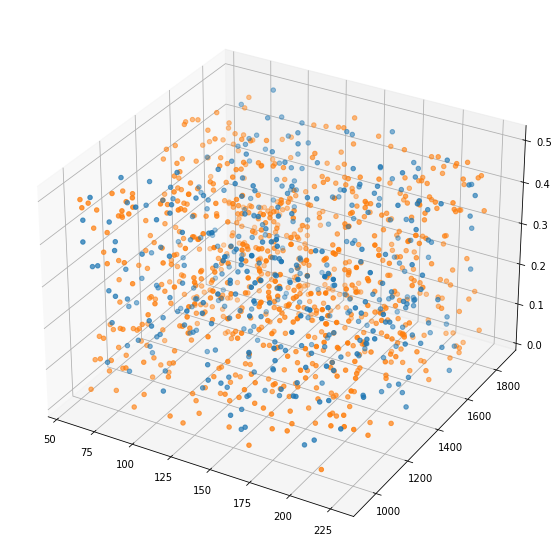

In [95]:
from cProfile import label


plt.rcParams["figure.figsize"] = (10,10)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(inputTemperature,inputVelocity,inputDensity, label = 'High Fidelity Input Variables')
ax.scatter(T_inf,u_inf, rho_inf, label = 'Low Fidelity Input Variables ')


In [22]:
a_inf = np.sqrt(gamma*R_specific*T_inf)
M_inf = u_inf/a_inf
P_inf = rho_inf*R_specific*T_inf
mu_inf = mu_suth(T_inf)

theta  = np.full((numCases,1),np.deg2rad(7))

inputDataObliqueShock = M_inf,u_inf,T_inf,P_inf,rho_inf,a_inf,theta

[*temp] = map(perfgas_oblique, M_inf,u_inf,T_inf,P_inf,rho_inf,a_inf,theta)
obliqueShockResults = np.array(temp)


outputLocalMethodVarName = [
    'H2', 
    'V2', 
    'T2', 
    'P2', 
    'rho2',
    'beta',
    'M2',
    'a2', 
    'T01', 
    'T02',
    'P01',
    'P02'
]

for i, name in enumerate(outputLocalMethodVarName):
    locals()[name] = obliqueShockResults[:,i]
## ---- Pressure Coefficient ----

# Shock Expansion for 7deg Section

shockAngle = beta

cp_ShockExpansionTheory = (4/(gamma+1))*(np.sin(shockAngle)**2 - (1/(M_inf**2)))
cp_newtonian_coneAngle = 2*(np.sin(theta)**2)

xPressureWindowStart = 0.5
xPressureWindowEnd = 2.0
xPressureWindowMid = 0.5

xSpotBegin = (np.abs(x_cc_windowed[0,:] - xPressureWindowStart)).argmin()
xSpotEnd = (np.abs(x_cc_windowed[0,:] - xPressureWindowEnd)).argmin()
xSpotNoMean = (np.abs(x_cc_windowed[0,:] - xPressureWindowMid)).argmin()

# PressureForCPActual = p[:,xSpotNoMean].reshape(-1,1)
# cp_actual = (PressureForCPActual - P_inf)/ (0.5*rho_inf*(u_inf**2))
# cp_actual[389] = None # takes care of that one bad point

#Shock Expansion For 40deg Section

T_inf2 = T2
# T_w = T_w
rho_inf2 = rho2
u_inf2 = M2*a2
a_inf2 = a2
M_inf2 = M2
P_inf2 = P2
mu_inf2 = mu_suth(T2)
theta2  = np.full((numCases,1),np.deg2rad(33))

[*temp] = map(perfgas_oblique, M_inf2,u_inf2,T_inf2,P_inf2,rho_inf2,a_inf2,theta2)
obliqueShockResults = np.array(temp)

outputLocalMethodVarName = [
    'H3', 
    'V3', 
    'T3', 
    'P3', 
    'rho3',
    'beta2',
    'M3',
    'a3', 
    'T02', 
    'T03',
    'P02',
    'P03'
]

for i, name in enumerate(outputLocalMethodVarName):
    locals()[name] = obliqueShockResults[:,i]
xPressureWindowLeft = 2.353056 # elbow location
xPressureWindowRight = 2.5039961 # end of cone

xPressureWindowMid = 2.4
xSpotLeft = (np.abs(x_cc_windowed[0,:] - xPressureWindowLeft)).argmin()
xSpotRight = (np.abs(x_cc_windowed[0,:] - xPressureWindowRight)).argmin()

# meanPressure40DegConeSection = np.median(p[:,xSpotLeft:xSpotRight], axis = 1).reshape(-1,1)
# cp_actual2 = (meanPressure40DegConeSection - P_inf2)/ (0.5*rho_inf2*(u_inf2**2))
# cp_actual2[389] = None # takes care of that one bad case

cp_newtonian_coneAngle2 = 2*(np.sin(theta2)**2)
shockAngle2 = beta2
cp_ShockExpansionTheory2 = (4/(gamma+1))*(np.sin(shockAngle2)**2 - (1/(M_inf2**2)))

p_SE_7deg = cp_ShockExpansionTheory*(0.5*rho_inf*(u_inf**2)) + P_inf
p_Newtonian_40deg = cp_newtonian_coneAngle2*(0.5*rho_inf2*(u_inf2**2)) + P_inf2
p_SE_40deg = cp_ShockExpansionTheory2*(0.5*rho_inf2*(u_inf2**2)) + P_inf2

xSpotElbow = (np.abs(x_cc_windowed[0,:] - xPressureWindowLeft)).argmin()

p_lf_7deg = np.tile(p_SE_7deg, xSpotElbow+1)
p_lf_40deg_newt = np.tile(p_Newtonian_40deg, xSpotRight - xSpotLeft)
p_lf_40deg = np.tile(p_SE_40deg, xSpotRight - xSpotLeft)
p_lowFidelity_SE = np.concatenate((p_lf_7deg, p_lf_40deg), axis=1)
p_lowFidelity_Newt = np.concatenate((p_lf_7deg, p_lf_40deg_newt), axis=1)

p_lowFidelity_SE_truncated = np.concatenate((p_SE_7deg, p_SE_40deg), axis=1)
p_lowFidelity_SE_truncated = p_lowFidelity_SE_truncated.T

# normalizedHFPressure = p/P03
# normalizedLFPressure = p_lowFidelity_SE/P03
# normalizedLFPressureNewt = p_lowFidelity_Newt/P03

p_LF = p_lowFidelity_SE

### Plotting Pressure Coefficient Results

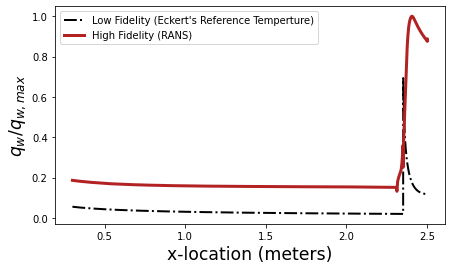

In [87]:
plt.rcParams["figure.figsize"] = (7,4)
caseWePick = random.randint(0,400)
caseWePick = 102
all_qw = np.hstack((qw_LF[caseWePick,:],qw[caseWePick,:]) )
qw_max = np.amax(all_qw)

plt.plot(x_cc_windowed[0,:],qw_LF[caseWePick,:]/qw_max, label = 'Low Fidelity (Eckert\'s Reference Temperture)',linestyle="-.", color = 'k', linewidth= 2)
plt.plot(x_cc_windowed[0,:],qw[caseWePick,:]/qw_max, label = 'High Fidelity (RANS)', color = 'firebrick', linewidth= 3)
plt.xlabel('x-location (meters)')
plt.ylabel('$q_w/q_{w,max}$')
plt.legend()

# if not superComputerTrain:
plt.rcParams["figure.figsize"] = (7,4)
caseWePick = random.randint(0,400)
caseWePick = 235
caseWePick = 102
all_p = np.hstack((p_lowFidelity_SE[caseWePick,:],p[caseWePick,:]) )
p_max = np.amax(all_p)

plt.plot(x_cc_windowed[0,:],p_lowFidelity_SE[caseWePick,:]/p_max, label = 'Low Fidelity (Shock Expansion)',linestyle="-.", color = 'k', linewidth= 2)
plt.plot(x_cc_windowed[0,:],p[caseWePick,:]/p_max, label = 'High Fidelity (RANS)', color = 'firebrick', linewidth= 3)
plt.xlabel('x-location (meters)')
plt.ylabel('$P/P_{max}$')
plt.legend()

In [88]:
# plt.scatter(x_cc_sorted[caseWePick,idxWindowStart:], normalizedHFPressure[caseWePick,:],s=5, label = 'Truth Data (RANS)', color='r')
# plt.legend()
# # plt.title('Case Number ' + str(caseWePick))
# plt.xlabel('x (meters)')
# plt.ylabel('$P/P_{03}$')
# plt.grid()

# plt.rcParams["figure.figsize"] = (5,5)
# plt.grid()
# plt.scatter(M_inf,cp_actual, label = 'RANS Truth CP', s=3)
# plt.scatter(M_inf,cp_ShockExpansionTheory, label = 'S-E Theory CP', s=3)
# plt.scatter(M_inf,cp_newtonian_coneAngle, label = 'Newtonian Theory CP', s=3)
# lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=20)
# plt.xlabel("Mach Number",fontsize='xx-large')
# plt.ylabel("Pressure Coefficient",fontsize='xx-large')
# plt.ylim([0,0.12])
# lgnd = plt.legend(loc='upper right', fontsize='x-large', markerscale = 5)
# # for i in range(0,7):
# #     lgnd.legendHandles[i]._sizes = [50]

# # TURN THIS INTO A SUBLPLOT, side by side

# plt.rcParams["figure.figsize"] = (7,5)
# plt.rcParams['figure.dpi'] = 300
# plt.grid()
# plt.scatter(M_inf,cp_actual2, label = 'RANS Truth CP', s=3)
# plt.scatter(M_inf,cp_ShockExpansionTheory2, label = 'S-E Theory CP', s=3)
# plt.scatter(M_inf,cp_newtonian_coneAngle2, label = 'Newtonian Theory CP', s=3)
# plt.scatter(M_inf,cp_actual, label = 'RANS Truth CP', s=3)
# plt.scatter(M_inf,cp_ShockExpansionTheory, label = 'S-E Theory CP', s=3)
# plt.scatter(M_inf,cp_newtonian_coneAngle, label = 'Newtonian Theory CP', s=3)
# lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=20)
# plt.rcParams['legend.facecolor'] = 'white'
# plt.xlabel("Mach Number",fontsize='xx-large')
# plt.ylabel("Pressure Coefficient",fontsize='xx-large')
# lgnd = plt.legend(loc='upper right', fontsize='x-large', markerscale = 5)

## Eckert's Reference Temperature

In [24]:
## ---- Eckert's Reference Temperature, Cone Example ----


Pr = 0.72
recovFactor = np.sqrt(Pr)
xSpotEndArtificial = x_cc_windowed[0,:].shape[0] - xSpotElbow

x_FrontCone = x_cc_windowed[0,:xSpotElbow]
x_RearCone = x_cc_windowed[0,:xSpotEndArtificial] - 0.25

T_star = 0.5*(T2 + T_w) + .22*recovFactor*(T02 - T2)
rho_star = P2/ (R_specific*T_star)
mu_star = mu_suth(T2)
u2 = M2 * a2
Re_coeff = rho_star*u2/mu_star
Re_x = Re_coeff * x_FrontCone
cone_factor = np.sqrt(3)
cH_coeff = (cone_factor*0.332)/((Pr**(2/3))*(Re_coeff**(.5)))
cH_star = cH_coeff / x_FrontCone**(1/2)
T_r = T2 + recovFactor*(T02 - T2)
q_dot_FrontCone = rho_star*u2*cp1*1000*(T_r - T_w)*cH_star

T_star2 = 0.5*(T3 + T_w) + .22*recovFactor*(T03 - T3)
rho_star2 = P3/ (R_specific*T_star2)
mu_star2 = mu_suth(T3)
u3 = M3* a3
Re_coeff2 = rho_star2*u2/mu_star2
Re_x2 = Re_coeff2 * x_RearCone
cH_coeff2 = (cone_factor*0.332)/((Pr**(2/3))*(Re_coeff2**(.5)))
cH_star2 = cH_coeff2 / x_RearCone**(1/2)
T_r2 = T3 + recovFactor*(T03 - T3)
q_dot_RearCone = rho_star2*u3*cp1*1000*(T_r2 - T_w)*cH_star2

qw_LF = np.concatenate((q_dot_FrontCone, q_dot_RearCone), axis=1)

# Low Fidelity Data Processing

In [25]:
print("="*40, "Low Fidelity Data Processing", "="*40)

======================================== Low Fidelity Data Processing ========================================


In [26]:
LFoutputVarNames = [
    'qw_LF',
    'p_LF',
]


In [27]:
totalParamsTrainData = 0
for var in LFoutputVarNames:
    totalParamsTrainData += globals()[var].shape[0] * globals()[var].shape[1]
print('Total number of parameters in training data: ', totalParamsTrainData)

Total number of parameters in training data:  2044128


### Outlier Removal

In [28]:
if outlierRemoval and (globals()[LFoutputVarNames[0]].shape[0] == numCases):
    casesToRemove = np.argwhere(np.isnan(qw_LF).any(axis=1))
    if numpPointsMultiplier == 2:
        casesToRemove = [648]
    
    for i, outputVarName in enumerate(LFoutputVarNames): 
        globals()[outputVarName] = np.delete(locals()[outputVarName], casesToRemove, axis=0)
        print('Removed ', len(casesToRemove), ' cases.')
        print(outputVarName, 'new shape ', str(globals()[outputVarName].shape))

    for i, inputVarName in enumerate(LFinputVarNames): 
        globals()[inputVarName] = np.delete(locals()[inputVarName], casesToRemove, axis=0)
        print('Removed ', len(casesToRemove), ' cases.')
        print(inputVarName, 'new shape ', str(globals()[inputVarName].shape))

    M_inf = np.delete(M_inf, casesToRemove, axis=0)
    print('M_inf new shape ', str(M_inf.shape))

Removed  1  cases.
qw_LF new shape  (795, 1284)
Removed  1  cases.
p_LF new shape  (795, 1284)
Removed  1  cases.
T_w new shape  (795, 1)
Removed  1  cases.
rho_inf new shape  (795, 1)
Removed  1  cases.
T_inf new shape  (795, 1)
Removed  1  cases.
u_inf new shape  (795, 1)
M_inf new shape  (795, 1)


### Data Scaling

In [29]:
LFinputTrainingData = []
LFinputTrainingNames = []

print('Input Data (stored in list inputTrainingData):\n')
for i, name in enumerate(LFinputVarNames):
    ScalerName = name + '_InputScaler'
    ScaledName = name + '_Scaled'
    locals()[ScalerName] = None
    locals()[ScalerName] = preprocessing.StandardScaler()
    locals()[ScaledName] = locals()[ScalerName].fit_transform(globals()[name])
    LFinputTrainingData.append(locals()[ScaledName])
    LFinputTrainingNames.append(ScaledName)
    max_element = str(round(np.max(locals()[ScaledName]),2))
    min_element = str(round(np.min(locals()[ScaledName]),2))
    print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)

LFoutputTrainingData = []
LFoutputTrainingNames = []

print('\nOutput Data (stored in list LFoutputTrainingData):\n')
for i, name in enumerate(LFoutputVarNames):
    ScalerName = name + '_OutputScaler'
    ScaledName = name + '_Scaled'
    OutputDataName = name
    locals()[ScalerName] = None
    locals()[ScalerName] = preprocessing.StandardScaler()
    locals()[ScaledName] = locals()[ScalerName].fit_transform(globals()[OutputDataName])
    LFoutputTrainingData.append(locals()[ScaledName])
    LFoutputTrainingNames.append(ScaledName)
    max_element = str(round(np.max(locals()[ScaledName]),2))
    min_element = str(round(np.min(locals()[ScaledName]),2))
    print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)

print(str(np.shape(LFinputTrainingData)))
print(str(np.shape(LFoutputTrainingData)))
print(LFinputTrainingNames)
print(LFoutputVarNames)
print(LFoutputTrainingNames)

if downsampleLF: 
    ##################################################
    ####### Heat Flux and Pressure Downsample ########
    ################################################## 
    conePoint = 2.0
    flarePoint = 2.49
    xLocationPressureValue1 = (np.abs(x_cc_windowed[0,:] - conePoint)).argmin()
    xLocationPressureValue2 = (np.abs(x_cc_windowed[0,:] - flarePoint)).argmin()

    indices = [xLocationPressureValue1, xLocationPressureValue2]
    LFoutputTrainingData = []
    for name in LFoutputTrainingNames:
        globals()[name] = np.take(globals()[name], indices, axis=1)
        LFoutputTrainingData.append(globals()[name])
        print(name, ' truncated. Added to LFoutputTrainingData')
    x_downsampledPressure = np.take(x_cc_windowed, indices, axis=1)

print(str(np.shape(LFinputTrainingData)))
print(str(np.shape(LFoutputTrainingData)))
print(LFinputTrainingNames)
print(LFoutputVarNames)
print(LFoutputTrainingNames)

Input Data (stored in list inputTrainingData):

T_w has been scaled! It is called T_w_Scaled. Min:-1.73. Max:1.73
rho_inf has been scaled! It is called rho_inf_Scaled. Min:-1.73. Max:1.73
T_inf has been scaled! It is called T_inf_Scaled. Min:-1.73. Max:1.73
u_inf has been scaled! It is called u_inf_Scaled. Min:-1.73. Max:1.73

Output Data (stored in list LFoutputTrainingData):

qw_LF has been scaled! It is called qw_LF_Scaled. Min:-1.37. Max:4.35
p_LF has been scaled! It is called p_LF_Scaled. Min:-1.57. Max:3.91
(4, 795, 1)
(2, 795, 1284)
['T_w_Scaled', 'rho_inf_Scaled', 'T_inf_Scaled', 'u_inf_Scaled']
['qw_LF', 'p_LF']
['qw_LF_Scaled', 'p_LF_Scaled']
qw_LF_Scaled  truncated. Added to LFoutputTrainingData
p_LF_Scaled  truncated. Added to LFoutputTrainingData
(4, 795, 1)
(2, 795, 2)
['T_w_Scaled', 'rho_inf_Scaled', 'T_inf_Scaled', 'u_inf_Scaled']
['qw_LF', 'p_LF']
['qw_LF_Scaled', 'p_LF_Scaled']


## Model Convergence Study

### LF Kriging Convergence

In [30]:
lowFidelityDataGenAndProcess(downsampleLF=True,verbose=True)

T_w created , shape  (796, 1)
Lower bound:  200.47191359532894 . Upper bound:  599.544442276851
rho_inf created , shape  (796, 1)
Lower bound:  0.01831460248187648 . Upper bound:  0.49941014005079754
T_inf created , shape  (796, 1)
Lower bound:  56.71996356203486 . Upper bound:  226.55611821056678
u_inf created , shape  (796, 1)
Lower bound:  932.2566935369646 . Upper bound:  1870.5645982537449
Num low-fidelity cases:  796
p_LF shape:  (796, 1284)
qw_LF shape:  (796, 1284)
qw_LF globals: (796, 1284) locals:  (796, 1284)
p_LF globals: (796, 1284) locals:  (796, 1284)
Total number of parameters in training data:  2044128
outlierRemoval criteria: True  and  True
796 ==  796
Entered outlier removal loop
qw_LF new shape  (795, 1284)
p_LF new shape  (795, 1284)
T_w new shape  (795, 1)
rho_inf new shape  (795, 1)
T_inf new shape  (795, 1)
u_inf new shape  (795, 1)
M_inf new shape  (795, 1)
Removed  1  case(s).
Input Data (stored in list inputTrainingData):

T_w has been scaled! It is called T

In [ ]:
LFoptimizedKernel1 = 0.0873**2 + Matern(length_scale=7.53, nu=1.5) + WhiteKernel(noise_level=0.00121)
LFoptimizedKernel2 = 5.31**2 * RBF(length_scale=5.08) + WhiteKernel(noise_level=0.00179)
LFoptimizedKernel3 = 4.33**2 * RationalQuadratic(alpha=0.00285, length_scale=12.1)

top_n_modelChoices = [ 
        LFoptimizedKernel1,
        LFoptimizedKernel2,
        LFoptimizedKernel3
        ] 

start = 0.20 ; stop = 0.80 ; step = 0.03
splitList = np.arange(start=start,stop=stop+step,step=step)
splitList = splitList[splitList<=0.8]

LF_krig_modelConvergenceDict = modelConvergenceStudy(
    fidelityLevel= 'LF', 
    modelType= 'krig',
    M_inf=M_inf,
    inputTrainingData=LFinputTrainingData,
    outputTrainingData=LFoutputTrainingData,
    inputTrainingNames=LFinputTrainingNames,
    outputTrainingNames=LFoutputTrainingNames,
    top_n_modelChoices=top_n_modelChoices,
    splitList=splitList,
    verbose=False,
    truncate=True,
    hyperparamDict=None,
    callbacks_list=None,
    n_restarts=1
    )

In [ ]:
plotModelConvergenceStudy(
    top_n_modelChoices,
    splitList,
    convDict= LF_krig_modelConvergenceDict,
    fidelityLevel='LF',
    modelChoice='krig',
    peakMiss = 'median')

### LF Neural Network Convergence

In [ ]:
top_n_modelChoices = [ 
        [56, 80],
        [40,32],
        [32, 64],
        [48, 56, 40],
        [80,32,80]
        ] 

start = 0.20 ; stop = 0.80 ; step = 0.03
splitList = np.arange(start=start,stop=stop+step,step=step)
splitList = splitList[splitList<=0.8]

hyperparamDict = {
    "learningRate" : 1.0e-3,
    "regType" : keras.regularizers.L2,
    "regValue" : 1.0e-6,
    "hiddenLayerActivation" : tf.nn.tanh,
    "outputLayerActivation" : tf.nn.leaky_relu,
    "kernelInitializer" : tf.keras.initializers.GlorotUniform(),
    "optimizer" : tf.keras.optimizers.Adamax,
    "numEpochs" : 7000,
    "myBatchSize" : 224,
    "loss" : 'mse'
}

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = "val_mean_squared_error",mode="min",
        patience=200, verbose=0,
        restore_best_weights=False 
        )
    ]

LF_NN_modelConvergenceDict = modelConvergenceStudy(
    fidelityLevel= 'LF', 
    modelType= 'NN',
    M_inf=M_inf,
    inputTrainingData=LFinputTrainingData,
    outputTrainingData=LFoutputTrainingData,
    inputTrainingNames=LFinputTrainingNames,
    outputTrainingNames=LFoutputTrainingNames,
    top_n_modelChoices=top_n_modelChoices,
    splitList=splitList,
    frequencyData = False,
    verbose=False,
    truncate=True,
    hyperparamDict=hyperparamDict,
    callbacks_list=callbacks_list,
    n_restarts=None
    )

In [ ]:
plotModelConvergenceStudy(
    top_n_modelChoices,
    splitList,
    convDict= LF_NN_modelConvergenceDict,
    fidelityLevel='LF',
    modelChoice='NN',
    peakMiss = 'median')

### Validation Split 

In [27]:
##### SKLEARN DATA SPLIT 

dataSplit = 0.77
test_size = round(1-dataSplit,4)

X = np.hstack(LFinputTrainingData)
y_lf = np.hstack(LFoutputTrainingData)
Y_lf_names = np.hstack(LFoutputTrainingNames)
X_names = np.hstack(LFinputTrainingNames)
originalIdx = np.arange(0,X.shape[0])

X_train, X_test, y_lf_train, y_lf_test, M_inf_train, M_inf_test, trainIdx, testIdx = train_test_split(
    X, y_lf, M_inf, originalIdx, test_size=test_size, random_state=random_state)

X_test, X_val, y_lf_test, y_lf_val, M_inf_test, M_inf_val, testIdx, valIdx = train_test_split(
    X_test, y_lf_test, M_inf_test, testIdx, test_size=0.50, random_state=random_state)

print("Low fidelity X_train shape: {}".format(X_train.shape))
print("Low fidelity X_test shape: {}".format(X_test.shape))
print("Low fidelity X_val shape: {}".format(X_val.shape))
print("Low fidelity y_lf_train shape: {}".format(y_lf_train.shape))
print("Low fidelity y_lf_test shape: {}".format(y_lf_test.shape))
print("Low fidelity y_lf_val shape: {}".format(y_lf_val.shape))
print(f"concatenation order: {X_names}")
print(f"concatenation order: {Y_lf_names}")

Low fidelity X_train shape: (612, 4)
Low fidelity X_test shape: (91, 4)
Low fidelity X_val shape: (92, 4)
Low fidelity y_lf_train shape: (612, 4)
Low fidelity y_lf_test shape: (91, 4)
Low fidelity y_lf_val shape: (92, 4)
concatenation order: ['T_w_Scaled' 'rho_inf_Scaled' 'T_inf_Scaled' 'u_inf_Scaled']
concatenation order: ['qw_LF_Scaled' 'p_LF_Scaled']


# LF Data Gen and Process Func

In [ ]:
lowFidelityDataGenAndProcess(verbose=False)

# LF Kriging

In [ ]:
print("="*40, "Low Fidelity Kriging", "="*40)

In [ ]:
# # Kernel options include: Compound, Constant, Dot Product, Exponentiation, ExpSineSquared, 
# # Product, Rational Quadratic, RBF, Sum, White

# # Benchmark Function 1
# kernel1 = ConstantKernel(1.0, (1e-8, 1e2)) * RBF(1.0, (1e-8, 1e2)) # Works great for Benchmark Function 1

# #Benchmark Function 2
# kernel2 = 66.3*RBF(0.1, (1e-8, 1e2)) #seems to work well for discontinuities, so we'll try for Benchmark Function 2

# #Benchmark Function 3
# kernel3 = kernel2

LFoptimizedKernel1 = 0.0873**2 + Matern(length_scale=7.53, nu=1.5) + WhiteKernel(noise_level=0.00121)
LFoptimizedKernel2 = 5.31**2 * RBF(length_scale=5.08) + WhiteKernel(noise_level=0.00179)
LFoptimizedKernel3 = 4.33**2 * RationalQuadratic(alpha=0.00285, length_scale=12.1)

# Below are the different kernels (and combinations of kernels) that Dr. Reasor used in his code

#kernel = ConstantKernel(1.0) + Matern(length_scale=0.1, nu=3/2) #+ WhiteKernel(noise_level=1)
#kernel = 1.0*Matern(length_scale=0.1, nu=1.5)
#kernel = RationalQuadratic()
#kernel = Matern(length_scale=0.1, nu=2.5)  #
#kernel = ConstantKernel(1.0, (1e-8, 1e2)) * RBF(0.1, (1e-8, 1e2))
#kernel = Cdatetime.dateonstantKernel(1.0, (1e-3, 1e3))*RBF(1.0, (1e-2, 1e2))

## Optimize Kriging

In [ ]:
if LFKrigOptimize:

    longKernel = 34.4**2 * RBF(length_scale=41.8) \
    + 3.27**2 * RBF(length_scale=180) \
        * ExpSineSquared(length_scale=1.44, periodicity=1) \
        + 0.446**2 * RationalQuadratic(alpha=17.7, length_scale=0.957) \
            + 0.197**2 * RBF(length_scale=0.138) + WhiteKernel(noise_level=0.0336)

    LFoptimizedKernel1 = 3.01**2 * RationalQuadratic(alpha=0.00531, length_scale=0.712)	
    LFoptimizedKernel2 = 0.00316**2 + Matern(length_scale=5.35, nu=1.5) + WhiteKernel(noise_level=0.134)
    HFoptimizedKernel1 = 2.28**2 * RBF(length_scale=3.09) + WhiteKernel(noise_level=0.002)
    HFoptimizedKernel2 = 1.54**2 * Matern(length_scale=3.7, nu=2.5)
    HFoptimizedKernel3 = 2.75**2 * RBF(length_scale=3.48) + WhiteKernel(noise_level=0.00161)

    kernels = [
    100 * RBF(length_scale=0.1, length_scale_bounds=(1e-1, 10.0)) + WhiteKernel(noise_level=1),
    2.44**2 * RBF(length_scale=2.41),
    1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
    #ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
    1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),nu=2.5),
    ConstantKernel(1.0) + Matern(length_scale=0.1, nu=3/2) + WhiteKernel(noise_level=1),
    LFoptimizedKernel1,
    bigInputSpaceLFOptimizedKernel,
    HFoptimizedKernel1,
    HFoptimizedKernel2,
    HFoptimizedKernel3,
    # LFoptimizedKernel2,
    # HFoptimizedKernel,
    # #]
    longKernel
    ]

    LFerrorCompDataFrame, LFerrorDict, LFmodelDict = optimizeKrig(
        kernelList = kernels,
        X_train = X_train, 
        y_train = y_lf_train, 
        X_test = X_test,
        y_test = y_lf_test,
        fidelityLevel = "LF",
        method = "krig",
        n_restarts = 1,
        verbose=True)

In [ ]:
# df = LFerrorCompDataFrame
# df
# pd.set_option('display.max_colwidth', None)
# newdf = df.sort_values(by=['NRMSE (Pressure)', 'NRMSE (Heat Transfer)'])
# newdf
# loadKrigOpt(filename='optimizerPickle_LF_2022-06-09.pkl',dictName='krigOptDict',printKeys=True)
# df = pd.DataFrame.from_dict(krigOptDict)
# df

## Train LF Kriging

In [28]:
# if there are convergence issues, we need to change the optimizer in a manual way. possibly through "inheritance," 
# or maybe by copying the source code and modifying the optimizer to increase max iters
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html
# https://github.com/scikit-learn/scikit-learn/blob/16625450b/sklearn/gaussian_process/_gpr.py#L24

# LFoptimizedKernel = 3.01**2 * RationalQuadratic(alpha=0.00531, length_scale=0.712)	
# LFoptimizedKernel = 2.44**2 * RBF(length_scale=2.41)

# LFoptimizedKernel = 0.00316**2 + Matern(length_scale=5.35, nu=1.5) + WhiteKernel(noise_level=0.134)

# bigInputSpaceLFOptimizedKernel = 5.15**2 * RBF(length_scale=5.01) + WhiteKernel(noise_level=0.00288)	
lowFidelityDataGenAndProcess(verbose=False, downsampleLF=downsampleLF)

LFoptimizedKernel1 = 0.0109**2 + Matern(length_scale=6.91, nu=1.5) + WhiteKernel(noise_level=0.00212)

if LFKrigTrain: 

  krigTrain(
    X_train=X_train,
    y_train=y_lf_train, 
    fidelityLevel='LF',
    kernel=LFoptimizedKernel1, 
    n_restarts = 1,
    verbose=True
    )
    

Low fidelity data generated, scaled, and split. Low fidelity output data truncation:  True
LF_krig training begin
LF_krig training end
LF Kriging train time: 7.0910289 seconds
Model name:  LF_krig
Original kernel: 0.0109**2 + Matern(length_scale=6.91, nu=1.5) + WhiteKernel(noise_level=0.00212)
Optimized kernel: 0.0109**2 + Matern(length_scale=6.94, nu=1.5) + WhiteKernel(noise_level=0.00202)
_________________________


## Save LF Kriging

In [ ]:
if LFKrigSave:
    saveKrig(fidelityLevel='LF')

## Load LF Kriging

In [ ]:
if LFKrigLoad:

    filename = 'LF_krig_2022-05-17.sav'
    desiredLoadedModelName = 'LF_krig_loaded'

    locals()[desiredLoadedModelName] = pickle.load(open(filename, 'rb'))
    
    LF_krig = None
    LF_krig = LF_krig_loaded
    LF_krig_loaded = None

## Generate Predictions

In [29]:
if LFKrigTrain or LFKrigLoad:

    generateInverseTransformedPredictions(
        X_train = X_train,
        X_test = X_test,
        y_train = y_lf_train,
        y_test = y_lf_test,
        method = 'kriging',
        fidelityLevel = 'LF',
        verbose= True,
        truncate=downsampleLF
        )

Method: kriging, Fidelity Level: LF
_________________________
LF_krig_test_predict part 1--> qw_LF_krig_test_predict
LF_test_truth part 1--> qw_LF_test_truth
LF_krig_test_predict part 2--> p_LF_krig_test_predict
LF_test_truth part 2--> p_LF_test_truth
LF_krig_train_predict part 1--> qw_LF_krig_train_predict
LF_train_truth part 1--> qw_LF_train_truth
LF_krig_train_predict part 2--> p_LF_krig_train_predict
LF_train_truth part 2--> p_LF_train_truth
['qw_LF_krig_test_predict', 'qw_LF_test_truth', 'p_LF_krig_test_predict', 'p_LF_test_truth', 'qw_LF_krig_train_predict', 'qw_LF_train_truth', 'p_LF_krig_train_predict', 'p_LF_train_truth']
_______________
Prediction frequency: 29464.35878 Hz. Prediction time per case: 0.0000351 seconds
_______________
leftFluidScalarDistributionLength: 885
rightFluidScalarDistributionLength: 399
qw_LF_krig_test_predict  shape:  (79, 1284)
qw_LF_test_truth  shape:  (79, 1284)
p_LF_krig_test_predict  shape:  (79, 1284)
p_LF_test_truth  shape:  (79, 1284)
qw_LF_kr

In [ ]:
if LFKrigTrain or LFKrigLoad: 
    if 'tempLFinputVarNames' not in globals():
        tempLFinputVarNames = LFinputVarNames + ['M_inf']
    # rmse = mean_squared_error(truth, prediction, squared=False)
    pdDict = dict()
    for name in tempLFinputVarNames:
        xss = globals()[name][testIdx].tolist()
        pdDict[name] = [x for xs in xss for x in xs]
    errorList = []
    totalTestCases = X_test.shape[0]

    for case in np.arange(totalTestCases):
        p_nrmse = normalizedRootMeanSquaredError(p_LF_test_truth[case], p_LF_krig_test_predict[case])
        qw_nrmse = normalizedRootMeanSquaredError(qw_LF_test_truth[case], qw_LF_krig_test_predict[case])
        mean_nrmse = np.mean((p_nrmse, qw_nrmse))
        added_nrmse = p_nrmse + qw_nrmse
        errorList.append(added_nrmse)

    #     caseList = [testIdx, trainIdx]
    pdDict["Error"] = errorList
    df1 = pd.DataFrame(pdDict) 
    plt.hist(errorList)
    plt.title('Test NRMSE Histogram')
    plt.show()

In [ ]:
if LFKrigTrain or LFKrigLoad: 
    plt.figure(figsize=(15, 15))
    for i, name in enumerate(tempLFinputVarNames):
        ax = plt.subplot(len(tempLFinputVarNames), 2, i+1)
        ax.scatter(globals()[name][testIdx],errorList)
        ax.set_title(name + ' error')
        # ax.set_yscale('log')

In [ ]:
# g = sns.pairplot(df1, hue="Error",diag_kind="histogram", corner=True)
# g.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
if LFKrigTrain or LFKrigLoad: 
    plotInputSpaceErrorColorMap(
        testIdxArray = testIdx,
        trainIdxArray = trainIdx,
        topErrorValuesToPlot = 5,
        inputVarNameList=tempLFinputVarNames,
        errorList = errorList,
        logPlot=False
    )

In [ ]:
if LFKrigTrain or LFKrigLoad:
    oneToOnePlotTool(method='Kriging', 
                    desiredNumCasesForPlot=30, 
                    X_test=X_test, 
                    qw_prediction = qw_LF_krig_test_predict, 
                    qw_truth = qw_LF_test_truth, 
                    p_prediction = p_LF_krig_test_predict, 
                    p_truth = p_LF_test_truth)

In [ ]:
if LFKrigTrain or LFKrigLoad:
    oneToOneVisualizationPlotAllData(case=33, 
        qw_test_predict=qw_LF_krig_test_predict,
        p_test_predict=p_LF_krig_test_predict, 
        qw_test_truth=qw_LF_test_truth, 
        p_test_truth=p_LF_test_truth, 
        M_inf_test=M_inf_test,
        method='Kriging')

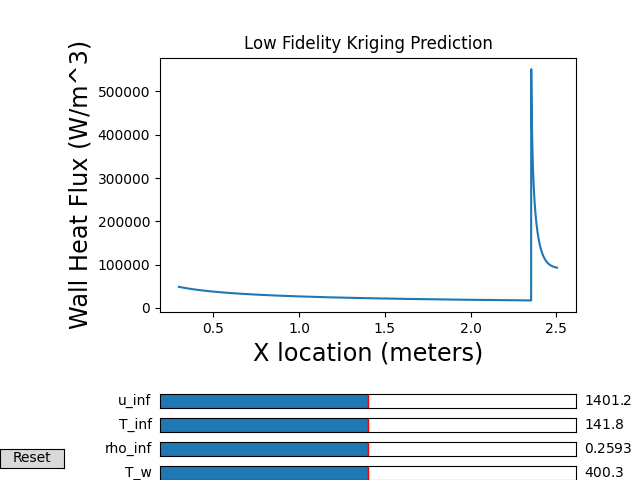

In [30]:
%matplotlib ipympl

modelType = 'krig'
fidelityLevel = 'LF'
truncate = True

plt.close('all')

def genSinglePredictionForSliderPlot(
    modelType, fidelityLevel,inputArray, truncate
    ):

    modelName = f'{fidelityLevel}_{modelType}'
    predictions  = globals()[modelName].predict(inputArray)
    variableNameList = ['qw_plotting', 'p_plotting']
    for i, name in enumerate(variableNameList):
        globals()[name] = np.hsplit(predictions,len(variableNameList))[i]
    if truncate: 
        leftFluidScalarDistributionLength = globals()[outputVarNames[0]][0,:xSpotLeft].shape[0]
        rightFluidScalarDistributionLength =  globals()[outputVarNames[0]][0,xSpotLeft:].shape[0]

        for var in variableNameList:
            temp_left = [np.tile(entry, leftFluidScalarDistributionLength) for entry in globals()[var][:,0] ]
            temp_right = [np.tile(entry,rightFluidScalarDistributionLength) for entry in globals()[var][:,1] ]
            temp_stacked = np.hstack((temp_left,temp_right))
            globals()[var] = temp_stacked
    qw_plotting = qw_LF_OutputScaler.inverse_transform(globals()['qw_plotting'])

    distribution = qw_plotting

    return distribution


variableNameList = ['qw_plotting', 'p_plotting']

fig,ax = plt.subplots()
plt.subplots_adjust(bottom=0.35, left=0.25)
plt.title('Low Fidelity Kriging Prediction')
plt.xlabel('X location (meters)')
plt.ylabel('Wall Heat Flux (W/m^3)')
# initialize axis location

allInputVars = [globals()[name] for name in LFinputVarNames]
valinitList = [np.median(val) for val in allInputVars]
allInputVars = None

qw_plotting = genSinglePredictionForSliderPlot(
    modelType=modelType, 
    fidelityLevel=fidelityLevel,
    inputArray=np.asarray(valinitList).reshape(1,-1), 
    truncate=truncate
    )

# display initial plot. initial case can be anything, I just chose number 10
xPlot = x_cc_windowed[0,:].reshape(-1,)
yPlot = qw_plotting.reshape(-1,)
l, = plt.plot(xPlot, yPlot)

axLocation = 0
for varName in LFinputVarNames: 
# set up axis location for slider bars
    axName = 'ax_'+ varName
    globals()[axName] = plt.axes([0.25, axLocation, 0.65, 0.03])
    axLocation += .05

    # define the values to use for snapping
    snapValueName = 'allowed_'+varName
    globals()[snapValueName] = globals()[varName].reshape(-1,)

    # create sliders
    sliderName = 'slider_'+varName
    valmin = globals()[varName].min()
    valmax = globals()[varName].max()
    valinit = np.median(globals()[varName])
    valinitList.append(valinit)
    globals()[sliderName] = Slider(
        ax = globals()[axName],
        label = varName,
        valmin = valmin,
        valmax = valmax,
        valinit = valinit,
        valstep = globals()[snapValueName]
    )


def update(val):
    inputArrayShape = (1, len(LFinputVarNames))
    inputArray = None
    inputArray = np.empty(inputArrayShape)
    for i, varName in enumerate(LFinputVarNames):
        ScalerName = varName + '_InputScaler'
        sliderName = f'slider_{varName}'
        preTransformedInput = globals()[sliderName].val
        inputArray[0,i] = globals()[ScalerName].transform(np.array(preTransformedInput).reshape(1,-1))
    
    distribution = genSinglePredictionForSliderPlot(
        modelType = modelType,
        fidelityLevel = fidelityLevel,
        inputArray = inputArray,
        truncate=truncate)

    l.set_ydata(distribution)
    fig.canvas.draw_idle()

for varName in LFinputVarNames:
    sliderName = f'slider_{varName}'
    globals()[sliderName].on_changed(update)

ax_reset = plt.axes([0.0, 0.025, 0.1, 0.04])
button = Button(ax_reset, 'Reset', hovercolor='0.975')

def reset(event):
    for varName in LFinputVarNames:
        sliderName = f'slider_{varName}'
        globals()[sliderName].reset()

button.on_clicked(reset)

plt.show()

# Low Fidelity Neural Network 

In [ ]:
print("="*40, "Low Fidelity Neural Network", "="*40)

In [ ]:
# Build hypermodel. Essentially capable of accepting one more argument, not listed, 'hp.' 
if LFNNOptimize:

    hypermodel = hyperMLP(
        input_data = X_train, 
        output_data = y_lf_train,
        regType = keras.regularizers.L2, 
        regValue = 1.0e-6,
        hiddenLayerActivation = tf.nn.tanh,
        outputLayerActivation = tf.nn.leaky_relu,
        kernelInitializer = tf.keras.initializers.GlorotUniform(),
        optimizer = tf.keras.optimizers.Adamax,
        loss = 'mse'
        )

In [ ]:
if LFNNOptimize:

    numEpochs = 200
    validData = (X_test, y_lf_test)
    hyperband_iterations = 5
    callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor = "val_mean_squared_error",mode="min",
            patience=100, verbose=0,
            restore_best_weights=False 
            )
        ]

    if quickTestRun:
        numEpochs = 10
        hyberband_iterations = 1
        callbacks_list = []


    if tunerChoice == 'RandomSearch':
        tuner = kt.RandomSearch(
            hypermodel = hypermodel,
            objective = 'val_mean_squared_error',
            max_trials = 100,
            executions_per_trial = 2,
            directory =  tunerDir,
            overwrite = True,
            project_name='ktRS'
        )

    elif tunerChoice == 'Hyperband':
        tuner = kt.Hyperband(
            hypermodel = hypermodel,
            objective = 'val_mean_squared_error',
            max_epochs= 1000,
            factor=3,
            hyperband_iterations=hyperband_iterations,
            directory = tunerDir,
            overwrite = True,
            project_name='ktHB',
            max_model_size = int(totalParamsTrainData)/2
        )

    tuner.search_space_summary()

    tuner.search(
        x=X_train,
        y=y_lf_train,
        batch_size=224,
        epochs=numEpochs,
        callbacks = [],
        verbose=True,
        shuffle=False,
        validation_data=validData,
        use_multiprocessing=True, 
        )

    top_n = 10
    best_hps = tuner.get_best_hyperparameters(top_n)
        
    for best_hp in best_hps:
        print('_'*10)
        print('learning rate: ', best_hp.get('learning_rate'))
        print('layers: ',best_hp.get('layers'))
        print('units1: ',best_hp.get('units1'))
        print('units2: ',best_hp.get('units2'))
        print('units3: ',best_hp.get('units3'))
        print('_'*10)

    saveTuner(tuner = tuner, fidelityLevel = 'LF')


In [ ]:
if LFNNOptimize:
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(    
        x=X_train,
        y=y_lf_train,
        batch_size=None,
        epochs=numEpochs,
        callbacks = [],
        verbose=True,
        shuffle=False,
        validation_data=validData,
        use_multiprocessing=True#,
        # steps_per_execution=10,
        # jit_compile=True
        )

    val_mse_per_epoch = history.history['val_mean_squared_error']
    best_epoch = val_mse_per_epoch.index(max(val_mse_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))


In [ ]:
if LFNNOptimize:
    mseNames = ["mean_squared_error",
                'val_mean_squared_error'
                ]
    colorList = [ 'k', 'r']

    plotTrainAndTestLoss(historyDict = history.history,
                        mseNames = mseNames,
                        colorList = colorList,
                        fidelityLevel = 'Tuned Model')


In [42]:
lowFidelityDataGenAndProcess(verbose=True, downsampleLF=True)

T_w created , shape  (796, 1)
Lower bound:  200.47191359532894 . Upper bound:  599.544442276851
rho_inf created , shape  (796, 1)
Lower bound:  0.01831460248187648 . Upper bound:  0.49941014005079754
T_inf created , shape  (796, 1)
Lower bound:  56.71996356203486 . Upper bound:  226.55611821056678
u_inf created , shape  (796, 1)
Lower bound:  932.2566935369646 . Upper bound:  1870.5645982537449
Num low-fidelity cases:  796
p_LF shape:  (796, 1284)
qw_LF shape:  (796, 1284)
qw_LF globals: (796, 1284) locals:  (796, 1284)
p_LF globals: (796, 1284) locals:  (796, 1284)
Total number of parameters in training data:  2044128
outlierRemoval criteria: True  and  True
796 ==  796
Entered outlier removal loop
qw_LF new shape  (795, 1284)
p_LF new shape  (795, 1284)
T_w new shape  (795, 1)
rho_inf new shape  (795, 1)
T_inf new shape  (795, 1)
u_inf new shape  (795, 1)
M_inf new shape  (795, 1)
Removed  1  case(s).
Input Data (stored in list inputTrainingData):

T_w has been scaled! It is called T

In [ ]:
if LFNNConvergence: 
    callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor = "val_mean_squared_error",mode="min",
            patience=200, verbose=0,
            restore_best_weights=False 
            )
        ]

    convStudyLayerList = [ 
        [64],
        [72],
        [80],
        [40, 32],
        [32, 64],
        [56, 72],
        [56, 80],
        [80, 80],
        [64, 80, 80],
        [48, 56, 40],
        [64, 80, 32],
        [40, 56, 64],
        [80, 80, 80],
        [32, 64, 128],
        [64, 128, 128+32]
        ] 

    # convStudyLayerList = [ 

    #     # [80],
    #     [32, 64],
    #     # [56, 80],
    #     # [64, 80, 32],
    #     # [40, 56, 64],
    #     [80, 80, 80],
    #     [32, 64, 128],
    #     [64, 128, 128+32],
    #     [32, 64, 96, 128],
    #     # [64, 80 ,80, 32],
    #     # [64, 80 , 80, 80, 32],
    #     # [32, 64, 32, 128]
    #     ]   

    hyperparamDict = {
        "learningRate" : 1.0e-3,
        "regType" : keras.regularizers.L2,
        "regValue" : 1.0e-6,
        "hiddenLayerActivation" : tf.nn.tanh,
        "outputLayerActivation" : tf.nn.leaky_relu,
        "kernelInitializer" : tf.keras.initializers.GlorotUniform(),
        "optimizer" : tf.keras.optimizers.Adamax,
        "numEpochs" : 10000,
        "myBatchSize" : 224,
        "loss" : 'mse'
    }
    validData = (X_test, y_lf_test)

    neuralNetworkConvergence(
        fidelityLevel='LF',
        convStudyLayerList = convStudyLayerList,
        hyperparamDict = hyperparamDict,
        X_train = X_train,
        y_train = y_lf_train,
        validData = validData,
        callbacks_list = callbacks_list,
        verbose = True,
        showConvPlot = True,
        saveConvPlot = True,
        showMSEplot = True,
        saveMSEplot = True,
        showSpeedPlot = True,
        saveSpeedPlot =True
        )

In [43]:
lowFidelityDataGenAndProcess(verbose=False, downsampleLF=True)
if LFNNTrain:
      lowFidelityLayerSizeList = [56, 80] #input the number of neurons per layer. Length of this list indicates number of hidden layers
      learningRate = 1.0e-3 #From Deep Learning w/ Python (Chollet)
      regType = keras.regularizers.L2
      regValue = 1.0e-6
      hiddenLayerActivation = tf.nn.tanh
      outputLayerActivation = tf.nn.leaky_relu
      kernelInitializer = tf.keras.initializers.GlorotUniform()
      optimizer = tf.keras.optimizers.Adamax
      numEpochs = 10000
      if quickTestRun:
            numEpochs = 50
      myBatchSize = None
      validSplit = None
      loss = 'mse'
      validData = (X_test, y_lf_test)

      callbacks_list = None
      callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor = "val_mean_squared_error",mode="min",
            patience=200, verbose=0,
            restore_best_weights=False 
            )
        ]

      LF_NN = None #sometimes remnants of previously trained models can hang around, it's best 
                  #to clear the variable first 

      LF_NN = build_model_parameterized(
            input_data = X_train, 
            output_data = y_lf_train,
            layerSizeList = lowFidelityLayerSizeList, 
            rate = learningRate, 
            regType = regType, 
            regValue = regValue,
            hiddenLayerActivation = hiddenLayerActivation,
            outputLayerActivation = outputLayerActivation,
            kernelInitializer = kernelInitializer,
            optimizer = optimizer,
            outputLayerDataType= 'float64',
            loss = loss)


            
kerasPlotModel(model=LF_NN,fidelityLevel='LF')
LF_NN.summary()

Low fidelity data generated, scaled, and split. Low fidelity output data truncation:  True
Can't use 'plot model', probably missing graphviz
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 56)                280       
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4560      
_________________________________________________________________
outputlayer (Dense)          (None, 4)                 324       
Total params: 5,164
Trainable params: 5,164
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batchTest(
    model=LF_NN,
    fidelityLevel = 'LF',
    batchSizeMultiples=10,
    input_data=X_train,
    output_data=y_lf_train,
    validData=validData,
    numEpochs=40
    )

In [ ]:
loadTunerPKL(
    filename = 'tunerPickle_LF_2022-06-10.pkl',
)


top_n = 20
best_hps = tuner.get_best_hyperparameters(top_n)
    
for best_hp in best_hps:
    print('_'*10)
    print('learning rate: ', best_hp.get('learning_rate'))
    print('layers: ',best_hp.get('layers'))
    print('units1: ',best_hp.get('units1'))
    print('units2: ',best_hp.get('units2'))
    print('units3: ',best_hp.get('units3'))
    print('_'*10)



In [ ]:
loadBatchTest(
    filename='timePickle_LF_2022-06-09.pkl',
    DFname='timeDF',
    printDF=True
    )

In [ ]:
# tf.debugging.set_log_device_placement(True)

if LFNNTrain:
        
    LF_NN_epochs = None
    LF_NN_history = None
    print('GPU training start')
    start = time.time()
    LF_NN_epochs, LF_NN_history = train_model_all_fidelity(
        model = LF_NN, 
        input_data = X_train, 
        output_data = y_lf_train,
        numEpochs = numEpochs, 
        myBatchSize = myBatchSize,
        validData = validData,
        callbacks_list= callbacks_list)
    end = time.time()
    print('GPU training complete')
    print(round((end-start),4))
    
#     # with tf.device('/CPU:0'):
#     #     LF_NN_epochs = None
#     #     LF_NN_history = None
#     #     print('CPU training start')
#     #     start = time.time()
#     #     LF_NN_epochs, LF_NN_history = train_model_all_fidelity(
#     #         model = LF_NN, 
#     #         input_data = X_train, 
#     #         output_data = y_lf_train,
#     #         numEpochs = numEpochs, 
#     #         myBatchSize = myBatchSize,
#     #         validData = validData,
#     #         callbacks_list= callbacks_list)
#     #     end = time.time()
#     #     print('CPU training complete')
#     #     print(round((end-start),4))



In [ ]:
if LFNNSave:
    saveNN(fidelityLevel='LF')

## Load LF NN

In [ ]:
if LFNNLoad: 
    loadNN(
        neuralNetFolderName = 'LF_NN_2022-05-19'
        )

## Plot Training MSE for LF NN

In [ ]:
mseNames = ["mean_squared_error",
            'val_mean_squared_error'
            ]
colorList = [ 'k', 'r']

plotTrainAndTestLoss(historyDict = LF_NN_history,
                     mseNames = mseNames,
                     colorList = colorList,
                     fidelityLevel = 'Low-Fidelity')

## LF NN Predictions

In [ ]:
generateInverseTransformedPredictions(
    X_train = X_train,
    X_test = X_test,
    y_train = y_lf_train,
    y_test = y_lf_test,
    method = 'NN',
    fidelityLevel = 'LF',
    verbose = True
    )

## Analyze Our Predictions

In [ ]:
if 'tempLFinputVarNames' not in globals():
    tempLFinputVarNames = LFinputVarNames + ['M_inf']
# rmse = mean_squared_error(truth, prediction, squared=False)
pdDict = dict()
for name in tempLFinputVarNames:
    pdDict[name] = globals()[name]
errorList = []
totalTestCases = X_test.shape[0]

for case in np.arange(totalTestCases):
    p_nrmse = normalizedRootMeanSquaredError(p_LF_test_truth[case], p_LF_NN_test_predict[case])
    qw_nrmse = normalizedRootMeanSquaredError(qw_LF_test_truth[case], qw_LF_NN_test_predict[case])
    mean_nrmse = np.mean((p_nrmse, qw_nrmse))
    added_nrmse = p_nrmse + qw_nrmse
    errorList.append(added_nrmse)

#     caseList = [testIdx, trainIdx]


plotInputSpaceErrorColorMap(
    testIdxArray = testIdx,
    trainIdxArray = trainIdx,
    inputVarNameList=tempLFinputVarNames,
    errorList = errorList,
    topErrorValuesToPlot=10,
    logPlot = False
)

In [ ]:
qw_LF_NN_test_predict.shape

In [ ]:
missedPeakList = (abs(np.amax(qw_LF_test_truth, axis = 1) - np.amax(qw_LF_NN_test_predict, axis=1)) / abs(np.amax(qw_LF_test_truth, axis = 1)))*100

avgMissedPeak = np.mean(missedPeakList)
avgMissedPeak

In [ ]:

plotInputSpaceMissedPeakColorMap(
    testIdxArray = testIdx,
    trainIdxArray = trainIdx,
    inputVarNameList=tempLFinputVarNames,
    errorList = missedPeakList,
    topErrorValuesToPlot=10,
    logPlot = True
)

In [ ]:
oneToOnePlotTool(method='Neural Network', 
                 desiredNumCasesForPlot=30, 
                 X_test=X_test, 
                 qw_prediction = qw_LF_NN_test_predict, 
                 qw_truth = qw_LF_test_truth, 
                 p_prediction = p_LF_NN_test_predict, 
                 p_truth = p_LF_test_truth)

In [ ]:
oneToOneVisualizationPlotAllData(
    case = 9, 
    qw_test_predict = qw_LF_NN_test_predict,
    p_test_predict = p_LF_NN_test_predict,
    qw_test_truth = qw_LF_test_truth, 
    p_test_truth = p_LF_test_truth, 
    M_inf_test = M_inf_test,
    method = 'LF NN')

# Low Fidelity Error Metrics Comparison 

In [ ]:
print("="*40, "Low Fidelity Error Metrics", "="*40)

In [ ]:
[LF_krig_NRMSE_pressure, LF_krig_R2_pressure] = errorMetrics(
    truth = p_LF_test_truth,
    prediction = p_LF_krig_test_predict,
    fidelity = 'LF',
    model = 'Kriging',
    variable = 'Pressure',
    verbose = 1)

[LF_krig_NRMSE_heatTransfer, LF_krig_R2_heatTransfer] = errorMetrics(
    truth = qw_LF_test_truth,
    prediction = qw_LF_krig_test_predict,
    fidelity = 'LF',
    model = 'Kriging',
    variable = 'Heat Transfer',
    verbose = 1)

[LF_NN_NRMSE_pressure, LF_NN_R2_pressure] = errorMetrics(
    truth = p_LF_test_truth,
    prediction = p_LF_NN_test_predict,
    fidelity = 'LF',
    model = 'NN',
    variable = 'Pressure',
    verbose = 1)

[LF_NN_NRMSE_heatTransfer, LF_NN_R2_heatTransfer] = errorMetrics(
    truth = qw_LF_test_truth,
    prediction = qw_LF_NN_test_predict,
    fidelity = 'LF',
    model = 'NN',
    variable = 'Heat Transfer',
    verbose = 1)

# High Fidelity Data Processing 

## Data scaling
using sklearn's ```Standard.Scaler```

In order to model effectively, we'll want to scale our training data appropriately. In this case, we're using sklearn's ```preprocessing.StandardScaler()```. The module standardizes features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as: ```z = (x - u) / s```, where ```u``` is the mean of the training samples or zero if ```with_mean=False```, and ```s``` is the standard deviation of the training samples or one if ```with_std=False```.

This is included in the comments of the below code block, but keep in my that each data set needs its own distinct scaler object. If you don't create a scaler object for each data set, you won't be able to inverse transform the data properly. 

The code in the next cell looks ugly, but it is a more robust way to do what the code directly below this sentence is doing. First, we make sure our new variable is not pointing to a Scaler object with the "None." Then, we assign the variable a Scaler object. Lastly, we create a new np.array with our scaled dating using the ".fit_transform" function. 

ScalerName = None

ScalerName = preprocessing.StandardScaler()

ScaledData = ScalerName.fit_transform(original_data)

## Validation Split
Validation Split: ```sklearn.model_selection.train_test_split```

[scikit-learn: train test split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [ ]:
print("="*40, "High Fidelity Data Processing", "="*40)

In [32]:
inputTrainingData = []
inputTrainingNames = []

print('Input Data (stored in list inputTrainingData):\n')
for i, name in enumerate(inputVarNames):
    ScalerName = name + '_InputScaler'
    ScaledName = name + '_Scaled'
    InputDataName = 'input' + name
    locals()[ScalerName] = None
    locals()[ScalerName] = preprocessing.StandardScaler()
    locals()[ScaledName] = locals()[ScalerName].fit_transform(globals()[InputDataName])
    inputTrainingData.append(locals()[ScaledName])
    inputTrainingNames.append(ScaledName)
    max_element = str(round(np.max(locals()[ScaledName]),2))
    min_element = str(round(np.min(locals()[ScaledName]),2))
    print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)

outputTrainingData = []
outputTrainingNames = []

print('\nOutput Data (stored in list outputTrainingData):\n')
for i, name in enumerate(outputVarNames):
    ScalerName = name + '_OutputScaler'
    ScaledName = name + '_Scaled'
    OutputDataName = name
    locals()[ScalerName] = None
    locals()[ScalerName] = preprocessing.StandardScaler()
    locals()[ScaledName] = locals()[ScalerName].fit_transform(globals()[OutputDataName])
    outputTrainingData.append(locals()[ScaledName])
    outputTrainingNames.append(ScaledName)
    max_element = str(round(np.max(locals()[ScaledName]),2))
    min_element = str(round(np.min(locals()[ScaledName]),2))
    print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)

print(str(np.shape(inputTrainingData)))
print(str(np.shape(outputTrainingData)))
print(inputTrainingNames)
print(outputTrainingNames)

Input Data (stored in list inputTrainingData):

WallTemp has been scaled! It is called WallTemp_Scaled. Min:-1.72. Max:1.73
Density has been scaled! It is called Density_Scaled. Min:-1.74. Max:1.72
Temperature has been scaled! It is called Temperature_Scaled. Min:-1.73. Max:1.73
Velocity has been scaled! It is called Velocity_Scaled. Min:-1.74. Max:1.72

Output Data (stored in list outputTrainingData):

qw has been scaled! It is called qw_Scaled. Min:-1.6. Max:4.85
p has been scaled! It is called p_Scaled. Min:-1.59. Max:4.85
(4, 398, 1)
(2, 398, 1284)
['WallTemp_Scaled', 'Density_Scaled', 'Temperature_Scaled', 'Velocity_Scaled']
['qw_Scaled', 'p_Scaled']


In [33]:
# these values are already calculated in the low fidelity data generation section, but repeated here in the event that
# that section of the notebook has not been run yet. 

gamma = 1.4 # perfect gas
R_specific = 287.058

T_inf = inputTemperature
rho_inf = inputDensity
u_inf = inputVelocity
a_inf = np.sqrt(gamma*R_specific*T_inf)
M_inf = u_inf/a_inf

In [34]:
inputTrainingNames

['WallTemp_Scaled', 'Density_Scaled', 'Temperature_Scaled', 'Velocity_Scaled']

In [ ]:
top_n_modelChoices = [
2.28**2 * RBF(length_scale=3.09) + WhiteKernel(noise_level=0.002),
1.54**2 * Matern(length_scale=3.7, nu=2.5)
]

start = 0.20 ; stop = 0.80 ; step = .1
splitList = np.arange(start=start,stop=stop+step,step=step)
splitList = splitList[splitList<=0.8]


fakeConvDict = modelConvergenceStudy(
    fidelityLevel= 'HF', 
    modelType= 'krig',
    M_inf=M_inf,
    inputTrainingData=inputTrainingData,
    outputTrainingData=outputTrainingData,
    inputTrainingNames=inputTrainingNames,
    outputTrainingNames=outputTrainingNames,
    top_n_modelChoices=top_n_modelChoices,
    splitList=splitList,
    verbose=False,
    hyperparamDict=None,
    callbacks_list=None,
    n_restarts=1
    )

In [ ]:
top_n_modelChoices = [
2.28**2 * RBF(length_scale=3.09) + WhiteKernel(noise_level=0.002),
1.54**2 * Matern(length_scale=3.7, nu=2.5)
]

start = 0.20 ; stop = 0.80 ; step = 0.03
splitList = np.arange(start=start,stop=stop+step,step=step)
splitList = splitList[splitList<=0.8]

HF_krig_convDict = modelConvergenceStudy(
    fidelityLevel= 'HF', 
    modelType= 'krig',
    M_inf=M_inf,
    inputTrainingData=inputTrainingData,
    outputTrainingData=outputTrainingData,
    inputTrainingNames=inputTrainingNames,
    outputTrainingNames=outputTrainingNames,
    top_n_modelChoices=top_n_modelChoices,
    splitList=splitList,
    verbose=False,
    hyperparamDict=None,
    callbacks_list=None,
    n_restarts=1
    )


In [ ]:
top_n_modelChoices = [
2.28**2 * RBF(length_scale=3.09) + WhiteKernel(noise_level=0.002),
1.54**2 * Matern(length_scale=3.7, nu=2.5)
]

start = 0.20 ; stop = 0.80 ; step = 0.03
splitList = np.arange(start=start,stop=stop+step,step=step)
splitList = splitList[splitList<=0.8]

plotModelConvergenceStudy(
    top_n_modelChoices,
    splitList,
    convDict= HF_krig_convDict,
    fidelityLevel='HF',
    modelChoice='krig',
    peakMiss = 'median')

In [ ]:
twoLevelDictStructurePrint(HF_krig_convDict)

In [36]:
##### SKLEARN DATA SPLIT 

X = np.hstack(inputTrainingData)
y = np.hstack(outputTrainingData)
Y_names = np.hstack(outputTrainingNames)
X_names = np.hstack(inputTrainingNames)
originalIdx = np.arange(0,X.shape[0])

X_train, X_test, y_train, y_test, M_inf_train, M_inf_test, trainIdx, testIdx = train_test_split(
    X, y, M_inf, originalIdx, test_size=0.20, random_state=random_state)

X_test, X_val, y_test, y_val, M_inf_test, M_inf_val, testIdx, valIdx = train_test_split(
    X_test, y_test, M_inf_test, testIdx, test_size=0.50, random_state=random_state)
# M_inf_train, M_inf_test = train_test_split(M_inf,test_size=0.20,random_state=random_state) # used in plotting
# M_inf_test, M_inf_val = train_test_split(M_inf_test,test_size=0.50,random_state=random_state) # used in plotting

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))
print(f"concatenation order: {X_names}")
print(f"concatenation order: {Y_names}")

X_train shape: (318, 4)
X_test shape: (40, 4)
y_train shape: (318, 2568)
y_test shape: (40, 2568)
X_val shape: (40, 4)
y_val shape: (40, 2568)
concatenation order: ['WallTemp_Scaled' 'Density_Scaled' 'Temperature_Scaled' 'Velocity_Scaled']
concatenation order: ['qw_Scaled' 'p_Scaled']


# HF Kriging (Gaussian Process, or GP)

## Gaussian Process Kernels
What kernels do/how to select kernels:

[The Kernel Cookbook: Advice on Covariance functions](https://www.cs.toronto.edu/~duvenaud/cookbook/)


In [ ]:
print("="*40, "High Fidelity Kriging", "="*40)

In [ ]:
kernel2 = 66.3*RBF(0.1, (1e-9, 1e2)) + WhiteKernel(noise_level=1) #seems to work well for discontinuities on the analytical functions
kernel = 1.0*Matern(length_scale=0.1, nu=1.5)

# Generated on 4Jul22
HFoptimizedKernel1 = 2.28**2 * RBF(length_scale=3.09) + WhiteKernel(noise_level=0.002)
HFoptimizedKernel2 = 1.54**2 * Matern(length_scale=3.7, nu=2.5)
HFoptimizedKernel3 = 2.75**2 * RBF(length_scale=3.48) + WhiteKernel(noise_level=0.00161)

HFoptimizedKernel = 2.75**2 * RBF(length_scale=3.48) + WhiteKernel(noise_level=0.00161)

# Below are the different kernels (and combinations of kernels) that Dr. Reasor used in his code

#kernel = ConstantKernel(1.0) + Matern(length_scale=0.1, nu=3/2) #+ WhiteKernel(noise_level=1)
#kernel = 1.0*Matern(length_scale=0.1, nu=1.5)
#kernel = RationalQuadratic()
#kernel = Matern(length_scale=0.1, nu=2.5)  #
#kernel = ConstantKernel(1.0, (1e-8, 1e2)) * RBF(0.1, (1e-8, 1e2))
#kernel = Cdatetime.dateonstantKernel(1.0, (1e-3, 1e3))*RBF(1.0, (1e-2, 1e2))

## Gaussian Process (using sklearn's gaussian_process)

*Building our multi-fidelity kriging the ol' fashioned way* 

This module provides the user control over the hyperparameters (specifically the kernels, n restarts optimizer), but is a bit more abstract that GPy, which is why it was chosen over other GP modules (like GPy). 

kernel: class-kernel instance, default=None
The kernel specifying the covariance function of the GP. If None is passed, the kernel ConstantKernel(1.0, constant_value_bounds="fixed" * RBF(1.0, length_scale_bounds="fixed") is used as default. Note that the kernel hyperparameters are optimized during fitting unless the bounds are marked as “fixed”.

n_restarts_optimizer: class-int, default=0
The number of restarts of the optimizer for finding the kernel’s parameters which maximize the log-marginal likelihood. The first run of the optimizer is performed from the kernel’s initial parameters, the remaining ones (if any) from thetas sampled log-uniform randomly from the space of allowed theta-values. If greater than 0, all bounds must be finite. Note that n_restarts_optimizer == 0 implies that one run is performed.

$\textit{Some words about multi-output Kriging} $

Multi-input, multi-output Kriging

"At the heart of your issue lies something rarely mentioned (or even hinted at) in practice and in relevant tutorials: Gaussian Process regression with multiple outputs is highly non-trivial and still a field of active research. Arguably, scikit-learn cannot really handle the case, despite the fact that it will superficially appear to do so, without issuing at least some relevant warning."

https://stackoverflow.com/questions/50185399/multiple-output-gaussian-process-regression-in-scikit-learn

## Building the GP Model and Fitting the Data

In [ ]:
if HFKrigTrain:
    krigTrain(
        X_train=X_train,
        y_train=y_train, 
        fidelityLevel='HF',
        kernel=HFoptimizedKernel, 
        n_restarts = 1,
        verbose=True
    )


In [ ]:
if HFKrigOptimize:
    longKernel = 34.4**2 * RBF(length_scale=41.8) \
    + 3.27**2 * RBF(length_scale=180) \
        * ExpSineSquared(length_scale=1.44, periodicity=1) \
        + 0.446**2 * RationalQuadratic(alpha=17.7, length_scale=0.957) \
            + 0.197**2 * RBF(length_scale=0.138) + WhiteKernel(noise_level=0.0336)

    kernels = [
    100 * RBF(length_scale=0.1, length_scale_bounds=(1e-1, 10.0)),
    2.44**2 * RBF(length_scale=2.41),
    1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
    ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
    1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),nu=2.5),
    ConstantKernel(1.0) + Matern(length_scale=0.1, nu=3/2) + WhiteKernel(noise_level=1),
    HFoptimizedKernel
    #]
    #longKernel
    ]

    HFerrorCompDataFrame, HFerrorDict, HFmodelDict = optimizeKrig(
        kernelList = kernels,
        X_train = X_train, 
        y_train = y_train, 
        X_test = X_test,
        y_test = y_test,
        fidelityLevel = "HF",
        method = "krig",
        n_restarts = 1)

## Saving or loading your models

The larger your data gets, and the longer the train time gets, the more you may be interested in saving/loading a pre-trained model. 

In [ ]:
## Saving your model
if HFKrigSave:

    saveKrig(fidelityLevel='HF')

In [ ]:
# some time later... load the model from disk
if HFKrigLoad:
    os.chdir(path)
    os.chdir(modelDir + '/' + krigDir)
    filename = 'HF_krig_2022-06-15.sav'
    desiredLoadedModelName = 'HF_krig_loaded'

    HF_krig = pickle.load(open(filename, 'rb'))

## Inverse Transform

In [ ]:
generateInverseTransformedPredictions(
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    method = 'kriging',
    fidelityLevel = 'HF',
    verbose = True,
    truncate=False
    )

In [ ]:
# peakHeatPredict = np.amax(qw_HF_krig_test_predict, axis=1)
# peakHeatTruth = np.amax(qw_HF_test_truth, axis=1)

# print(peakHeatPredict[0],peakHeatTruth[0])
# x1=peakHeatPredict[0]; x2 = peakHeatTruth[0]
# print(abs(((x1-x2)/x1)*100))

# x1=peakHeatPredict; x2 = peakHeatTruth
# mean = np.mean((x1,x2),axis=0)
# percentDifference = abs(((x1-x2)/mean)*100)
# np.sort(percentDifference)[::-1]
# print(np.mean(percentDifference),np.median(percentDifference))

# np.median(percentdifferencecalc(peakHeatTruth,peakHeatPredict))

## Analyze Our Predictions

### Input Space Analysis

In [ ]:
# plt.hist( T_inf, alpha=0.5, histtype='bar', ec='black' )
# plt.xlabel("Freestream Temperature")
# plt.ylabel("Number of cases")

In [ ]:
errorList = []
totalTestCases = X_test.shape[0]

# rmse = mean_squared_error(truth, prediction, squared=False)

for case in np.arange(totalTestCases):
    p_nrmse = normalizedRootMeanSquaredError(p_HF_test_truth[case], p_HF_krig_test_predict[case])
    qw_nrmse = normalizedRootMeanSquaredError(qw_HF_test_truth[case], qw_HF_krig_test_predict[case])
    # p_score = r2_score(p_HF_test_truth[case], p_HF_krig_test_predict[case])
    # qw_score = r2_score(qw_HF_test_truth[case], qw_HF_krig_test_predict[case])
    score = np.mean((p_nrmse, qw_nrmse))
    errorList.append(score)

#     caseList = [testIdx, trainIdx]

plotInputSpaceErrorColorMap(
    testIdxArray = testIdx,
    trainIdxArray = trainIdx,
    inputVarNameList=inputVarNameList,
    errorList = errorList,
    logPlot = False,
    topErrorValuesToPlot= 10
)

In [ ]:
[HF_krig_NRMSE_pressure, HF_krig_R2_pressure] = errorMetrics(
    truth = p_HF_test_truth,
    prediction = p_HF_krig_test_predict,
    fidelity = 'HF',
    model = 'Kriging',
    variable = 'Pressure',
    verbose = True)

[HF_krig_NRMSE_heatTransfer, HF_krig_R2_heatTransfer] = errorMetrics(
    truth = qw_HF_test_truth,
    prediction = qw_HF_krig_test_predict,
    fidelity = 'HF',
    model = 'Kriging',
    variable = 'Heat Transfer',
    verbose = True)

In [ ]:
caseList = [testIdx, trainIdx]

plotInputSpace(
    caseList= caseList,
    inputVarNameList=inputVarNameList
    )

In [ ]:
oneToOnePlotTool(method='Kriging', 
                 desiredNumCasesForPlot=10, 
                 X_test=X_test, 
                 qw_prediction = qw_HF_krig_test_predict, 
                 qw_truth = qw_HF_test_truth, 
                 p_prediction = p_HF_krig_test_predict, 
                 p_truth = p_HF_test_truth)

plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py

In [ ]:
plotPressureHeatTransferSideBySide(
    case = 11,
    qw_test_predict = qw_HF_krig_test_predict,
    p_test_predict = p_HF_krig_test_predict,
    qw_test_truth = qw_HF_test_truth,
    p_test_truth = p_HF_test_truth,
    method = 'Kriging')

## Mean Predicition and Truth

In [ ]:
plotAverageDistributions(
    qw_test_predict = qw_HF_krig_test_predict,
    p_test_predict = p_HF_krig_test_predict, 
    qw_test_truth = qw_HF_test_truth, 
    p_test_truth = p_HF_test_truth, 
    method = 'Kriging',
    fidelityLevel = 'HF')

## One to One Plot Visualizations

https://stackoverflow.com/questions/33275189/how-can-i-make-points-of-a-python-plot-appear-over-time?noredirect=1&lq=1

In [ ]:
oneToOneVisualizationPlotAllData(
    case = 12, 
    qw_test_predict = qw_HF_krig_test_predict,
    p_test_predict = p_HF_krig_test_predict,
    qw_test_truth = qw_HF_test_truth, 
    p_test_truth = p_HF_test_truth, 
    M_inf_test = M_inf_test,
    method = 'HF Kriging'
    )

# HF Artificial Neural Network
Below are the functions that create and train the Neural Network models

In [ ]:
print("="*40, "High Fidelity Neural Network", "="*40)

## Optimize Model

In [ ]:
top_n_modelChoices = [ 
        [56, 80],
        [64, 80, 80],
        ] 
start = 0.20 ; stop = 0.80 ; step = 0.2
splitList = np.arange(start=start,stop=stop+step,step=step)
splitList = splitList[splitList<=0.8]

hyperparamDict = {
    "learningRate" : 1.0e-3,
    "regType" : keras.regularizers.L2,
    "regValue" : 1.0e-6,
    "hiddenLayerActivation" : tf.nn.tanh,
    "outputLayerActivation" : tf.nn.leaky_relu,
    "kernelInitializer" : tf.keras.initializers.GlorotUniform(),
    "optimizer" : tf.keras.optimizers.Adamax,
    "numEpochs" : 5,
    "myBatchSize" : 224,
    "loss" : 'mse'
}

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = "val_mean_squared_error",mode="min",
        patience=200, verbose=0,
        restore_best_weights=False 
        )
    ]

_ = modelConvergenceStudy(
    fidelityLevel= 'HF', 
    modelType= 'NN',
    M_inf=M_inf,
    inputTrainingData=inputTrainingData,
    outputTrainingData=outputTrainingData,
    inputTrainingNames=inputTrainingNames,
    outputTrainingNames=outputTrainingNames,
    top_n_modelChoices=top_n_modelChoices,
    splitList=splitList,
    verbose=False,
    hyperparamDict=hyperparamDict,
    callbacks_list=callbacks_list,
    n_restarts=None
    )

In [ ]:
top_n_modelChoices = [ 
        [56, 80],
        [64, 80, 80],
        [40, 56, 64]
        ] 
start = 0.20 ; stop = 0.80 ; step = 0.03
splitList = np.arange(start=start,stop=stop+step,step=step)
splitList = splitList[splitList<=0.8]

hyperparamDict = {
    "learningRate" : 1.0e-3,
    "regType" : keras.regularizers.L2,
    "regValue" : 1.0e-6,
    "hiddenLayerActivation" : tf.nn.tanh,
    "outputLayerActivation" : tf.nn.leaky_relu,
    "kernelInitializer" : tf.keras.initializers.GlorotUniform(),
    "optimizer" : tf.keras.optimizers.Adamax,
    "numEpochs" : 7000,
    "myBatchSize" : 224,
    "loss" : 'mse'
}

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = "val_mean_squared_error",mode="min",
        patience=200, verbose=0,
        restore_best_weights=False 
        )
    ]

HF_NN_modelConvergenceDict = modelConvergenceStudy(
    fidelityLevel= 'HF', 
    modelType= 'NN',
    M_inf=M_inf,
    inputTrainingData=inputTrainingData,
    outputTrainingData=outputTrainingData,
    inputTrainingNames=inputTrainingNames,
    outputTrainingNames=outputTrainingNames,
    top_n_modelChoices=top_n_modelChoices,
    splitList=splitList,
    verbose=False,
    hyperparamDict=hyperparamDict,
    callbacks_list=callbacks_list,
    n_restarts=None
    )

# twoLevelDictStructurePrint(HF_NN_modelConvergenceDict)

In [ ]:
twoLevelDictStructurePrint(HF_NN_modelConvergenceDict)

In [ ]:
top_n_modelChoices = [ 
        [56, 80],
        [64, 80, 80],
        [40, 56, 64]
        ] 
start = 0.20 ; stop = 0.80 ; step = 0.03
splitList = np.arange(start=start,stop=stop+step,step=step)
splitList = splitList[splitList<=0.8]

plotModelConvergenceStudy(
    top_n_modelChoices,
    splitList,
    convDict= HF_NN_modelConvergenceDict,
    fidelityLevel='HF',
    modelChoice='NN',
    peakMiss = 'median')

In [ ]:
if HFNNConvergence:
    callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor = "val_mean_squared_error",mode="min",
            patience=200, verbose=0,
            restore_best_weights=False 
            )
        ]

    convStudyLayerList = [ 
        # [64],
        # [72],
        # [80],
        # [40, 32],
        # [32, 64],
        # [56, 72],
        [56, 80],
        [80, 80],
        [64, 80, 80],
        [48, 56, 40],
        # [64, 80, 32],
        [40, 56, 64],
        [80, 80, 80],
        [32, 64, 96, 128],
        [32, 32+8, + 32+8+8, 32+8+8+8, 32+8+8+8]
        # [32, 64, 128],
        # [64, 128, 128+32]
        ] 


    hyperparamDict = {
        "learningRate" : 1.0e-3,
        "regType" : keras.regularizers.L2,
        "regValue" : 1.0e-6,
        "hiddenLayerActivation" : tf.nn.tanh,
        "outputLayerActivation" : tf.nn.leaky_relu,
        "kernelInitializer" : tf.keras.initializers.GlorotUniform(),
        "optimizer" : tf.keras.optimizers.Adamax,
        "numEpochs" : 10000,
        "myBatchSize" : 224,
        "loss" : 'mse'
    }
    validData = (X_test, y_test)

    neuralNetworkConvergence(
        fidelityLevel='HF',
        convStudyLayerList = convStudyLayerList,
        hyperparamDict = hyperparamDict,
        X_train = X_train,
        y_train = y_train,
        validData = validData,
        callbacks_list = callbacks_list,
        verbose = True,
        showConvPlot = True,
        saveConvPlot = True,
        showMSEplot = True,
        saveMSEplot = True,
        showSpeedPlot = True,
        saveSpeedPlot = True
        )

## Build Model and Plot Graph

In [37]:
#Initialize hyperparamters for Single Fidelity Model
if HFNNTrain: 
    highFidelityLayerSizeList = [56, 80] #input the number of neurons per layer. Length of this list indicates number of hidden layers
    learningRate = 1.0e-3 #From Deep Learning w/ Python (Chollet)
    regType = keras.regularizers.L2
    regValue = 1.0e-6
    hiddenLayerActivation = tf.nn.tanh
    outputLayerActivation = tf.nn.leaky_relu
    kernelInitializer = tf.keras.initializers.GlorotUniform()
    optimizer = tf.keras.optimizers.Adamax
    numEpochs = 5000
    if quickTestRun:
        numEpochs = 10
    myBatchSize = None
    validSplit = None
    loss = 'mse'
    validData = (X_test, y_test)

    callbacks_list = None

    HF_NN = None #sometimes remnants of previously trained models can hang around, it's best 
                #to clear the variable first 

    HF_NN = build_model_parameterized(
        input_data = X_train, 
        output_data = y_train,
        layerSizeList = highFidelityLayerSizeList, 
        rate = learningRate, 
        regType = regType, 
        regValue = regValue,
        hiddenLayerActivation = hiddenLayerActivation,
        outputLayerActivation = outputLayerActivation,
        outputLayerDataType='float32',
        kernelInitializer = kernelInitializer,
        optimizer = optimizer,
        loss = loss)
kerasPlotModel(model=HF_NN,fidelityLevel='HF')
HF_NN.summary()

Can't use 'plot model', probably missing graphviz
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 56)                280       
_________________________________________________________________
dense_1 (Dense)              (None, 80)                4560      
_________________________________________________________________
outputlayer (Dense)          (None, 2568)              208008    
Total params: 212,848
Trainable params: 212,848
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [ ]:
if HFNNTrain: 

    HF_NN_epochs = None
    HF_NN_history = None
    print('HF NN training start')
    start = time.time()
    HF_NN_epochs, HF_NN_history = train_model_all_fidelity(
        model = HF_NN, 
        input_data = X_train, 
        output_data = y_train,
        numEpochs = numEpochs, 
        myBatchSize = myBatchSize,
        validData = validData,
        callbacks_list= callbacks_list)
    end = time.time()
    print('HF NN training complete. Time to train:')
    print(round((end-start),4))

### Save NN, History, and Epochs

In [ ]:
if HFNNSave:
    saveNN(fidelityLevel='HF')

### Load NN

In [ ]:
if HFNNLoad: 
    loadNN(
        neuralNetFolderName = 'HF_NN_2022-XX-XX'
        )

## Summary of Model

In [ ]:
HF_NN.summary()

## Analyze Error (MSE)

In [ ]:
mseNames = ["mean_squared_error",
            'val_mean_squared_error'
            ]
colorList = [ 'k', 'r']

plotTrainAndTestLoss(historyDict = HF_NN_history,
                     mseNames = mseNames,
                     colorList = colorList,
                     fidelityLevel = 'High Fidelity')

## Generate and Inverse Transform Predictions

In [ ]:
generateInverseTransformedPredictions(
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    method = 'NN',
    fidelityLevel = 'HF',
    verbose = True
    )

## Analyze Predictions
For 20 cases, we have plotted the predicted value vs. the actual value. A perfect prediciton would be a straight line with a slope of 1. 

In [ ]:
oneToOnePlotTool(method='Neural Network', 
                 desiredNumCasesForPlot=12, 
                 X_test=X_test, 
                 qw_prediction = qw_HF_NN_test_predict, 
                 qw_truth = qw_HF_test_truth, 
                 p_prediction = p_HF_NN_test_predict, 
                 p_truth = p_HF_test_truth)


In [ ]:

oneToOneVisualizationPlotAllData(
    case = 12, 
    qw_test_predict = qw_HF_NN_test_predict,
    p_test_predict = p_HF_NN_test_predict,
    qw_test_truth = qw_HF_test_truth, 
    p_test_truth = p_HF_test_truth, 
    M_inf_test = M_inf_test,
    method = 'HF Neural Network')


In [ ]:

plotPressureHeatTransferSideBySide(
    case = 11,
    qw_test_predict = qw_HF_NN_test_predict,
    p_test_predict = p_HF_NN_test_predict,
    qw_test_truth = qw_HF_test_truth,
    p_test_truth = p_HF_test_truth,
    method = 'NN')

In [ ]:
errorList = []
totalTestCases = X_test.shape[0]

# rmse = mean_squared_error(truth, prediction, squared=False)

for case in np.arange(totalTestCases):
    p_nrmse = normalizedRootMeanSquaredError(p_HF_test_truth[case], p_HF_NN_test_predict[case])
    qw_nrmse = normalizedRootMeanSquaredError(qw_HF_test_truth[case], qw_HF_NN_test_predict[case])
    # p_score = r2_score(p_HF_test_truth[case], p_HF_krig_test_predict[case])
    # qw_score = r2_score(qw_HF_test_truth[case], qw_HF_krig_test_predict[case])
    score = np.mean((p_nrmse, qw_nrmse))
    errorList.append(score)

#     caseList = [testIdx, trainIdx]

plotInputSpaceErrorColorMap(
    testIdxArray = testIdx,
    trainIdxArray = trainIdx,
    inputVarNameList=inputVarNameList,
    errorList = errorList,
    logPlot = False,
    topErrorValuesToPlot= 10
)

## Mean Predicition and Truth

In [ ]:
plotAverageDistributions(
    qw_test_predict = qw_HF_NN_test_predict,
    p_test_predict = p_HF_NN_test_predict,
    qw_test_truth = qw_HF_test_truth,
    p_test_truth = p_HF_test_truth,
    method = 'NN',
    fidelityLevel='HF')

# High Fidelity Error Metrics Comparison

In [ ]:
print("="*40, "High Fidelity Error Metrics", "="*40)

In [ ]:
[HF_krig_NRMSE_pressure, HF_krig_R2_pressure] = errorMetrics(
    truth = p_HF_test_truth,
    prediction = p_HF_krig_test_predict,
    fidelity = 'HF',
    model = 'Kriging',
    variable = 'Pressure',
    verbose = True)

[HF_krig_NRMSE_heatTransfer, HF_krig_R2_heatTransfer] = errorMetrics(
    truth = qw_HF_test_truth,
    prediction = qw_HF_krig_test_predict,
    fidelity = 'HF',
    model = 'Kriging',
    variable = 'Heat Transfer',
    verbose = True)

[HF_NN_NRMSE_pressure, HF_NN_R2_pressure] = errorMetrics(
    truth = p_HF_test_truth,
    prediction = p_HF_NN_test_predict,
    fidelity = 'HF',
    model = 'NN',
    variable = 'Pressure',
    verbose = True)

[HF_NN_NRMSE_heatTransfer, HF_NN_R2_heatTransfer] = errorMetrics(
    truth = qw_HF_test_truth,
    prediction = qw_HF_NN_test_predict,
    fidelity = 'HF',
    model = 'NN',
    variable = 'Heat Transfer',
    verbose = True)

# Multi-Fidelity Modeling

In [ ]:
print("="*40, "Multi Fidelity Kriging", "="*40)

## MF Kriging

In [ ]:
highFidelityDataGenAndProcess(verbose=True)
downsample = False
if downsample:
    print("Truncated data set in MF data concat AKA downsampled") 
    lowFidelityKriging_input = LF_krig.predict(X)
    numOutputVars = len(LFoutputVarNames)

    #first step, split the generated output into separate fluid scalar variables. 
    for i, name in enumerate(LFoutputVarNames):
        tempVarName = name + '_krigPredicted'
        globals()[tempVarName] = np.hsplit(lowFidelityKriging_input, numOutputVars)[i]
        print(tempVarName, 'created.')

    #Data will be downsampled to two points. One point on the cone and one point on the flare. These values will need to be chosen by the engineer using this code--they won't generalize 

    ##################################################
    ####### Heat Flux and Pressure Downsample ########
    ################################################## 
    conePoint = 2.0
    flarePoint = 2.49
    xLocationPressureValue1 = (np.abs(x_cc_windowed[0,:] - conePoint)).argmin()
    xLocationPressureValue2 = (np.abs(x_cc_windowed[0,:] - flarePoint)).argmin()

    indices = [xLocationPressureValue1, xLocationPressureValue2]
    downsampledPressure = np.take(p_LF_krigPredicted, indices, axis=1)
    downsampledHeatFlux = np.take(qw_LF_krigPredicted, indices, axis=1)
    x_downsampledPressure = np.take(x_cc_windowed, indices, axis=1)
    print('Low fidelity pressure data compression: ', p_LF.shape[1], ' to --> ', downsampledPressure.shape[1])
    print('Low fidelity heat flux data compression: ', qw_LF.shape[1], ' to --> ', downsampledHeatFlux.shape[1])

    lowFidelityKriging_input = np.concatenate((downsampledHeatFlux, downsampledPressure), axis=1)
    multiFidelityKrig_input = np.concatenate((X,lowFidelityKriging_input),
                                    axis = 1)
    print('Shape of multiFidelityKrig_input: ' , multiFidelityKrig_input.shape)
    
    ################################################################
    ####### Verification of accurate binary data assumption ########
    ################################################################

    leftsideIndex = xSpotLeft - 2
    rightsideIndex = xSpotLeft + 2

    leftMean = np.mean(qw_LF_krigPredicted[:,:leftsideIndex],axis=1).reshape(-1,1)
    rightMean = np.mean(qw_LF_krigPredicted[:,rightsideIndex:],axis=1).reshape(-1,1)
    leftData = qw_LF_krigPredicted[:,:leftsideIndex]
    rightData = qw_LF_krigPredicted[:,rightsideIndex:]

    leftMeanSubtracted = leftData - leftMean
    rightMeanSubtracted = rightData - rightMean

    print("Number of data points with great than 1e-10 difference from mean, left side: ", leftMeanSubtracted[leftMeanSubtracted>1e-10].shape)
    print("Number of data points with great than 1e-10 difference from mean, right side: ", rightMeanSubtracted[rightMeanSubtracted>1e-10].shape)

    print("Number of data points with great than 1e-11 difference from mean, left side: ", leftMeanSubtracted[leftMeanSubtracted>1e-11].shape)
    print("Number of data points with great than 1e-11 difference from mean, right side: ", rightMeanSubtracted[rightMeanSubtracted>1e-11].shape)

else:
    print("Either full data set used, or LF Krig is already implicitly \"downsampled.\" AKA the output of the LF Krig model is truncated already") 
    lowFidelityKriging_input = LF_krig.predict(X)
    multiFidelityKrig_input = np.concatenate((X,lowFidelityKriging_input),
                                    axis = 1)
    multiFidelityKrig_input.shape
    


### Downsample Plotting

In [ ]:

# caseWePick = 23
# numLFcases = qw_LF.shape[0]
# caseWePick = random.randint(0,numLFcases)
# maxqw = qw_LF[caseWePick,:].max()
# maxp = p_LF[caseWePick,:].max()
# plt.plot(x_cc_windowed[0,:],qw_LF_krigPredicted[caseWePick,:],label = 'Scaled Low Fidelity Heat Transfer', c='firebrick')
# # plt.semilogy(x_cc_windowed[0,:],qw[caseWePick,:], label = 'Truth (RANS) Heat Transfer')
# plt.scatter(x_downsampledPressure[0,:],tinydownsampledHeatFlux[caseWePick,:], label = 'Downsampled Low Fidelity Heat Transfer', s= 20, marker = "v", c='k', zorder=3 )
# # plt.vlines(x_cc_windowed[0,xSpotLeft], ymin=-4,ymax=4)
# plt.grid()
# plt.xlabel('Location Along Double Cone Wall, $x$ (meters)')
# plt.ylabel('Scaled Heat Transfer Rate ($q_{w, scaled}$)')
# plt.legend()

# plt.figure()
# plt.plot(x_cc_windowed[0,:],p_LF_krigPredicted[caseWePick,:],label = 'Scaled Low Fidelity Pressure')
# # plt.semilogy(x_cc_windowed[0,:],p[caseWePick,:], label = 'Truth (RANS) Pressure')
# plt.scatter(x_downsampledPressure[0,:],downsampledPressure[caseWePick,:], label = 'Downsampled Low Fidelity Pressure', s= 20, marker = "v", c='k', zorder=3 )
# plt.grid()
# plt.xlabel('Location Along Double Cone Wall, $x$ (meters)')
# plt.ylabel('Scaled Wall Pressure ($P_{scaled}$)')
# plt.legend()
# caseWePick = random.randint(0,397)
# mean_qw_LF = np.mean(qw_LF, axis=0)
# std_qw_LF = np.std(qw_LF,axis=0)

# mean_qw_LF = np.take(mean_qw_LF, indices, axis=0)
# std_qw_LF = np.take(std_qw_LF, indices, axis=0)
# qw_plot2 = x_downsampledHeatFlux * std_qw_LF
# qw_plot3 = qw_plot2 + std_qw_LF

# plt.plot(x_cc_windowed[caseWePick,:],qw_LF_krigPredicted[caseWePick,:], color = 'mediumseagreen')
# plt.ylabel('Scaled Heat Flux $(mean = 0, std = 1)$')
# plt.xlabel('Location Along Double Cone Wall, $x$ (meters)')
# plt.figure()


# # plt.ylabel('Mean Centered Heat Flux $(mean = 0)$')
# # plt.xlabel('Location Along Double Cone Wall, $x$ (meters)')

# # plt.figure()
# plt.plot(x_downsampledHeatFlux[caseWePick,:],qw_plot3[caseWePick,:],color = 'firebrick', label = 'Original Heat Flux')
# plt.plot(x_downsampledHeatFlux[caseWePick,:],qw_plot2[caseWePick,:], color = 'steelblue', label = 'Mean Centered Heat Flux')
# plt.xlabel('Location Along Double Cone Wall, $x$ (meters)')
# plt.ylabel('Heat Flux ($W/m^2$)')
# plt.legend()
# caseWePick = random.randint(0,397)
# mean_qw_LF = np.mean(qw_LF, axis=0)
# std_qw_LF = np.std(qw_LF,axis=0)
# qw_plot2 = qw_LF - mean_qw_LF
# qw_plot3 = qw_plot2 / std_qw_LF

# plt.plot(x_cc_windowed[caseWePick,:],qw_LF[caseWePick,:])
# plt.figure()
# plt.plot(x_cc_windowed[caseWePick,:],qw_plot2[caseWePick,:])
# plt.figure()
# plt.plot(x_cc_windowed[caseWePick,:],qw_plot3[caseWePick,:])
# # plt.plot(x_cc_windowed[caseWePick,:],qw_LF_Scaled[caseWePick,:])

## Model Convergence

In [ ]:
highFidelityDataGenAndProcess(verbose=True)
lowFidelityNN_input = LF_NN.predict(X)
multiFidelityNN_input = np.concatenate((X,lowFidelityNN_input),
                                axis = 1)
print(multiFidelityNN_input.shape)

multiFidelityNN_output = outputTrainingData
multiFidelityNN_outputFlat = np.hstack(multiFidelityNN_output)
print(multiFidelityNN_outputFlat.shape)

In [ ]:
top_n_modelChoices = [ 
        [56, 72],
        [80, 80],
        [40, 56, 64]
        ] 
start = 0.20 ; stop = 0.80 ; step = 0.03
splitList = np.arange(start=start,stop=stop+step,step=step)
splitList = splitList[splitList<=0.8]

hyperparamDict = {
    "learningRate" : 1.0e-3,
    "regType" : keras.regularizers.L2,
    "regValue" : 1.0e-6,
    "hiddenLayerActivation" : tf.nn.tanh,
    "outputLayerActivation" : tf.nn.leaky_relu,
    "kernelInitializer" : tf.keras.initializers.GlorotUniform(),
    "optimizer" : tf.keras.optimizers.Adamax,
    "numEpochs" : 7000,
    "myBatchSize" : 224,
    "loss" : 'mse'
}

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = "val_mean_squared_error",mode="min",
        patience=200, verbose=0,
        restore_best_weights=False 
        )
    ]

MF_NN_modelConvergenceDict = modelConvergenceStudy(
    fidelityLevel= 'MF', 
    modelType= 'NN',
    M_inf=M_inf,
    inputTrainingData=multiFidelityNN_input,
    outputTrainingData=outputTrainingData,
    inputTrainingNames=inputTrainingNames,
    outputTrainingNames=outputTrainingNames,
    top_n_modelChoices=top_n_modelChoices,
    splitList=splitList,
    frequencyData = False,
    truncate=False,
    verbose=False,
    hyperparamDict=hyperparamDict,
    callbacks_list=callbacks_list,
    n_restarts=None
    )

# twoLevelDictStructurePrint(HF_NN_modelConvergenceDict)

In [ ]:
plotModelConvergenceStudy(
    top_n_modelChoices,
    splitList,
    convDict= MF_NN_modelConvergenceDict,
    fidelityLevel='MF',
    modelChoice='NN',
    peakMiss = 'median')

In [ ]:
MFoptimizedKernel1 = 1.94**2 * Matern(length_scale=8.75, nu=2.5) + WhiteKernel(noise_level=0.000757)
MFoptimizedKernel2 = 1.77**2 * RBF(length_scale=4.71) + WhiteKernel(noise_level=0.00136)
MFoptimizedKernel3 = 3.42**2 * RationalQuadratic(alpha=0.00625, length_scale=17)

top_n_modelChoices = [ 
        MFoptimizedKernel1,
        MFoptimizedKernel2,
        MFoptimizedKernel3
        ] 

start = 0.20 ; stop = 0.80 ; step = 0.03
splitList = np.arange(start=start,stop=stop+step,step=step)
splitList = splitList[splitList<=0.8]

MF_krig_modelConvergenceDict = modelConvergenceStudy(
    fidelityLevel= 'MF', 
    modelType= 'krig',
    M_inf=M_inf,
    inputTrainingData=multiFidelityKrig_input,
    outputTrainingData=outputTrainingData,
    inputTrainingNames=inputTrainingNames,
    outputTrainingNames=outputTrainingNames,
    top_n_modelChoices=top_n_modelChoices,
    frequencyData = False,
    splitList=splitList,
    verbose=False,
    truncate=False,
    hyperparamDict=None,
    callbacks_list=None,
    n_restarts=1
    )

In [ ]:
plotModelConvergenceStudy(
    top_n_modelChoices,
    splitList,
    convDict= MF_krig_modelConvergenceDict,
    fidelityLevel='MF',
    modelChoice='krig',
    peakMiss = 'median')

In [ ]:
##### SKLEARN DATA SPLIT 

X_mf = multiFidelityKrig_input
y_mf = np.hstack(outputTrainingData)
Y_mf_names = np.hstack(outputVarNames)
X_names = np.hstack(inputTrainingNames)

X_mf_train, X_mf_test, y_mf_train, y_mf_test, M_inf_train, M_inf_test = train_test_split(
    X_mf, y_mf, M_inf, test_size=0.20, random_state=random_state)

X_mf_test, X_mf_val, y_mf_test, y_mf_val, M_inf_test, M_inf_val = train_test_split(
    X_mf_test, y_mf_test, M_inf_test, test_size=0.50, random_state=random_state)

# M_inf_train, M_inf_test = train_test_split(M_inf,test_size=0.20,random_state=random_state) # used in plotting
# M_inf_test, M_inf_val = train_test_split(M_inf_test,test_size=0.50,random_state=random_state) # used in plotting

print("Multi-fidelity X_train shape: {}".format(X_mf_train.shape))
print("Multi-fidelity X_test shape: {}".format(X_mf_test.shape))
print("Multi-fidelity X_val shape: {}".format(X_mf_val.shape))
print("Multi-fidelity y_lf_train shape: {}".format(y_mf_train.shape))
print("Multi-fidelity y_lf_test shape: {}".format(y_mf_test.shape))
print("Multi-fidelity y_lf_val shape: {}".format(y_mf_val.shape))
print(f"concatenation order: {X_names}")
print(f"concatenation order: {Y_mf_names}")

In [ ]:
if MFKrigOptimize:
    longKernel = 34.4**2 * RBF(length_scale=41.8) \
    + 3.27**2 * RBF(length_scale=180) \
        * ExpSineSquared(length_scale=1.44, periodicity=1) \
        + 0.446**2 * RationalQuadratic(alpha=17.7, length_scale=0.957) \
            + 0.197**2 * RBF(length_scale=0.138) + WhiteKernel(noise_level=0.0336)
    ### MF Kernels
    MFoptimizedKernel =  1.02**2 * RBF(length_scale=9.74)
    ### LF Kernels
    LFoptimizedKernel1 = 0.0873**2 + Matern(length_scale=7.53, nu=1.5) + WhiteKernel(noise_level=0.00121)
    LFoptimizedKernel2 = 5.31**2 * RBF(length_scale=5.08) + WhiteKernel(noise_level=0.00179)
    LFoptimizedKernel3 = 4.33**2 * RationalQuadratic(alpha=0.00285, length_scale=12.1)
    ### HF Kernels 
    HFoptimizedKernel1 = 2.28**2 * RBF(length_scale=3.09) + WhiteKernel(noise_level=0.002)
    HFoptimizedKernel2 = 1.54**2 * Matern(length_scale=3.7, nu=2.5) + WhiteKernel(noise_level=0.00121)
    HFoptimizedKernel3 = 2.75**2 * RBF(length_scale=3.48) + WhiteKernel(noise_level=0.00161)

    kernels = [
        LFoptimizedKernel1,
        LFoptimizedKernel2,
        LFoptimizedKernel3,
        HFoptimizedKernel1,
        HFoptimizedKernel2,
        HFoptimizedKernel3,
        MFoptimizedKernel,
    ConstantKernel(1.0) + Matern(length_scale=0.1, nu=3/2) + WhiteKernel(noise_level=1),
    longKernel
    #]
    ]

    MFerrorCompDataFrame, MFerrorDict, MFmodelDict = optimizeKrig(
        kernelList = kernels,
        X_train=X_mf_train,
        y_train=y_mf_train, 
        X_test = X_mf_test,
        y_test = y_mf_test,
        fidelityLevel = "MF",
        method = "krig",
        n_restarts = 1,
        verbose=True)

In [ ]:
os.chdir(path)
os.chdir(modelDir + '/' + krigDir)
filename = 'optimizerPickle_MF_2022-07-06.pkl'

optPickle = pickle.load(open(filename, 'rb'))

In [ ]:
df = optPickle
pd.set_option('display.max_colwidth', None)
newdf = df.sort_values(by=['NRMSE (Pressure)', 'NRMSE (Heat Transfer)'])
newdf

In [ ]:
if MFKrigTrain:
    
    # MFoptimizedKernel =  1.02**2 * RBF(length_scale=9.74)
    MFoptimizedKernel1 = 1.94**2 * Matern(length_scale=8.75, nu=2.5) + WhiteKernel(noise_level=0.000757)
    MFoptimizedKernel2 = 1.77**2 * RBF(length_scale=4.71) + WhiteKernel(noise_level=0.00136)
    MFoptimizedKernel3 = 3.42**2 * RationalQuadratic(alpha=0.00625, length_scale=17)
    
    krigTrain(
        X_train=X_mf_train,
        y_train=y_mf_train, 
        fidelityLevel='MF',
        kernel=MFoptimizedKernel1, 
        n_restarts = 1,
        verbose=True
        )

In [ ]:
df = MFerrorCompDataFrame
pd.set_option('display.max_colwidth', None)
newdf = df.sort_values(by=['NRMSE (Pressure)', 'R^2 (Pressure)'])
newdf

In [ ]:
if MFKrigSave:
    saveKrig(fidelityLevel='MF')

In [ ]:
if MFKrigLoad:

    filename = 'MF_krig_2022-03-21.sav'
    desiredLoadedModelName = 'MF_krig_loaded'

    locals()[desiredLoadedModelName] = pickle.load(open(filename, 'rb'))
#########################
    MF_krig = None
    MF_krig = MF_krig_loaded

### Split and Scale Output

In [ ]:
generateInverseTransformedPredictions(
    X_train = X_mf_train,
    X_test = X_mf_test,
    y_train = y_mf_train,
    y_test = y_mf_test,
    method = 'kriging',
    fidelityLevel = 'MF',
    verbose = True
    )

In [ ]:
oneToOnePlotTool(method='Kriging', 
                 desiredNumCasesForPlot=10, 
                 X_test=X_mf_test, 
                 qw_prediction = qw_MF_krig_test_predict, 
                 qw_truth = qw_MF_test_truth, 
                 p_prediction = p_MF_krig_test_predict, 
                 p_truth = p_MF_test_truth)


In [ ]:
oneToOneVisualizationPlotAllData(
    case = 33, 
    qw_test_predict = qw_MF_krig_test_predict,
    p_test_predict = p_MF_krig_test_predict,
    qw_test_truth = qw_MF_test_truth, 
    p_test_truth = p_MF_test_truth, 
    M_inf_test = M_inf_test,
    method = 'Kriging')

## MF Neural Network

In [ ]:
print("="*40, "Multi Fidelity Neural Network", "="*40)

### Assemble Data, Build Model

In [44]:
highFidelityDataGenAndProcess()

if downsample:
    print("Truncated data set in MF data concat AKA downsampled") 
    lowFidelityNN_input = LF_NN.predict(X)
    numOutputVars = len(LFoutputVarNames)

    #first step, split the generated output into separate fluid scalar variables. 
    for i, name in enumerate(LFoutputVarNames):
        tempVarName = name + '_NNPredicted'
        globals()[tempVarName] = np.hsplit(lowFidelityNN_input, numOutputVars)[i]
        print(tempVarName, 'created.')

    #Data will be downsampled to two points. One point on the cone and one point on the flare. These values will need to be chosen by the engineer using this code--they won't generalize 


    ##################################################
    ####### Heat Flux and Pressure Downsample ########
    ################################################## 
    conePoint = 2.0
    flarePoint = 2.49
    xLocationPressureValue1 = (np.abs(x_cc_windowed[0,:] - conePoint)).argmin()
    xLocationPressureValue2 = (np.abs(x_cc_windowed[0,:] - flarePoint)).argmin()

    indices = [xLocationPressureValue1, xLocationPressureValue2]
    downsampledPressure = np.take(p_LF_NNPredicted, indices, axis=1)
    downsampledHeatFlux = np.take(qw_LF_NNPredicted, indices, axis=1)
    x_downsampledPressure = np.take(x_cc_windowed, indices, axis=1)
    print('Low fidelity pressure data compression: ', p_LF.shape[1], ' to --> ', downsampledPressure.shape[1])
    print('Low fidelity heat flux data compression: ', qw_LF.shape[1], ' to --> ', downsampledHeatFlux.shape[1])

    lowFidelityNN_input = np.concatenate((downsampledHeatFlux, downsampledPressure), axis=1)
    multiFidelityNN_input = np.concatenate((X,lowFidelityNN_input),
                                    axis = 1)
    print('Shape of multiFidelityNN_input: ' , multiFidelityNN_input.shape)
    

    ################################################################
    ####### Verification of accurate binary data assumption ########
    ################################################################

    # leftsideIndex = xSpotLeft - 2
    # rightsideIndex = xSpotLeft + 2

    # leftMean = np.mean(qw_LF_NNPredicted[:,:leftsideIndex],axis=1).reshape(-1,1)
    # rightMean = np.mean(qw_LF_NNPredicted[:,rightsideIndex:],axis=1).reshape(-1,1)
    # leftData = qw_LF_NNPredicted[:,:leftsideIndex]
    # rightData = qw_LF_NNPredicted[:,rightsideIndex:]

    # leftMeanSubtracted = leftData - leftMean
    # rightMeanSubtracted = rightData - rightMean

    # print("Number of data points with great than 1e-10 difference from mean, left side: ", leftMeanSubtracted[leftMeanSubtracted>1e-10].shape)
    # print("Number of data points with great than 1e-10 difference from mean, right side: ", rightMeanSubtracted[rightMeanSubtracted>1e-10].shape)

    # print("Number of data points with great than 1e-11 difference from mean, left side: ", leftMeanSubtracted[leftMeanSubtracted>1e-11].shape)
    # print("Number of data points with great than 1e-11 difference from mean, right side: ", rightMeanSubtracted[rightMeanSubtracted>1e-11].shape)

else:
    print("Full data set in MF data concat AKA not downsampled") 
    lowFidelityNN_input = LF_NN.predict(X)
    multiFidelityNN_input = np.concatenate((X,lowFidelityNN_input),
                                    axis = 1)
    multiFidelityNN_input.shape
    


Truncated data set in MF data concat AKA downsampled
qw_LF_NNPredicted created.
p_LF_NNPredicted created.


IndexError: index 389 is out of bounds for axis 1 with size 2

# MF NN Testing Code

In [ ]:
# leftsideIndex = xSpotLeft - 2
# rightsideIndex = xSpotLeft + 2

# leftMean = np.mean(qw_LF_NNPredicted[caseWePick,:leftsideIndex]).reshape(-1,1)
# rightMean = np.mean(qw_LF_NNPredicted[caseWePick,rightsideIndex:]).reshape(-1,1)
# leftData = qw_LF_NNPredicted[caseWePick,:leftsideIndex]
# rightData = qw_LF_NNPredicted[caseWePick,rightsideIndex:]

# leftMeanSubtracted = leftData - leftMean
# rightMeanSubtracted = rightData - rightMean

# leftMeanSubtracted.max()

# qwCase17Left = np.tile(leftMean[0][0], qw_LF[0,:xSpotLeft].shape[0])
# qwCase17Right = np.tile(rightMean[0][0], qw_LF[0,xSpotLeft:].shape[0])
# print(qwCase17Left.shape, qwCase17Right.shape)

# qwCase17MeanedUp = np.concatenate((qwCase17Left,qwCase17Right))
# qwCase17MeanedUp.shape
# singleQwTest = qw_LF_OutputScaler.inverse_transform(qw_LF_NNPredicted[caseWePick,:])
# qwCase17MeanedUpTransformed = qw_LF_OutputScaler.inverse_transform(qwCase17MeanedUp)
# plt.plot(x_cc_windowed[0,:],qw_LF[caseWePick,:],label = 'Low Fidelity Heat Transfer', c='firebrick')
# # plt.scatter(x_cc_windowed[0,::5],singleQwTest[::5],label = 'Low Fidelity Heat Flux Prediction', c='white',zorder=3,edgecolors='black', marker='D', s=70)

# plt.plot(x_cc_windowed[0,:],qwCase17MeanedUpTransformed, label = 'Recreated From mean', color = 'b', linestyle='-.')
# mean_qw = np.mean(qw_LF, axis=0)
# std_qw = np.std(qw_LF,axis=0)

# plt.plot(x_cc_windowed[0,:], mean_qw)

# plt.fill_between(
# x_cc_windowed[0,:],
# mean_qw + std_qw, 
# mean_qw - std_qw,
# facecolor = 'yellow',
# alpha=0.7
# )

# # caseWePick = 23
# numLFcases = qw_LF.shape[0]
# caseWePick = random.randint(0,398)
# caseWePick = 17
# maxqw = qw_LF[caseWePick,:].max()
# maxp = p_LF[caseWePick,:].max()
# plt.plot(x_cc_windowed[0,:],qw_LF_NNPredicted[caseWePick,:],label = 'Scaled Low Fidelity Heat Transfer', c='firebrick')
# # plt.semilogy(x_cc_windowed[0,:],qw[caseWePick,:], label = 'Truth (RANS) Heat Transfer')
# # plt.scatter(x_downsampledPressure[0,:],tinydownsampledHeatFlux[caseWePick,:], label = 'Downsampled Low Fidelity Heat Transfer', s= 20, marker = "v", c='k', zorder=3 )
# # plt.vlines(x_cc_windowed[0,xSpotLeft], ymin=-4,ymax=4)
# plt.grid()
# plt.xlabel('Location Along Double Cone Wall, $x$ (meters)')
# plt.ylabel('Scaled Heat Transfer Rate ($q_{w, scaled}$)')
# plt.legend()

# for i in np.arange(0,30):
#     caseWePick = i*2
#     plt.plot(x_cc_windowed[0,:],qw_LF[caseWePick,:],label = 'Low Fidelity Heat Transfer', c='firebrick')
## What does the untransformed high fidelity heat transfer signal look like? 
# highFidelityDataGenAndProcess()


# highFidelityNN_output = HF_NN.predict(X)
# numOutputVars = len(outputVarNames)

#first step, split the generated output into separate fluid scalar variables. 
# for i, name in enumerate(outputVarNames):
#     tempVarName = name + '_NNPredicted'
#     globals()[tempVarName] = np.hsplit(highFidelityNN_output, numOutputVars)[i]
#     print(tempVarName, 'created.')

# numLFcases = qw.shape[0]
# caseWePick = random.randint(0,398)
# caseWePick = 17
# plt.plot(x_cc_windowed[0,:],qw_NNPredicted[caseWePick,:],label = 'Scaled High Fidelity Heat Transfer', c='firebrick')
# plt.semilogy(x_cc_windowed[0,:],qw[caseWePick,:], label = 'Truth (RANS) Heat Transfer')
# plt.scatter(x_downsampledPressure[0,:],tinydownsampledHeatFlux[caseWePick,:], label = 'Downsampled Low Fidelity Heat Transfer', s= 20, marker = "v", c='k', zorder=3 )
# plt.vlines(x_cc_windowed[0,xSpotLeft], ymin=-4,ymax=4)
# plt.grid()
# plt.xlabel('Location Along Double Cone Wall, $x$ (meters)')
# plt.ylabel('Scaled Heat Transfer Rate ($q_{w, scaled}$)')
# plt.legend()

In [38]:
outputTrainingData = []
outputTrainingNames = []

print('\nOutput Data (stored in list outputTrainingData):\n')
for i, name in enumerate(outputVarNames):
    ScalerName = name + '_OutputScaler'
    ScaledName = name + '_Scaled'
    OutputDataName = name
    locals()[ScalerName] = None
    locals()[ScalerName] = preprocessing.StandardScaler()
    locals()[ScaledName] = locals()[ScalerName].fit_transform(globals()[OutputDataName])
    outputTrainingData.append(locals()[ScaledName])
    outputTrainingNames.append(ScaledName)
    max_element = str(round(np.max(locals()[ScaledName]),2))
    min_element = str(round(np.min(locals()[ScaledName]),2))
    print(name + ' has been scaled! It is called ' +
          ScaledName + '. Min:' + min_element + '. Max:' + max_element)

multiFidelityNN_output = outputTrainingData


Output Data (stored in list outputTrainingData):

qw has been scaled! It is called qw_Scaled. Min:-1.6. Max:4.85
p has been scaled! It is called p_Scaled. Min:-1.59. Max:4.85


In [39]:
multiFidelityNN_outputFlat = np.hstack(multiFidelityNN_output)
multiFidelityNN_outputFlat.shape

(398, 2568)

In [40]:
##### SKLEARN DATA SPLIT 

X_mf = multiFidelityNN_input
y_mf = multiFidelityNN_outputFlat
Y_mf_names = np.hstack(outputVarNames)
X_names = np.hstack(inputTrainingNames)

X_mf_train, X_mf_test, y_mf_train, y_mf_test, M_inf_train, M_inf_test = train_test_split(
    X_mf, y_mf, M_inf, test_size=0.20, random_state=random_state)

X_mf_test, X_mf_val, y_mf_test, y_mf_val, M_inf_test, M_inf_val = train_test_split(
    X_mf_test, y_mf_test, M_inf_test, test_size=0.50, random_state=random_state)

# M_inf_train, M_inf_test = train_test_split(M_inf,test_size=0.20,random_state=random_state) # used in plotting
# M_inf_test, M_inf_val = train_test_split(M_inf_test,test_size=0.50,random_state=random_state) # used in plotting

print("Multi-fidelity X_train shape: {}".format(X_mf_train.shape))
print("Multi-fidelity X_test shape: {}".format(X_mf_test.shape))
print("Multi-fidelity X_val shape: {}".format(X_mf_val.shape))
print("Multi-fidelity y_lf_train shape: {}".format(y_mf_train.shape))
print("Multi-fidelity y_lf_test shape: {}".format(y_mf_test.shape))
print("Multi-fidelity y_lf_val shape: {}".format(y_mf_val.shape))
print(f"concatenation order: {X_names}")
print(f"concatenation order: {Y_mf_names}")

NameError: name 'multiFidelityNN_input' is not defined

### Optimize Batch Size

In [ ]:
validData = (X_mf_test, y_mf_test)

batchTest(
    model=MF_NN,
    fidelityLevel = 'MF',
    batchSizeMultiples=15,
    input_data=X_mf_train,
    output_data=y_mf_train,
    validData=validData,
    numEpochs=40
    )

### Optimize Model

In [ ]:
if MFNNConvergence: 
    callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor = "val_mean_squared_error",mode="min",
            patience=75, verbose=0,
            restore_best_weights=False 
            )
        ]

    convStudyLayerList = [ 
        [64],
        [72],
        [80],
        [40, 32],
        [32, 64],
        [56, 72],
        [56, 80],
        [80, 80],
        [64, 80, 80],
        [48, 56, 40],
        [64, 80, 32],
        [40, 56, 64],
        [80, 80, 80],
        [32, 64, 128],
        [64, 128, 160],
        [32, 64, 96, 128],
        [64, 80 ,80, 32],
        [64, 80 , 80, 80, 32],
        [32, 64, 32, 128]
        ] 

    # convStudyLayerList = [ 

    #     # [80],
    #     [32, 64],
    #     # [56, 80],
    #     # [64, 80, 32],
    #     # [40, 56, 64],
    #     [80, 80, 80],
    #     [32, 64, 128],
    #     [64, 128, 128+32],
    #     [32, 64, 96, 128],
    #     # [64, 80 ,80, 32],
    #     # [64, 80 , 80, 80, 32],
    #     # [32, 64, 32, 128]
    #     ]   

    hyperparamDict = {
        "learningRate" : 1.0e-3,
        "regType" : keras.regularizers.L2,
        "regValue" : 1.0e-6,
        "hiddenLayerActivation" : tf.nn.tanh,
        "outputLayerActivation" : tf.nn.leaky_relu,
        "kernelInitializer" : tf.keras.initializers.GlorotUniform(),
        "optimizer" : tf.keras.optimizers.Adamax,
        "numEpochs" : 7000,
        "myBatchSize" : 224,
        "loss" : 'mse'
    }
    validData = (X_mf_test, y_mf_test)

    neuralNetworkConvergence(
        fidelityLevel='MF',
        convStudyLayerList = convStudyLayerList,
        hyperparamDict = hyperparamDict,
        X_train = X_mf_train,
        y_train = y_mf_train,
        validData = validData,
        callbacks_list = callbacks_list,
        verbose = True,
        showConvPlot = True,
        saveConvPlot = True,
        showMSEplot = True,
        saveMSEplot = True,
        showSpeedPlot = True,
        saveSpeedPlot =True
        )

In [ ]:
if MFNNTrain: 

    multiFidelityLayerSizeList = [1000, 504, 504] #input the number of neurons per layer. Length of this list indicates number of hidden layers
    multiFidelityLayerSizeList = [56, 80] 
    learningRate = 1.0e-3 #From Deep Learning w/ Python (Chollet)
    regType = keras.regularizers.L2
    regValue = 1.0e-6
    hiddenLayerActivation = tf.nn.tanh
    outputLayerActivation = tf.nn.leaky_relu
    kernelInitializer = tf.keras.initializers.GlorotUniform()
    optimizer = tf.keras.optimizers.Adamax
    numEpochs = 5000
    if quickTestRun:
        numEpochs = 10
    myBatchSize = None
    validSplit = None
    loss = 'mse'
    validData = (X_mf_test, y_mf_test)

    callbacks_list = None

    MF_NN = None #sometimes remnants of previously trained models can hang around, it's best 
                #to clear the variable first 

    MF_NN = build_model_parameterized(
        input_data = X_mf_train, 
        output_data = y_mf_train,
        layerSizeList = multiFidelityLayerSizeList, 
        rate = learningRate, 
        regType = regType, 
        regValue = regValue,
        hiddenLayerActivation = hiddenLayerActivation,
        outputLayerActivation = outputLayerActivation,
        kernelInitializer = kernelInitializer,
        outputLayerDataType='float32',
        optimizer = optimizer,
        loss = loss)
kerasPlotModel(model=MF_NN,fidelityLevel='MF')
MF_NN.summary()

### Train Model

In [ ]:
#Initialize hyperparamters for Single Fidelity Model
if MFNNTrain: 

    MF_NN_epochs = None
    MF_NN_history = None
    print('MF NN training start')
    start = time.time()
    MF_NN_epochs, MF_NN_history = train_model_all_fidelity(
        model = MF_NN, 
        input_data = X_mf_train, 
        output_data = y_mf_train,
        numEpochs = numEpochs, 
        myBatchSize = myBatchSize,
        validData = validData,
        callbacks_list= callbacks_list)
    end = time.time()
    print('MF NN training complete. Time to train:')
    print(round((end-start),4))

### Save Model

In [ ]:
if MFNNSave:
    saveNN(fidelityLevel='MF')

In [ ]:
# build this one so you just type the date and it populates all the strings/pkls/paths, etc. 

if MFNNLoad: 
    loadNN(
        neuralNetFolderName = 'MF_NN_2022-XX-XX'
        )

In [ ]:
loadConvStudyNN(
    convStudyFolderName='MF20220707-195106', 
    fidelityLevel='MF', 
    layerConfiguration=[80,80]
    )

### Generate Predicitions

In [ ]:
MF_NN_history.keys()

In [ ]:
mseNames = ["mean_squared_error",
            'val_mean_squared_error'
            ]
colorList = [ 'k', 'r']

plotTrainAndTestLoss(historyDict = MF_NN_history,
                     mseNames = mseNames,
                     colorList = colorList,
                     fidelityLevel = 'Multi Fidelity')

In [ ]:
generateInverseTransformedPredictions(
    X_train = X_mf_train,
    X_test = X_mf_test,
    y_train = y_mf_train,
    y_test = y_mf_test,
    method = 'NN',
    fidelityLevel = 'MF',
    verbose = True
    )

### Analyze Predictions (One to One Comparison)

In [ ]:
oneToOnePlotTool(
    method='Neural Network', 
    desiredNumCasesForPlot=10, 
    X_test=X_test, 
    qw_prediction = qw_MF_NN_test_predict, 
    qw_truth = qw_MF_test_truth, 
    p_prediction = p_MF_NN_test_predict, 
    p_truth = p_MF_test_truth)


In [ ]:

qr2 = percentdifferencecalc(4532, 3649)
pr2 = percentdifferencecalc(4129,2769)
np.mean((qr2,pr2))

In [ ]:
oneToOneVisualizationPlotAllData(
    case = 12, 
    qw_test_predict = qw_MF_NN_test_predict,
    p_test_predict = p_MF_NN_test_predict,
    qw_test_truth = qw_MF_test_truth, 
    p_test_truth = p_MF_test_truth, 
    M_inf_test = M_inf_test,
    method = 'MF Neural Network')

In [ ]:
print("="*40, "Multi Fidelity Error Metrics", "="*40)

In [ ]:
[MF_krig_NRMSE_pressure, MF_krig_R2_pressure] = errorMetrics(
    truth = p_MF_test_truth,
    prediction = p_MF_krig_test_predict,
    fidelity = 'MF',
    model = 'Kriging',
    variable = 'Pressure',
    verbose = True)

[MF_krig_NRMSE_heatTransfer, MF_krig_R2_heatTransfer] = errorMetrics(
    truth = qw_MF_test_truth,
    prediction = qw_MF_krig_test_predict,
    fidelity = 'MF',
    model = 'Kriging',
    variable = 'Heat Transfer',
    verbose = True)

[MF_NN_NRMSE_pressure, MF_NN_R2_pressure] = errorMetrics(
    truth = p_MF_test_truth,
    prediction = p_MF_NN_test_predict,
    fidelity = 'MF',
    model = 'NN',
    variable = 'Pressure',
    verbose = True)

[MF_NN_NRMSE_heatTransfer, MF_NN_R2_heatTransfer] = errorMetrics(
    truth = qw_MF_test_truth,
    prediction = qw_MF_NN_test_predict,
    fidelity = 'MF',
    model = 'NN',
    variable = 'Heat Transfer',
    verbose = True)

In [ ]:
programEnd = time.time()
programTotal = round(((programEnd - programStart)/60),4)
print('Entire program took ' + str(programTotal) + ' minutes')